MiniGrid and CarRacing environment generation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF

class ImagesDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, imgs, labels):
        self.imgs = imgs
        self.labels = labels

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, index):
        x = TF.to_tensor(self.imgs[index])
        y = torch.tensor(self.labels[index])

        return x, y

Load CarRacing tracks (images)

In [3]:
X_img = np.load("CarRacing/data/track_images.npy").astype(np.float32)  # Track images
X = np.load("CarRacing/data/track_control_points.npy")  # Track control points
Y = np.load('CarRacing/data/track_metrics.npy')  # Track metrics (area, perimeter, amplitude, convex, notches, complexity)

X_img.shape, X.shape, Y.shape

((100003, 64, 64), (100003, 12, 2), (100003, 6))

In [9]:
X_img = np.load("CarRacing/data/imgs.npy").astype(np.float32)  # Track images
Y = np.load("metrics_CARLA.npy")

# Remove images where metrics are all -1 (invalid)
mask = np.all(Y != -1, axis=1)
X_img = X_img[mask]
Y = Y[mask]

In [4]:
#############################################################

In [52]:
import alphashape
import cv2

IMG_SIZE = (64, 64)

def get_control_points_from_image(img):
    """Image must have uint8 values from 0 to 255"""
    
    # Sharpen image
    # kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
    # img = cv2.filter2D(img, -1, kernel)
    # img = np.where(img < 200, 0, img)

    # Dilation
    kernel = np.ones((5,5),np.uint8)
    img = cv2.dilate(img, kernel, iterations=1)

    y, x = np.where(img != 0)
    if len(x) == 0 or len(y) == 0:
        return None
    # Calculate center
    center = [int(x.mean()), int(y.mean())]
    points_2d = np.array([x,y]).T
    # Fill contour
    #for point in points_2d:
    #    cv2.line(img, point, center, color=255, thickness=1)
    points_2d = np.array(np.where(img > 100)).T
    # Get alpha shape
    alpha_shape = alphashape.alphashape(points_2d, alpha=0.9)
    geom_type = alpha_shape.geom_type
    alpha = 0.9
    if geom_type == "MultiPolygon":
        return None
    points = np.array([xy for xy in alpha_shape.exterior.coords])
    points = fit_spline(points, num_points=100)

    return points


import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

def fit_spline(points, num_points=200):
    # Linear length along the line:
    distance = np.cumsum( np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1 )) )
    distance = np.insert(distance, 0, 0)/distance[-1]

    # Build a list of the spline function, one for each dimension:
    splines = [UnivariateSpline(distance, coords, k=5, s=10) for coords in points.T]

    # Computed the spline for the asked distances:
    alpha = np.linspace(0, 1, num_points)
    points_fitted = np.vstack([spl(alpha) for spl in splines]).T

    return points_fitted

In [5]:
from CarRacing.utils.tracks import complexity

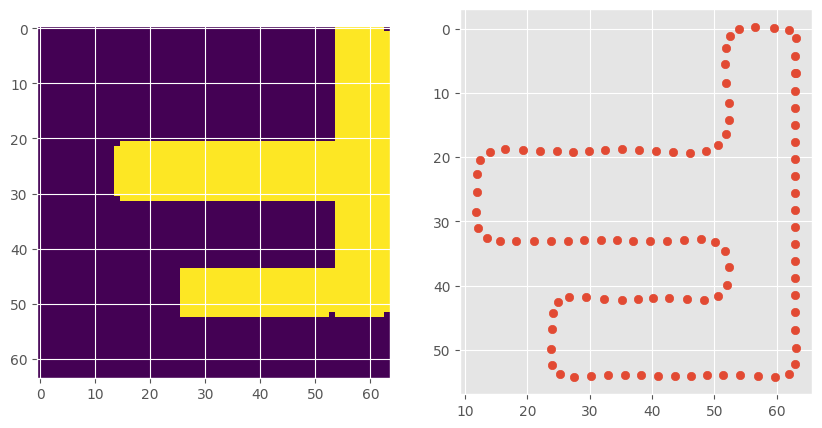

In [6]:
i = 3

img = X_img[i]*255
img = img.astype(np.uint8)
points = get_control_points_from_image(img)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(img, cmap='viridis')

axs[1].scatter(points[:,1], points[:,0])
axs[1].invert_yaxis()

In [7]:
Y = []
errors = 0

for i, img in enumerate(X_img):
    img = img*255
    img = img.astype(np.uint8)
    points = get_control_points_from_image(img)
    if points is None:
        errors += 1
        Y.append({'area': -1,
            'perimeter': -1,
            'amplitude': -1,
            'convex': -1,
            'notches': -1,
            'complexity': -1})
        continue
    c = complexity(points)
    Y.append(c)

    print(f"Progress: {i/len(X_img)*100:.2f} % ({i}/{len(X_img)}) | Errors: {errors}", end="\r")

Y = np.array(Y)

In [8]:
np.save("metrics_CARLA.npy", Y)

In [15]:
C = []

for values in Y:
    C.append([values['area'], values['perimeter'], values['amplitude'], values['convex'], values['notches'], values['complexity']])

C = np.array(C)

In [19]:
_ = np.load("metrics_CARLA.npy", allow_pickle=True)
_.shape

(64770, 6)

In [ ]:
###########################################################

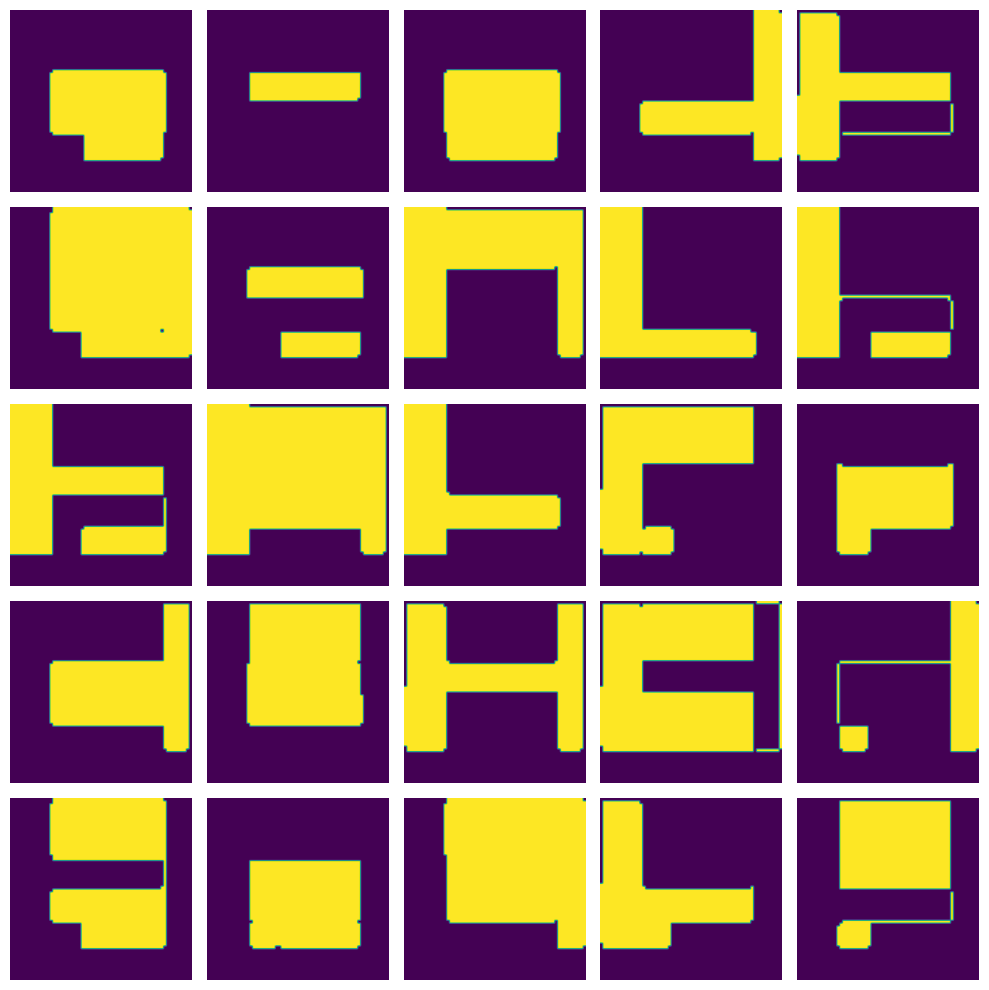

In [29]:
# Plot a 5x5 grid of images
plt.figure(figsize=(10, 10))

for i in range(25):
    idx = np.random.randint(len(X_img))
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_img[idx])
    plt.axis('off')

plt.tight_layout()

Load geometric shapes (images)

In [19]:
X_img = np.load('../VAE/shape_images_64x64.npy').astype(np.float32)
X = np.zeros_like(X_img)
Y = np.load('../VAE/shape_labels.npy')

# Normalize
X_img /= 255.

Create training and test datasets

In [ ]:
# Resize images
import cv2

new_shape = (64, 64)

X_img = np.array([cv2.resize(x, new_shape, interpolation=cv2.INTER_NEAREST) for x in X_img])

X_img = np.copy(X_img).astype(np.float32) / 255.

In [10]:
# Create training and validation sets
from sklearn.model_selection import train_test_split

X_img_train, X_img_val, Y_train, Y_val = train_test_split(X_img, Y, test_size=0.1, random_state=42)

# Create datasets
train_dataset = ImagesDataset(X_img_train, Y_train)
val_dataset = ImagesDataset(X_img_val, Y_val)

Define Model

https://github.com/jan-xu/autoencoders/blob/master/vae/vae.ipynb

In [11]:
import torch
import torch.nn as nn

class DenseLayer(nn.Module):
    """
    A dense layer, consisting of two convolutional filters with batch
    normalisation and ReLU activation functions. The input layer is
    concatenated with the output layer.
    """
    
    def __init__(self, in_channels, growth_rate, mode='encode'):
        assert mode in ['encode', 'decode'], "Mode must be either 'encode' or 'decode'."
        super(DenseLayer, self).__init__()
        self.BN1 = nn.BatchNorm2d(in_channels)
        self.relu1 = nn.ReLU()
        if mode == 'encode':
            self.conv1 = nn.Conv2d(in_channels, 4*growth_rate, 1, 1, 0)
            self.conv2 = nn.Conv2d(4*growth_rate, growth_rate, 3, 1, 1)
        elif mode == 'decode':
            self.conv1 = nn.ConvTranspose2d(in_channels, 4*growth_rate, 1, 1, 0)
            self.conv2 = nn.ConvTranspose2d(4*growth_rate, growth_rate, 3, 1, 1)
        self.BN2 = nn.BatchNorm2d(4*growth_rate)
        self.relu2 = nn.ReLU()
    
    def forward(self, x):
        bn1 = self.BN1(x)
        relu1 = self.relu1(bn1)
        conv1 = self.conv1(relu1)
        bn2 = self.BN2(conv1)
        relu2 = self.relu2(bn2)
        conv2 = self.conv2(relu2)
        return torch.cat([x, conv2], dim=1)

class DenseBlock(nn.Module):
    """
    A dense block, consisting of three dense layers.
    """
    
    def __init__(self, in_channels, growth_rate, mode='encode'):
        assert mode in ['encode', 'decode'], "Mode must be either 'encode' or 'decode'."
        super(DenseBlock, self).__init__()
        self.DL1 = DenseLayer(in_channels+(growth_rate*0), growth_rate, mode)
        self.DL2 = DenseLayer(in_channels+(growth_rate*1), growth_rate, mode)
        self.DL3 = DenseLayer(in_channels+(growth_rate*2), growth_rate, mode)
    
    def forward(self, x):
        DL1 = self.DL1(x)
        DL2 = self.DL2(DL1)
        DL3 = self.DL3(DL2)
        return DL3

class TransitionBlock(nn.Module):
    """
    A transition block, consisting of a convolutional layer followed by a
    resize layer (average pooling for downsampling, transpose convolutional
    layer for upsampling).
    """
    
    def __init__(self, in_channels, c_rate, mode='encode'):
        assert mode in ['encode', 'decode'], "Mode must be either 'encode' or 'decode'."
        super(TransitionBlock, self).__init__()
        out_channels = int(c_rate*in_channels)
        self.BN = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()
        if mode == 'encode':
            self.conv = nn.Conv2d(in_channels, out_channels, 1, 1, 0)
            self.resize_layer = nn.AvgPool2d(2, 2)
        elif mode == 'decode':
            self.conv = nn.ConvTranspose2d(in_channels, out_channels, 1, 1, 0)
            self.resize_layer = nn.ConvTranspose2d(out_channels, out_channels, 2, 2, 0)
    
    def forward(self, x):
        bn = self.BN(x)
        relu = self.relu(bn)
        conv = self.conv(relu)
        output = self.resize_layer(conv)
        return output

class Encoder(nn.Module):
    """
    Encoder class, mainly consisting of three dense blocks and two
    transition blocks.
    """
    
    def __init__(self, in_channels):
        super(Encoder, self).__init__()
        self.init_conv = nn.Conv2d(in_channels, 24, 3, 2, 1) # 24 16 16
        self.BN1 = nn.BatchNorm2d(24)
        self.relu1 = nn.ReLU()
        self.db1 = DenseBlock(24, 8, 'encode') # 48 16 16
        self.tb1 = TransitionBlock(48, 0.5, 'encode') # 24 8 8
        self.db2 = DenseBlock(24, 8, 'encode') # 48 8 8
        self.tb2 = TransitionBlock(48, 0.5, 'encode') # 24 4 4
        self.db3 = DenseBlock(24, 8, 'encode') # 48 4 4
        self.BN2 = nn.BatchNorm2d(48)
        self.relu2 = nn.ReLU()
        self.down_conv = nn.Conv2d(48, 24, 2, 2, 0) # 24 2 2
    
    def forward(self, inputs):
        init_conv = self.init_conv(inputs)
        bn1 = self.BN1(init_conv)
        relu1 = self.relu1(bn1)
        db1 = self.db1(relu1)
        tb1 = self.tb1(db1)
        db2 = self.db2(tb1)
        tb2 = self.tb2(db2)
        db3 = self.db3(tb2)
        bn2 = self.BN2(db3)
        relu2 = self.relu2(bn2)
        down_conv = self.down_conv(relu2)
        return down_conv

class Decoder(nn.Module):
    """
    Decoder class, mainly consisting of three dense blocks and two
    transition blocks.
    """
    
    def __init__(self, out_channels):
        super(Decoder, self).__init__()
        self.up_conv = nn.ConvTranspose2d(24, 24, 2, 2, 0) # 24 4 4
        self.db1 = DenseBlock(24, 8, 'decode') # 48 4 4
        self.tb1 = TransitionBlock(48, 0.5, 'decode') # 24 8 8
        self.db2 = DenseBlock(24, 8, 'decode') # 48 8 8
        self.tb2 = TransitionBlock(48, 0.5, 'decode') # 24 16 16
        self.db3 = DenseBlock(24, 8, 'decode') # 48 16 16
        self.BN1 = nn.BatchNorm2d(48)
        self.relu1 = nn.ReLU()
        self.de_conv = nn.ConvTranspose2d(48, 24, 2, 2, 0) # 24 32 32
        self.BN2 = nn.BatchNorm2d(24)
        self.relu2 = nn.ReLU()
        self.out_conv = nn.ConvTranspose2d(24, out_channels, 3, 1, 1) # 3 32 32
        self.tanh = nn.Tanh()
        
    def forward(self, inputs):
        up_conv = self.up_conv(inputs)
        db1 = self.db1(up_conv)
        tb1 = self.tb1(db1)
        db2 = self.db2(tb1)
        tb2 = self.tb2(db2)
        db3 = self.db3(tb2)
        bn1 = self.BN1(db3)
        relu1 = self.relu1(bn1)
        de_conv = self.de_conv(relu1)
        bn2 = self.BN2(de_conv)
        relu2 = self.relu2(bn2)
        out_conv = self.out_conv(relu2)
        output = self.tanh(out_conv)
        return output


# Normal VAE
class BottleneckVAE(nn.Module):
    """
    Bottleneck class, consisting of two convolutional layers
    """

    def __init__(self):
        super(BottleneckVAE, self).__init__()
        self.conv_mu = nn.Conv2d(24, 32, 1, 1, 0)
        self.conv_logvar = nn.Conv2d(24, 32, 1, 1, 0)
        self.conv_z = nn.Conv2d(32, 24, 1, 1, 0)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, inputs):
        mu = self.conv_mu(inputs)
        logvar = self.conv_logvar(inputs)
        z = self.reparameterize(mu, logvar)
        z = self.conv_z(z)
        return z


# VQ-VAE
from vector_quantize_pytorch import VectorQuantize

class BottleneckVQ(nn.Module):
    """
    Bottleneck class, consisting of two convolutional layers
    """

    def __init__(self, bottleneck_dim, codebook_size, codebook_dim):
        super(BottleneckVQ, self).__init__()

        self.vq = VectorQuantize(dim=bottleneck_dim,
                                codebook_size=codebook_size,
                                codebook_dim=codebook_dim,
                                accept_image_fmap=True,
                                commitment_weight=0.,
                                decay=0.99,
                                eps=1e-5,
                                orthogonal_reg_weight = 10,                 # in paper, they recommended a value of 10
                                orthogonal_reg_max_codes = 128,             # this would randomly sample from the codebook for the orthogonal regularization loss, for limiting memory usage
                                orthogonal_reg_active_codes_only = False)    # set this to True if you have a very large codebook, and would only like to enforce the loss on the activated codes per batch)
                                
    def forward(self, inputs):
        x, indices, commit_loss = self.vq(inputs)        
        return x, indices, commit_loss

In [12]:
class Autoencoder(nn.Module):
    """
    Autoencoder class, combines encoder and decoder model.
    """
    
    def __init__(self, num_channels, vq=False, codebook_size=None, codebook_dim=None):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(num_channels)
        self.decoder = Decoder(num_channels)
        self.vq = vq
        self.codebook_size = codebook_size
        self.codebook_dim = codebook_dim
        if vq:
            assert codebook_size is not None, "Codebook size must be provided."
            assert codebook_dim is not None, "Codebook dim must be provided."
            self.bottleneck = BottleneckVQ(24, codebook_size=codebook_size, codebook_dim=codebook_dim)
        else:
            self.bottleneck = BottleneckVAE()

    @property
    def num_params(self):
        model_parameters = filter(lambda p: p.requires_grad, self.parameters())
        num_p = sum([np.prod(p.size()) for p in model_parameters])
        return num_p
    
    def forward(self, inputs):
        encoded = self.encoder(inputs)

        if self.vq:
            # VQ-VAE
            z, indices, commit_loss = self.bottleneck(encoded)
        else:
            # Normal VAE
            indices, commit_loss = None, 0
            z = self.bottleneck(encoded)

        decoded = self.decoder(z)
        return decoded.clamp(-1, 1), indices, commit_loss

In [13]:
num_channels = 3 if X_img.ndim == 4 else 1
print("Number of parameters in model: {0}".format(Autoencoder(num_channels).num_params))

Number of parameters in model: 87401


Train VAE

In [14]:
from tqdm.auto import trange

import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def train_vae(model, train_loader, val_loader, writer, num_epochs=10, learning_rate=1e-4,
              early_stopping={'patience': 15, 'min_delta': 0.001}, wandb_track=True):
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, min_lr=1e-6, threshold=1e-3)

    loss_history = {'train_loss': [], 'val_loss': [], 'commit_loss': []}
    early_stop_counter = 0
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        # Training
        i = 0  # Current batch
        n = 1  # Plot index
        plt.figure(figsize=(18, 3))
        for x, y in train_loader:
            optimizer.zero_grad()

            x = x.to(device)

            # VQ
            x_hat, indices, cmt_loss_train = model(x)
            alpha = 10
            rec_loss = nn.MSELoss(reduction='sum')(x_hat, x)
            loss = rec_loss + alpha * cmt_loss_train

            if i % int(len(train_loader.dataset)/train_loader.batch_size/3 + 1) == 0:
                plt.subplot(1, 6, n)
                x = x.clamp(0, 1)
                x_hat = x_hat.clamp(0, 1)
                plt.imshow(x[0].cpu().detach().numpy().transpose(1, 2, 0))
                plt.title('Original')
                plt.axis('off')
                plt.subplot(1, 6, n+1)
                plt.imshow(x_hat[0].cpu().detach().numpy().transpose(1, 2, 0))
                plt.title('Reconstructed')
                plt.axis('off')
                n += 2

            loss.backward()
            
            # Add gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            total_loss += loss.item()

            i += 1
        
        plt.tight_layout()
        plt.show()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:

                x = x.to(device)

                # VQ
                codebook_size = 256
                x_hat, indices, cmt_loss = model(x)
                rec_loss = nn.MSELoss(reduction='sum')(x_hat, x)
                loss = rec_loss + alpha * cmt_loss

                val_loss += loss.item()
        val_loss /= len(val_loader.dataset)

        average_loss = total_loss / len(train_loader.dataset)
        print(f'Epoch [{epoch + 1}/{num_epochs}] | '
            + f'train_loss: {average_loss:.4f} | '
            + f'val_loss: {val_loss:.4f} | '
            # + f'commitment_loss: {cmt_loss_train.item():.4f} | '
            # + f"active %: {indices.unique().numel() / codebook_size * 100:.3f} "
            + f'lr: {scheduler._last_lr[0]} | '
            + f'early_stop_counter: {early_stop_counter}')

        loss_history['train_loss'].append(average_loss)
        loss_history['val_loss'].append(val_loss)
        #loss_history['commit_loss'].append(cmt_loss_train.item())

        # WandB logging
        if wandb_track:
            writer.add_scalar(f"losses/train_loss", average_loss, epoch)
            writer.add_scalar(f"losses/val_loss", val_loss, epoch)
            writer.add_scalar(f"losses/commitment_loss", cmt_loss_train.item(), epoch)
            writer.add_scalar(f"metrics/active_codebook", indices.unique().numel() / model.codebook_size * 100, epoch)
            writer.add_scalar(f"metrics/lr", scheduler._last_lr[0], epoch)


        # Early stopping
        if epoch > 0:
            if loss_history['val_loss'][-1] < best_val_loss - early_stopping['min_delta']:
                best_val_loss = loss_history['val_loss'][-1]
                early_stop_counter = 0
                # Save best model
                torch.save(model.state_dict(), 'best_model_vq-vae.pth')
            else:
                early_stop_counter += 1

            if early_stop_counter >= early_stopping['patience']:
                print('Early stopping.')
                break
            
        scheduler.step(val_loss)

    print('Training finished.')

    return loss_history

/home/zapata/.local/share/virtualenvs/curriculum_learning_ws-qGcE4JgX/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
args = {"seed": 1234,
        "batch_size": 128,
        "num_epochs": 500,
        "learning_rate": 3e-4,
        "early_stopping": {"patience": 15, "min_delta": 0.001},
        "codebook_size": 64,
        "codebook_dim": 4,
}

In [16]:
# Data loader
train_loader = DataLoader(train_dataset, batch_size=args["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=args["batch_size"], shuffle=False)

Training on cuda


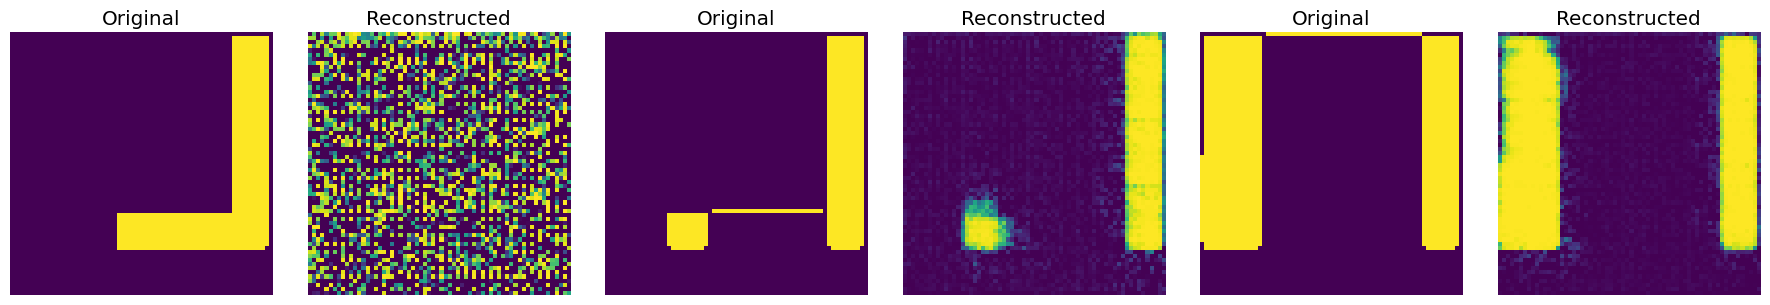

Epoch [1/500] | train_loss: 195.0285 | val_loss: 24.7210 | lr: 0.0003 | early_stop_counter: 0


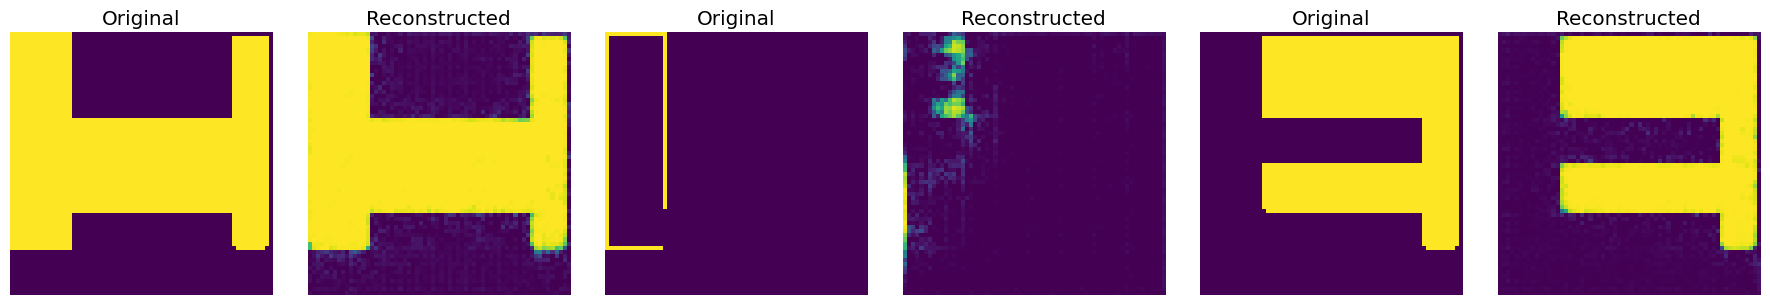

Epoch [2/500] | train_loss: 18.2052 | val_loss: 10.9104 | lr: 0.0003 | early_stop_counter: 0


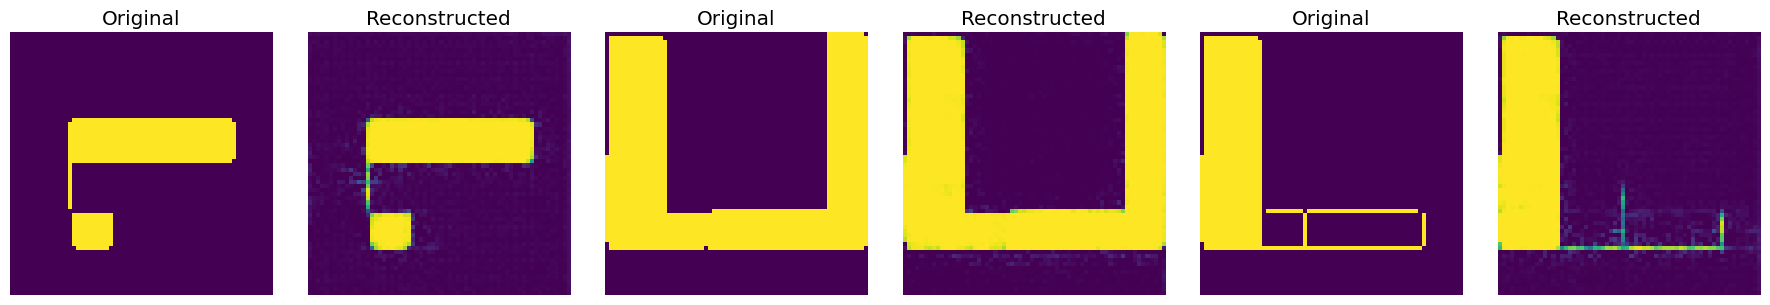

Epoch [3/500] | train_loss: 10.0478 | val_loss: 7.2255 | lr: 0.0003 | early_stop_counter: 0


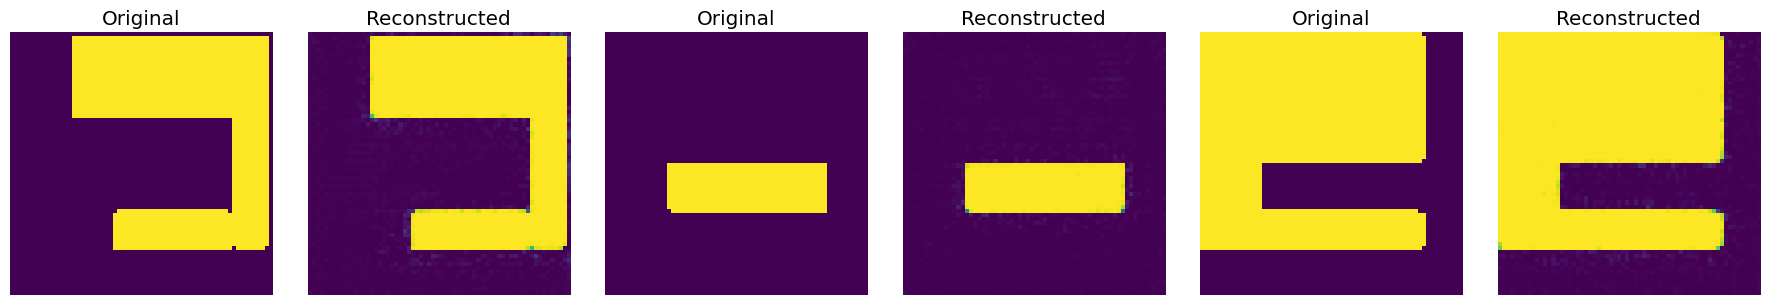

Epoch [4/500] | train_loss: 6.6776 | val_loss: 4.5036 | lr: 0.0003 | early_stop_counter: 0


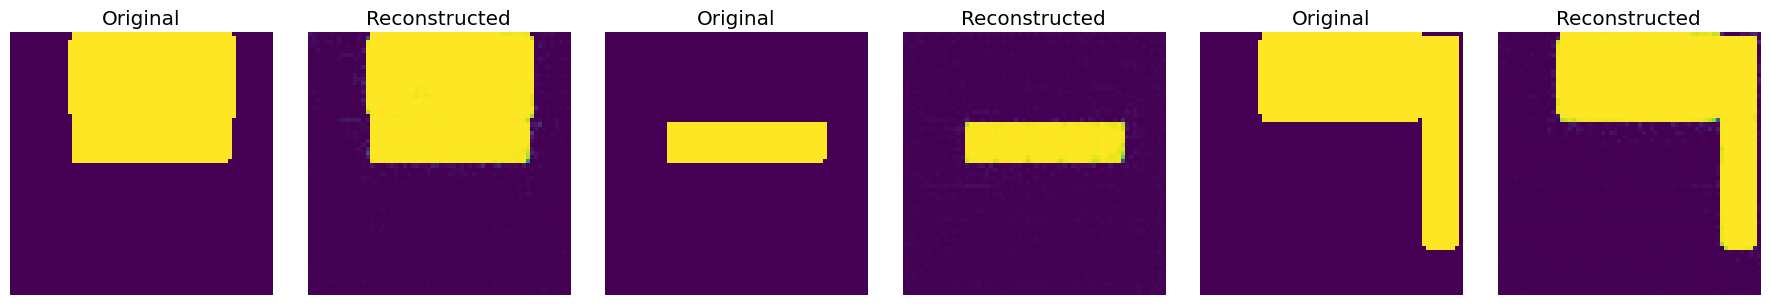

Epoch [5/500] | train_loss: 3.7944 | val_loss: 1.8869 | lr: 0.0003 | early_stop_counter: 0


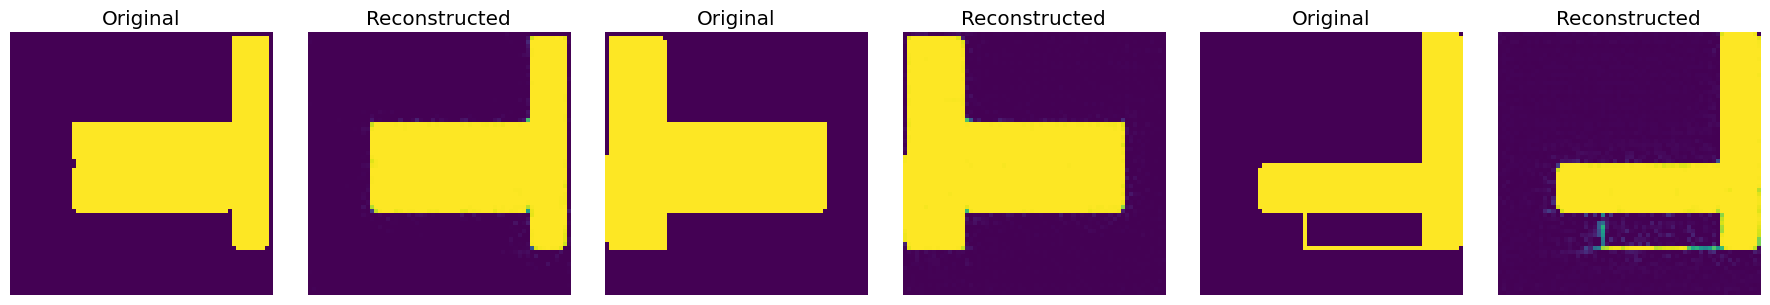

Epoch [6/500] | train_loss: 2.3039 | val_loss: 1.7181 | lr: 0.0003 | early_stop_counter: 0


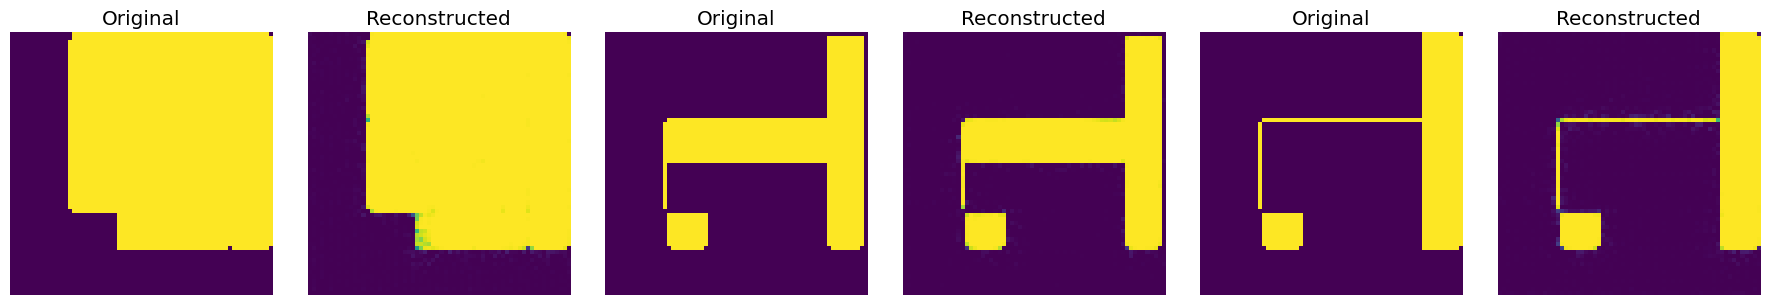

Epoch [7/500] | train_loss: 1.9053 | val_loss: 1.0524 | lr: 0.0003 | early_stop_counter: 0


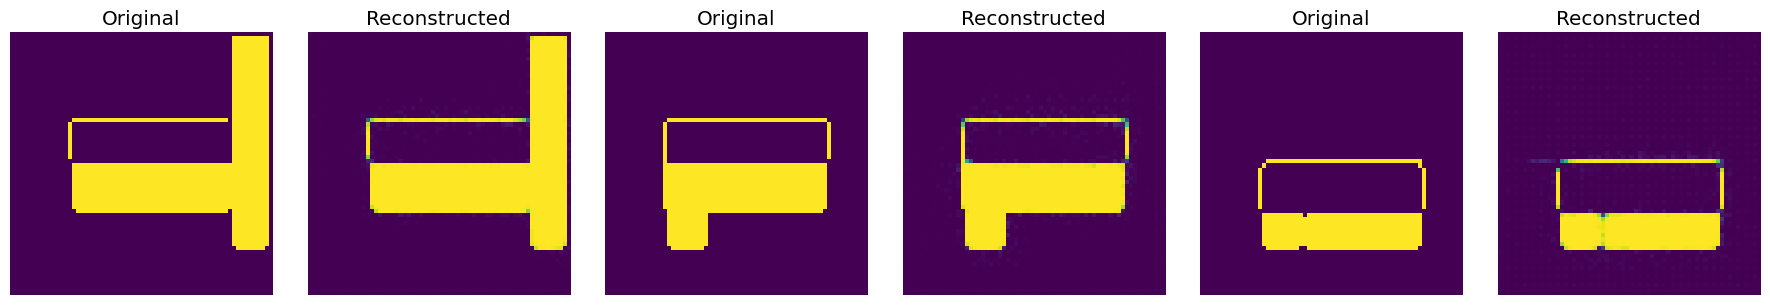

Epoch [8/500] | train_loss: 1.6027 | val_loss: 1.8574 | lr: 0.0003 | early_stop_counter: 0


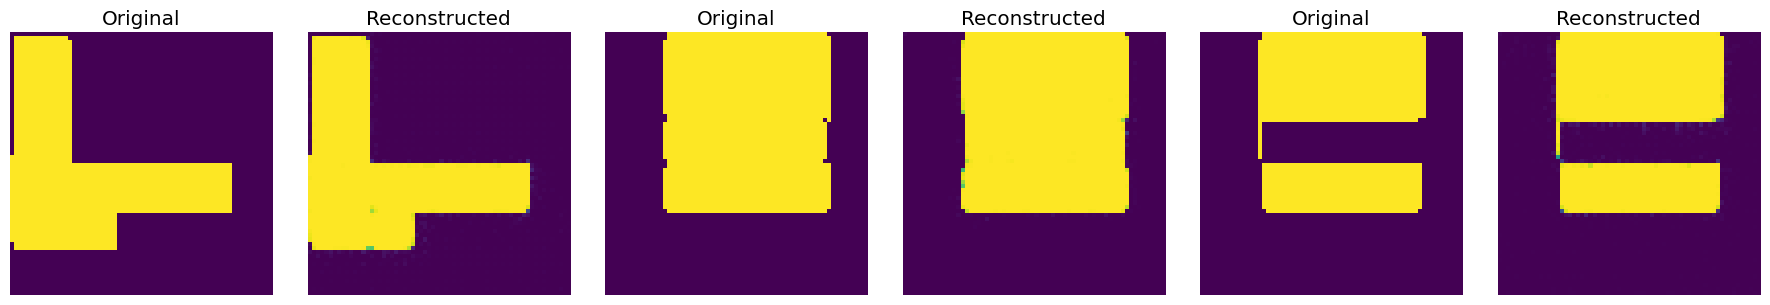

Epoch [9/500] | train_loss: 1.4318 | val_loss: 0.8902 | lr: 0.0003 | early_stop_counter: 1


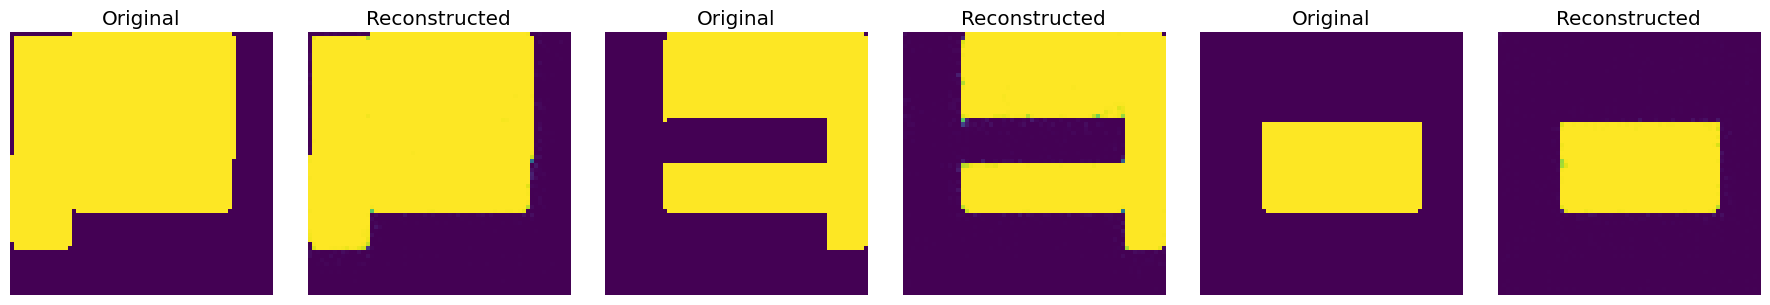

Epoch [10/500] | train_loss: 1.2251 | val_loss: 0.7531 | lr: 0.0003 | early_stop_counter: 0


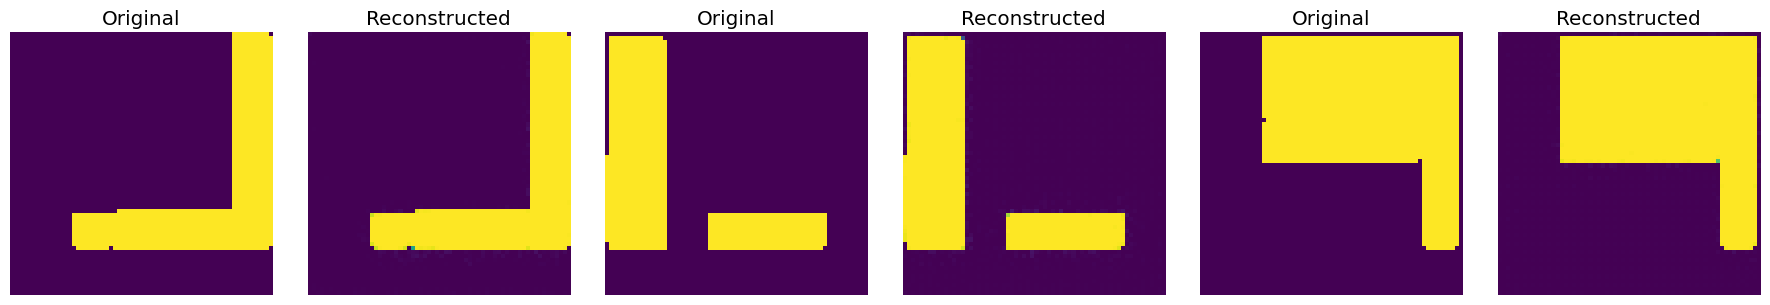

Epoch [11/500] | train_loss: 1.0582 | val_loss: 0.5737 | lr: 0.0003 | early_stop_counter: 0


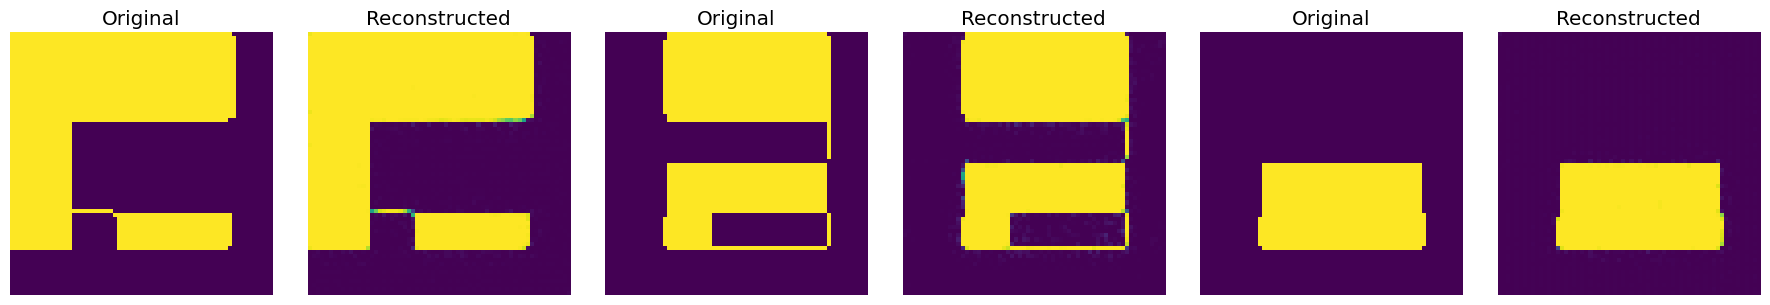

Epoch [12/500] | train_loss: 0.9384 | val_loss: 0.5547 | lr: 0.0003 | early_stop_counter: 0


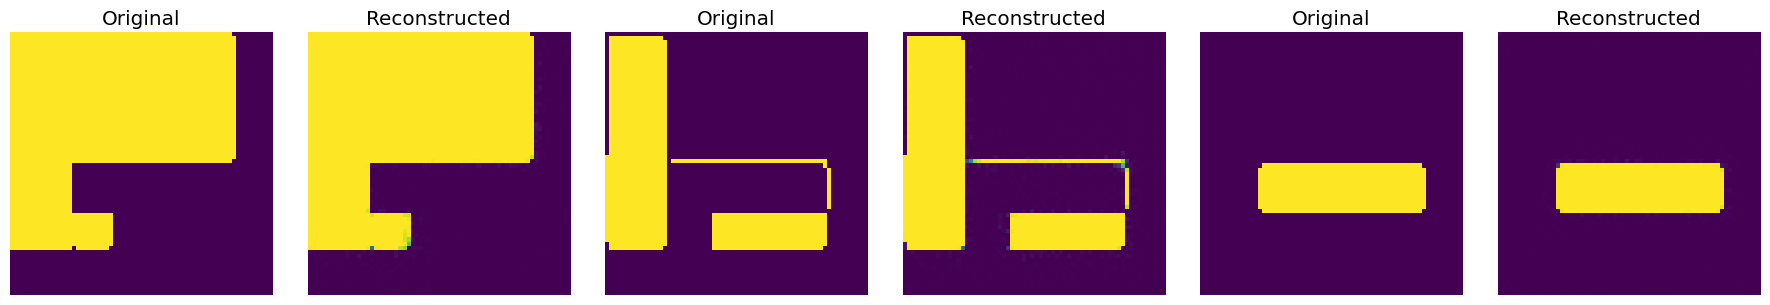

Epoch [13/500] | train_loss: 0.9127 | val_loss: 1.0365 | lr: 0.0003 | early_stop_counter: 0


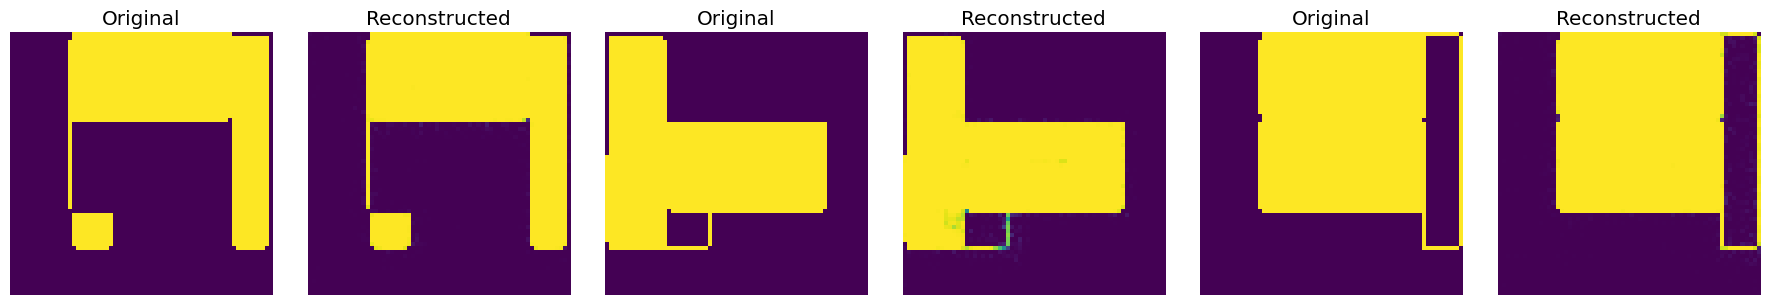

Epoch [14/500] | train_loss: 0.9800 | val_loss: 0.5113 | lr: 0.0003 | early_stop_counter: 1


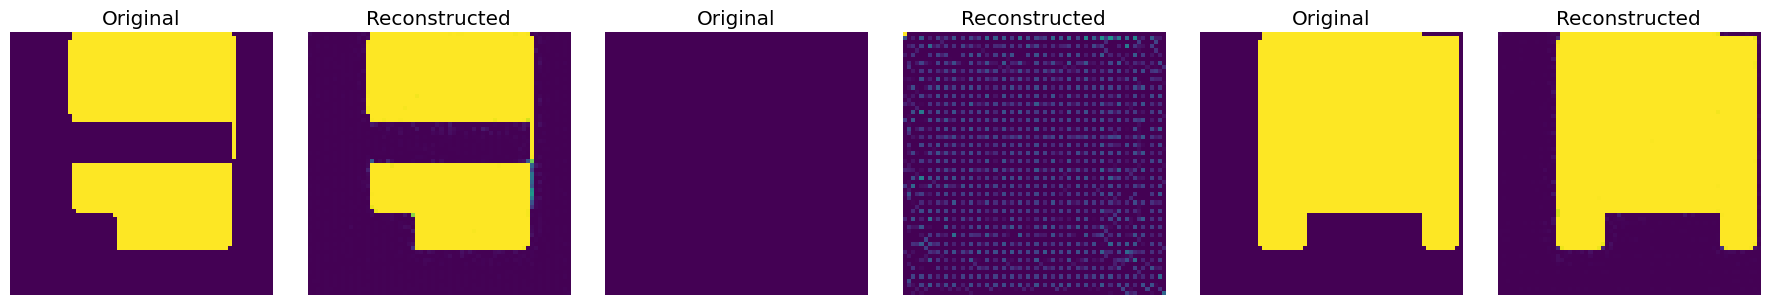

Epoch [15/500] | train_loss: 1.1545 | val_loss: 0.8122 | lr: 0.0003 | early_stop_counter: 0


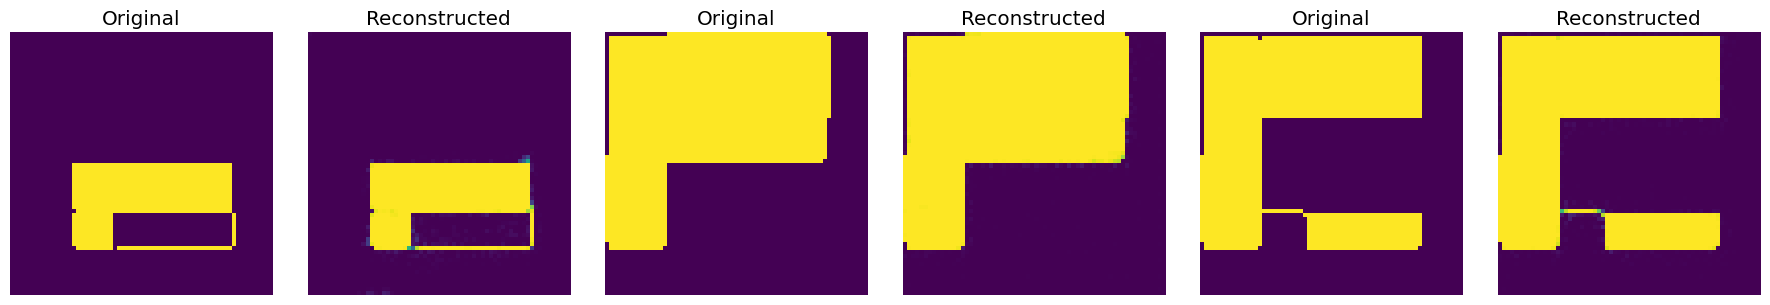

Epoch [16/500] | train_loss: 0.9754 | val_loss: 0.6443 | lr: 0.0003 | early_stop_counter: 1


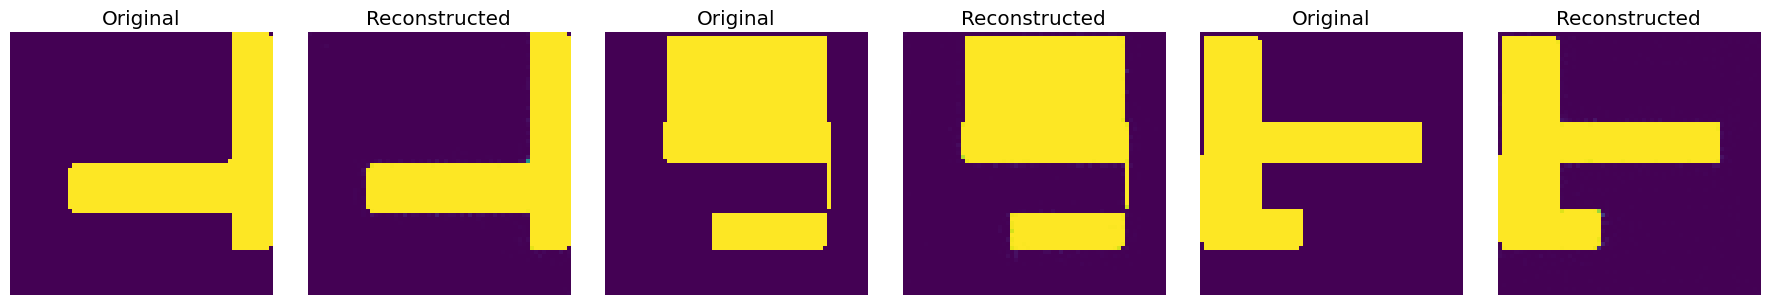

Epoch [17/500] | train_loss: 0.8012 | val_loss: 0.2988 | lr: 0.0003 | early_stop_counter: 2


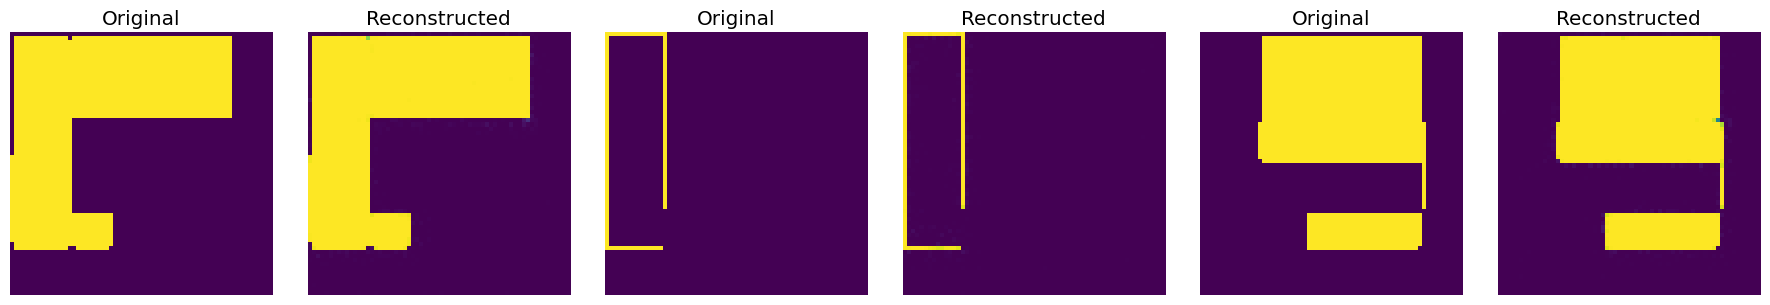

Epoch [18/500] | train_loss: 0.7662 | val_loss: 0.3114 | lr: 0.0003 | early_stop_counter: 0


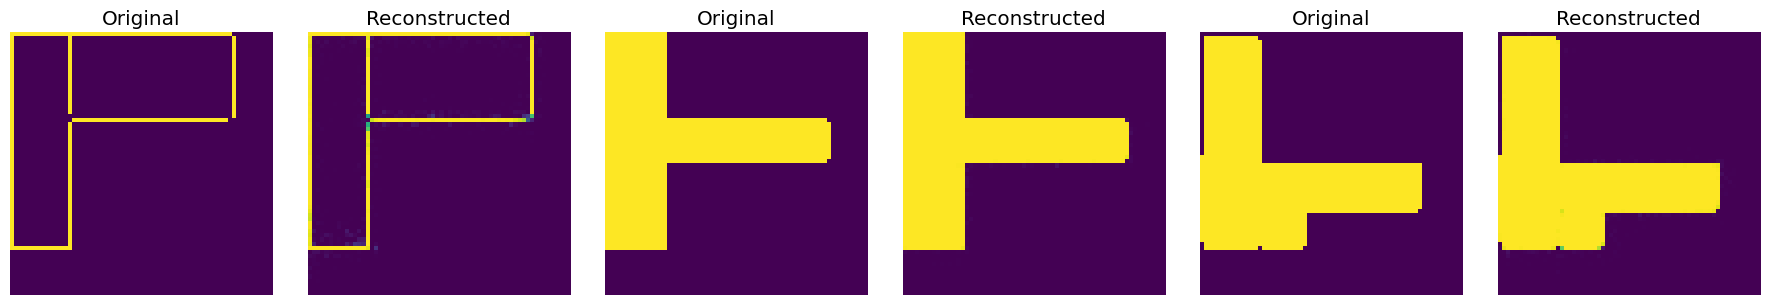

Epoch [19/500] | train_loss: 0.6659 | val_loss: 0.2792 | lr: 0.0003 | early_stop_counter: 1


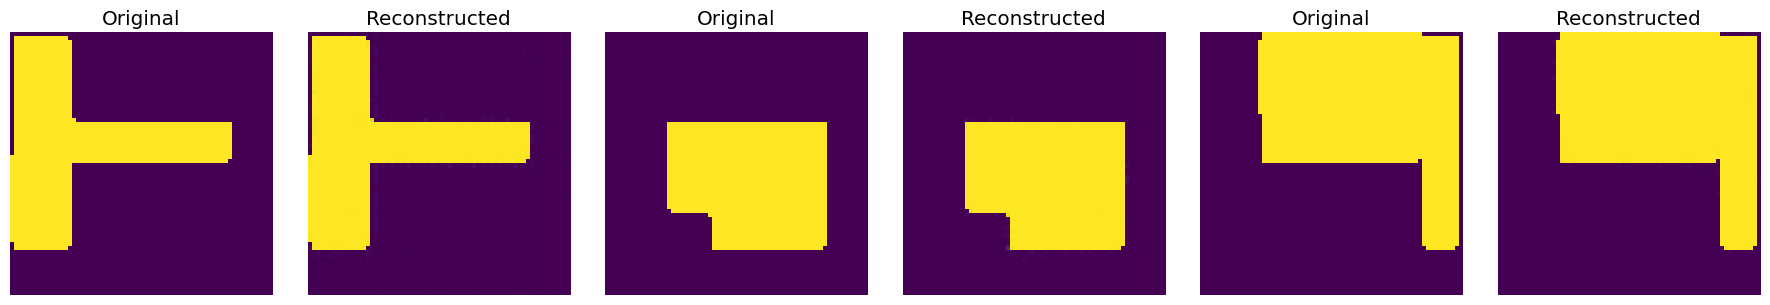

Epoch [20/500] | train_loss: 0.6862 | val_loss: 0.2213 | lr: 0.0003 | early_stop_counter: 0


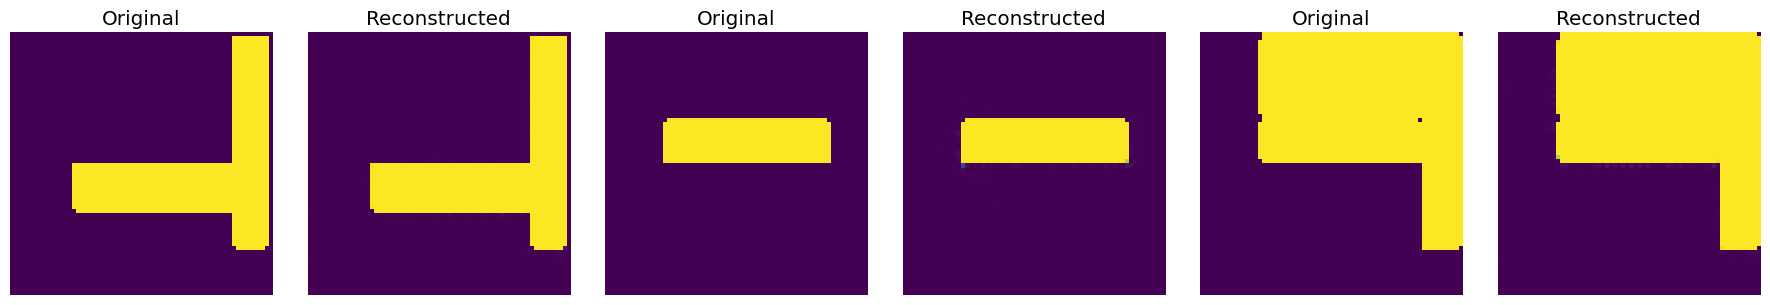

Epoch [21/500] | train_loss: 0.6413 | val_loss: 0.2865 | lr: 0.0003 | early_stop_counter: 0


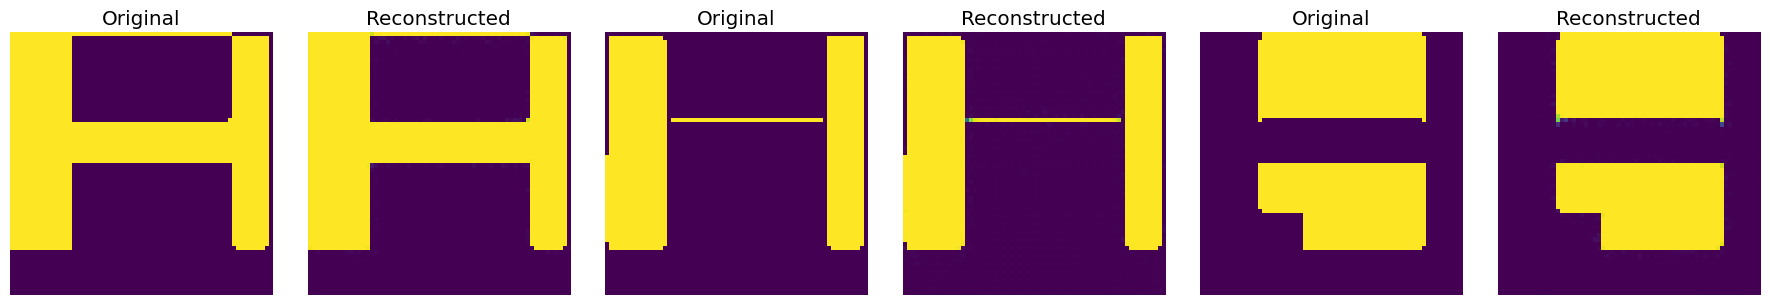

Epoch [22/500] | train_loss: 0.5404 | val_loss: 0.1965 | lr: 0.0003 | early_stop_counter: 1


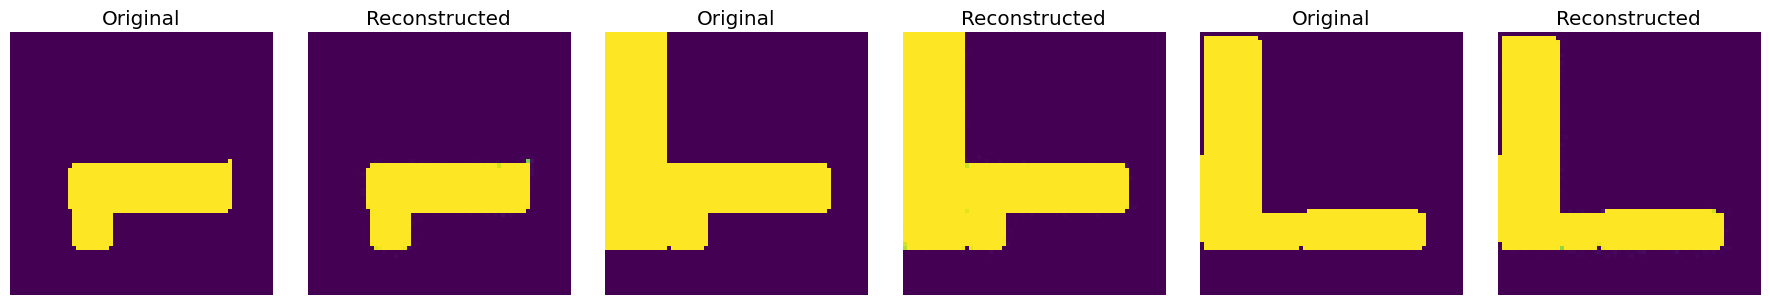

Epoch [23/500] | train_loss: 0.5358 | val_loss: 0.1563 | lr: 0.0003 | early_stop_counter: 0


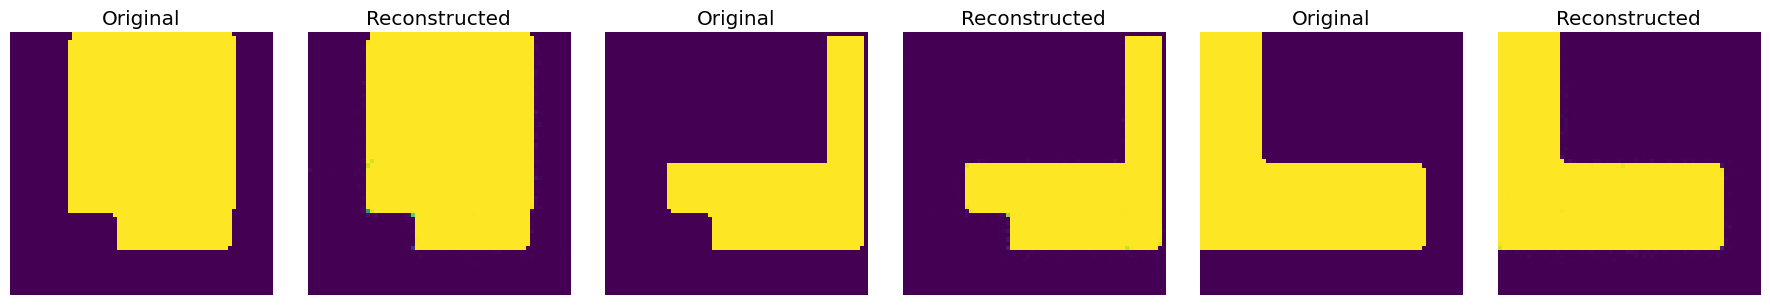

Epoch [24/500] | train_loss: 0.5261 | val_loss: 0.1416 | lr: 0.0003 | early_stop_counter: 0


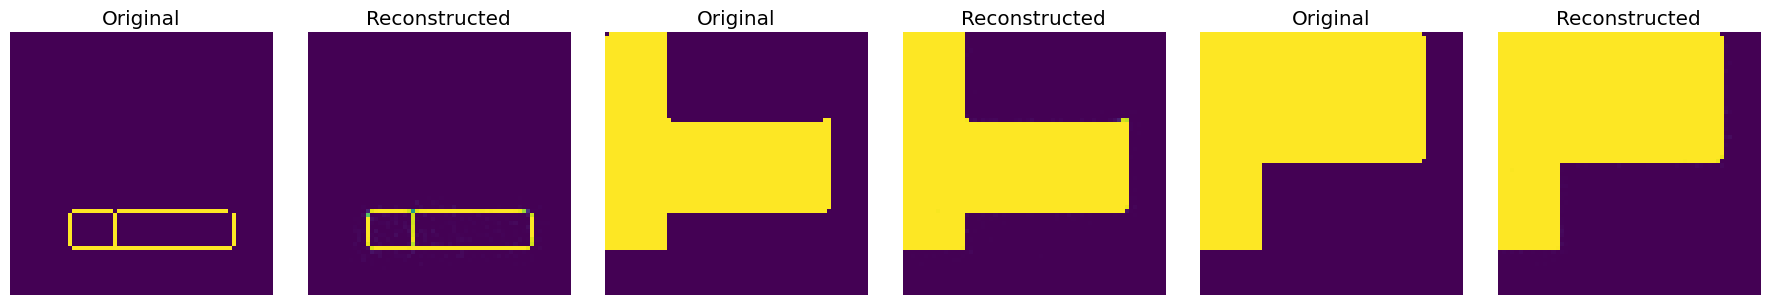

Epoch [25/500] | train_loss: 0.4928 | val_loss: 0.1713 | lr: 0.0003 | early_stop_counter: 0


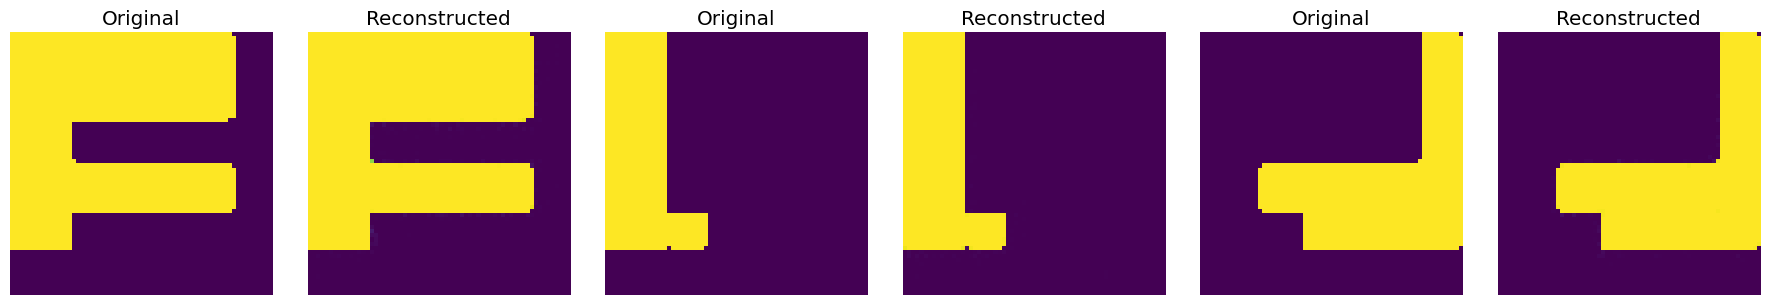

Epoch [26/500] | train_loss: 0.5245 | val_loss: 0.2156 | lr: 0.0003 | early_stop_counter: 1


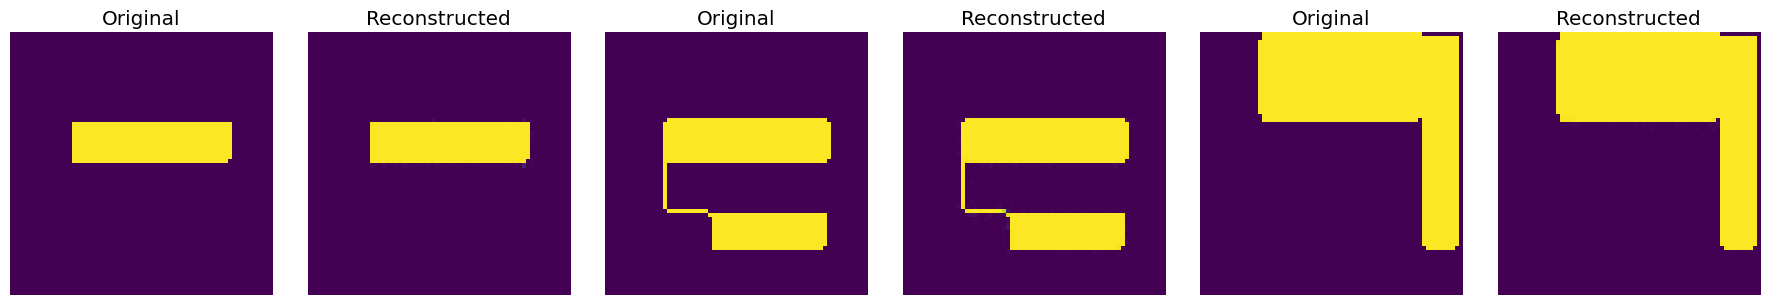

Epoch [27/500] | train_loss: 0.5098 | val_loss: 0.1273 | lr: 0.0003 | early_stop_counter: 2


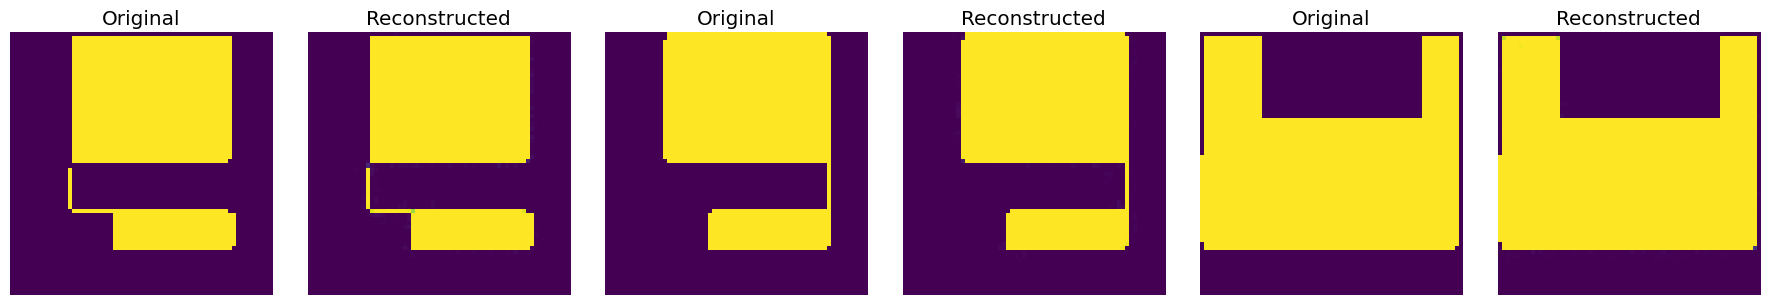

Epoch [28/500] | train_loss: 0.5327 | val_loss: 0.1254 | lr: 0.0003 | early_stop_counter: 0


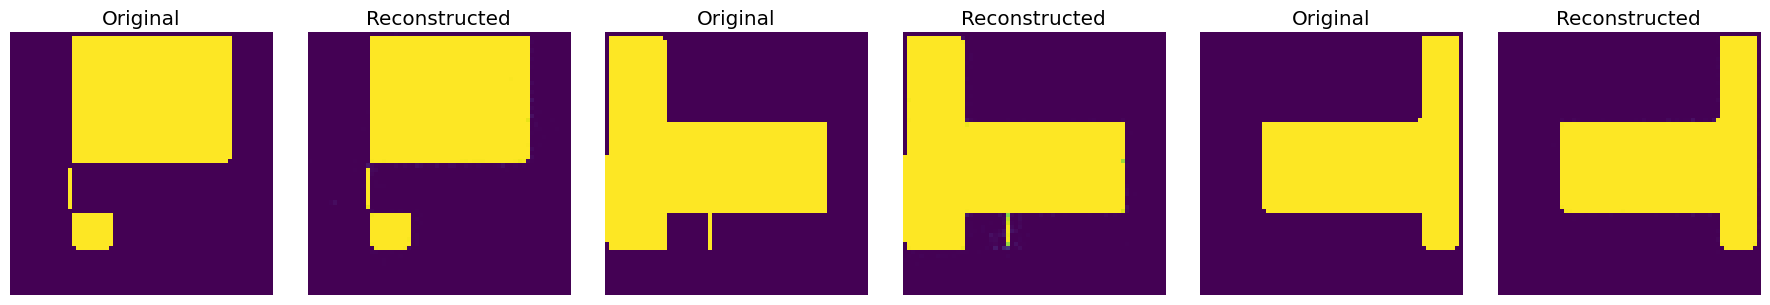

Epoch [29/500] | train_loss: 0.4996 | val_loss: 0.1603 | lr: 0.0003 | early_stop_counter: 0


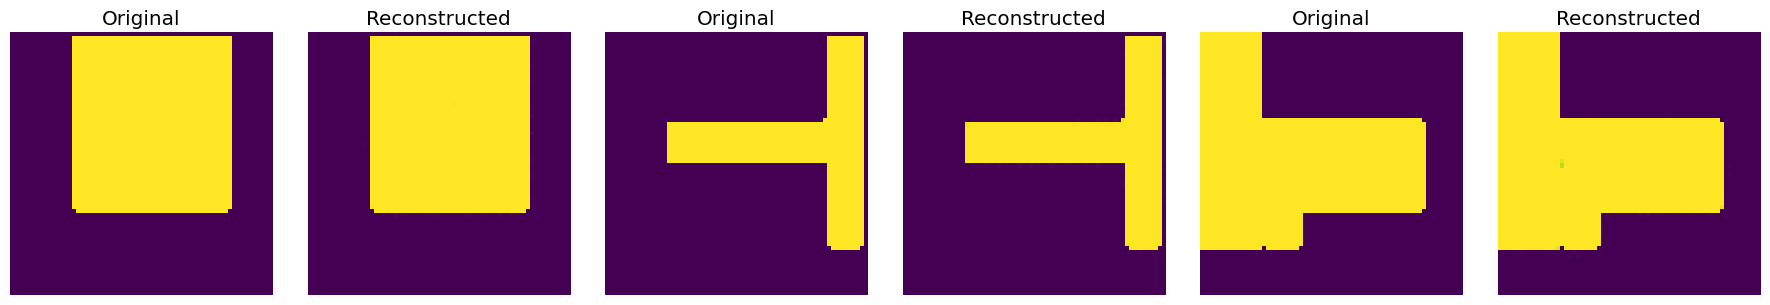

Epoch [30/500] | train_loss: 0.4920 | val_loss: 0.1161 | lr: 0.0003 | early_stop_counter: 1


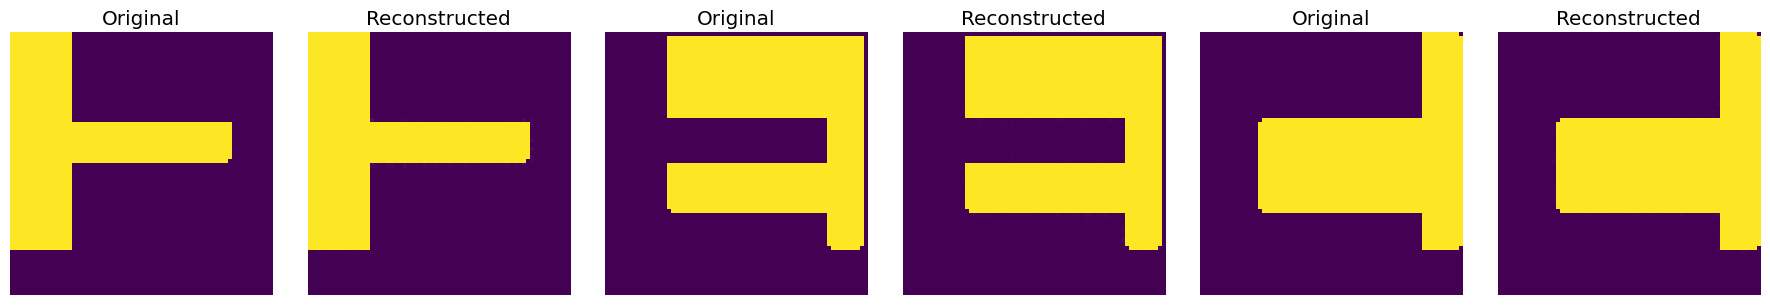

Epoch [31/500] | train_loss: 0.4470 | val_loss: 0.0908 | lr: 0.0003 | early_stop_counter: 0


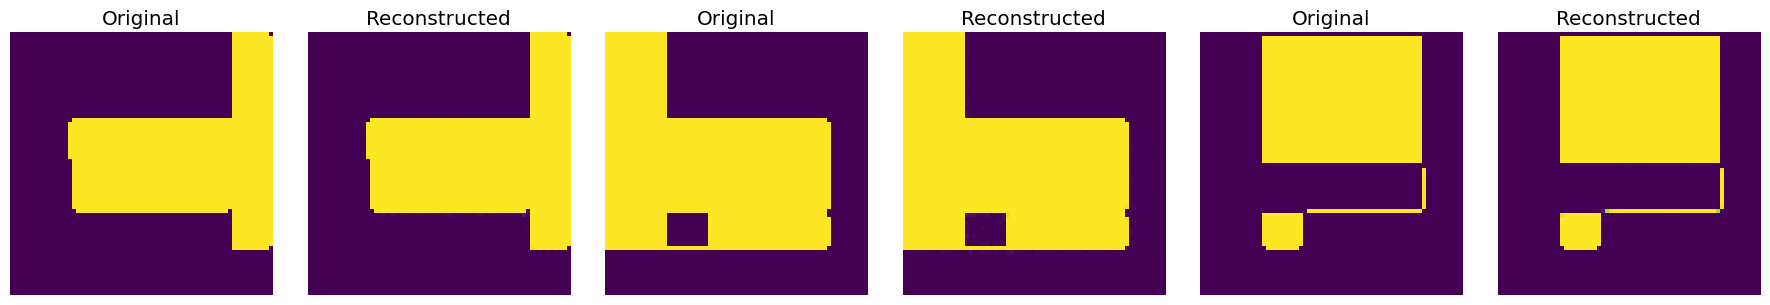

Epoch [32/500] | train_loss: 0.4451 | val_loss: 0.1223 | lr: 0.0003 | early_stop_counter: 0


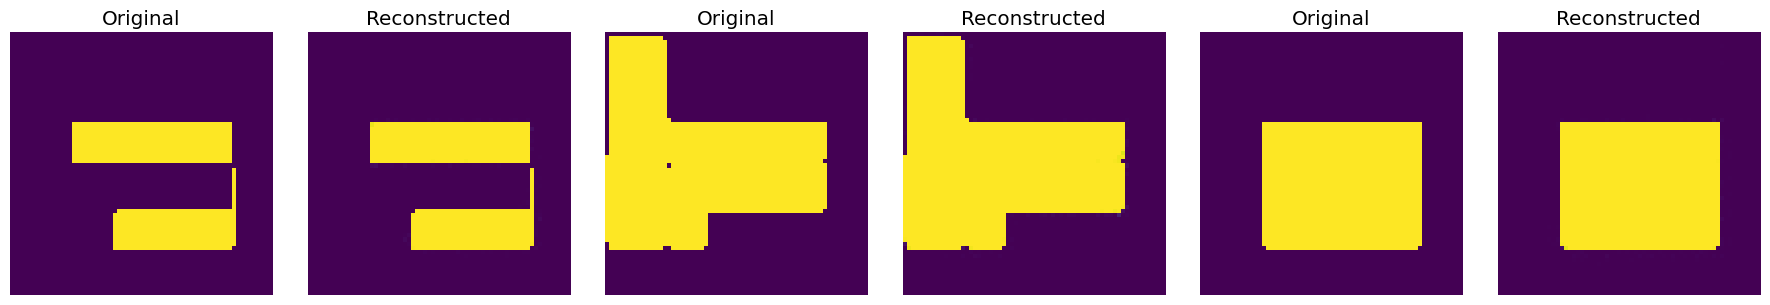

Epoch [33/500] | train_loss: 0.4599 | val_loss: 0.1758 | lr: 0.0003 | early_stop_counter: 1


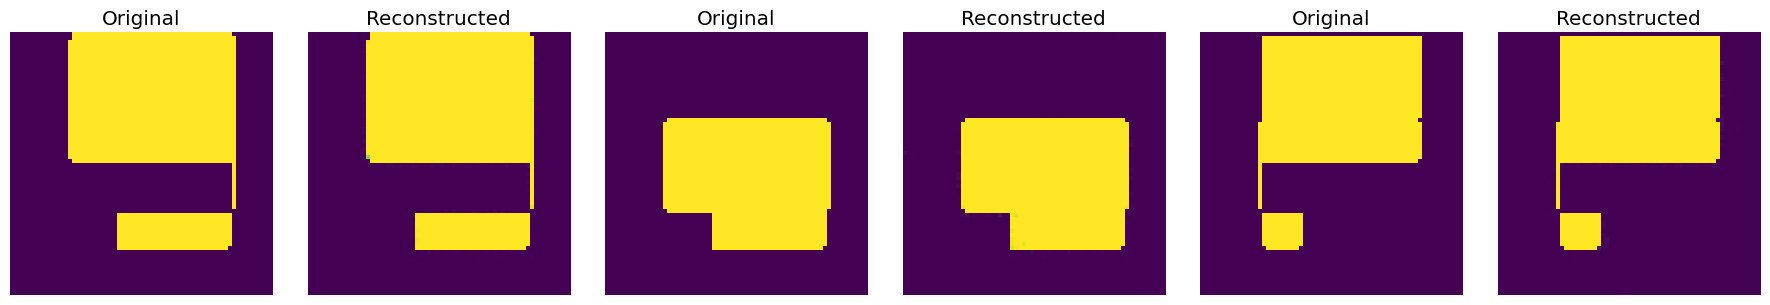

Epoch [34/500] | train_loss: 0.5012 | val_loss: 0.3331 | lr: 0.0003 | early_stop_counter: 2


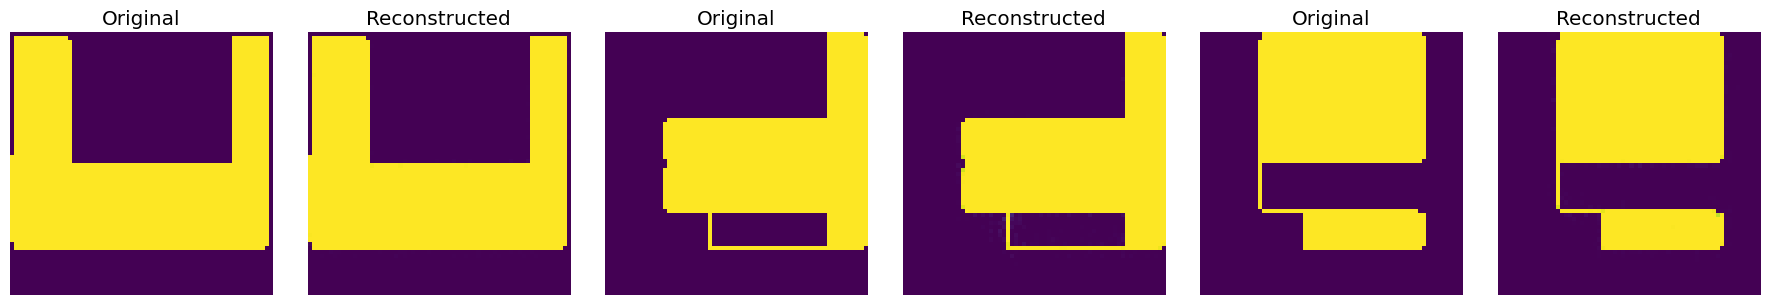

Epoch [35/500] | train_loss: 0.4175 | val_loss: 0.1335 | lr: 0.0003 | early_stop_counter: 3


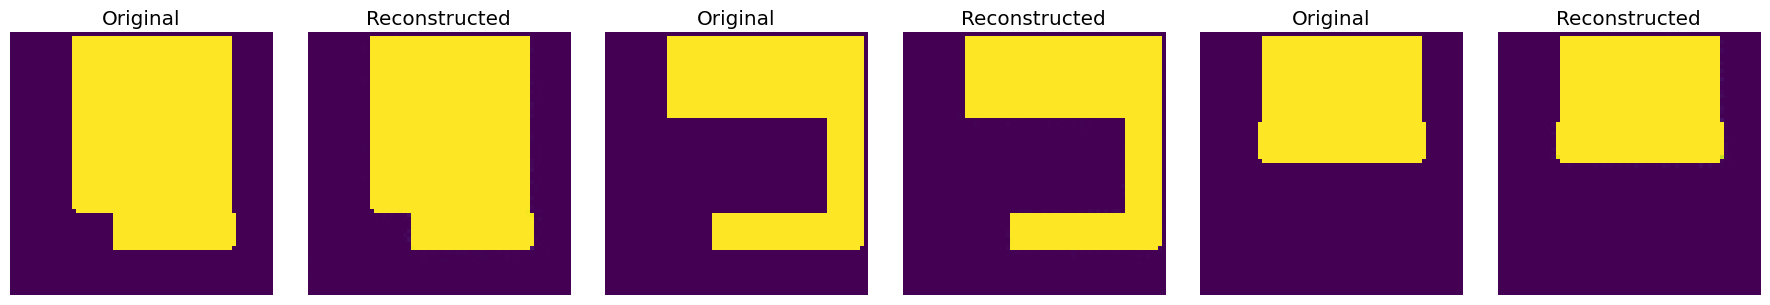

Epoch [36/500] | train_loss: 0.4227 | val_loss: 0.1455 | lr: 0.0003 | early_stop_counter: 4


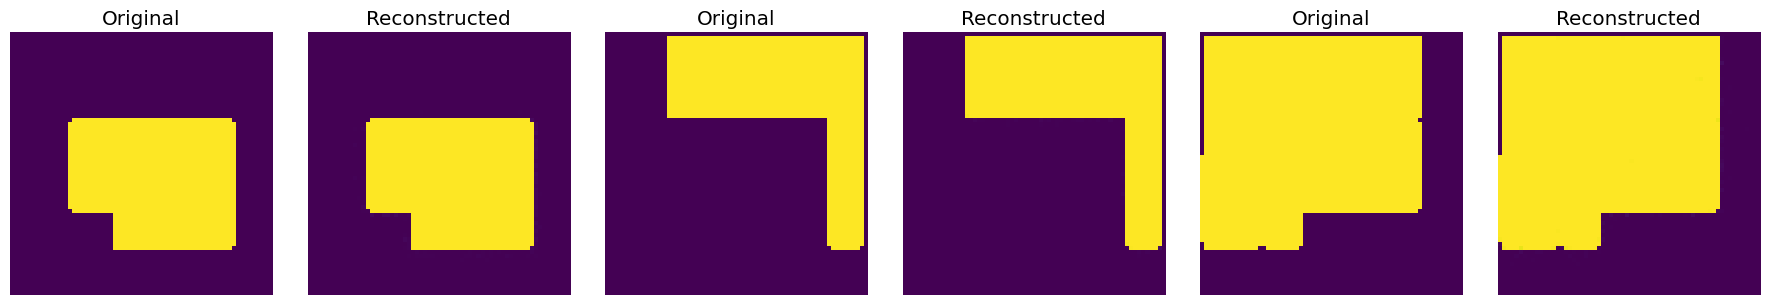

Epoch [37/500] | train_loss: 0.4318 | val_loss: 0.1988 | lr: 0.0003 | early_stop_counter: 5


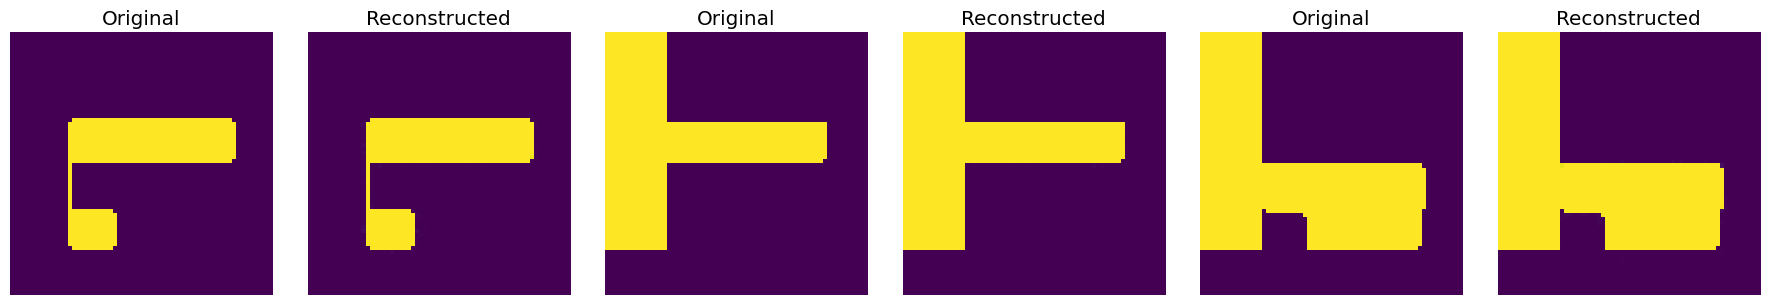

Epoch [38/500] | train_loss: 0.4336 | val_loss: 0.0752 | lr: 0.00015 | early_stop_counter: 6


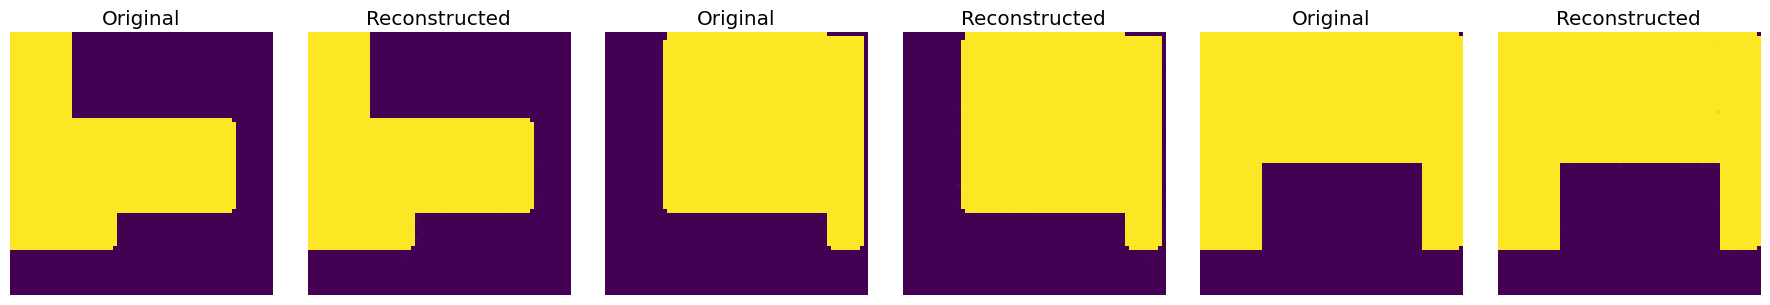

Epoch [39/500] | train_loss: 0.4671 | val_loss: 0.0521 | lr: 0.00015 | early_stop_counter: 0


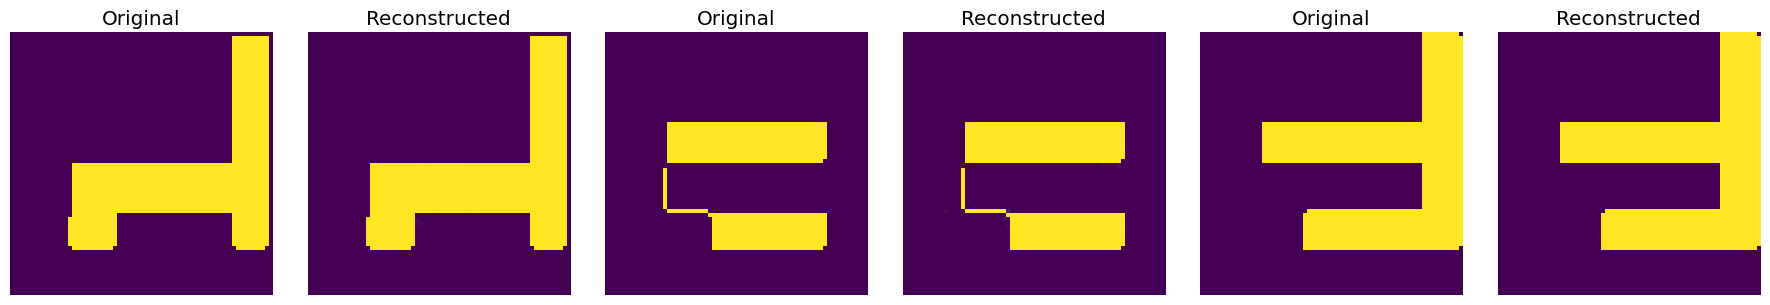

Epoch [40/500] | train_loss: 0.3790 | val_loss: 0.1049 | lr: 0.00015 | early_stop_counter: 0


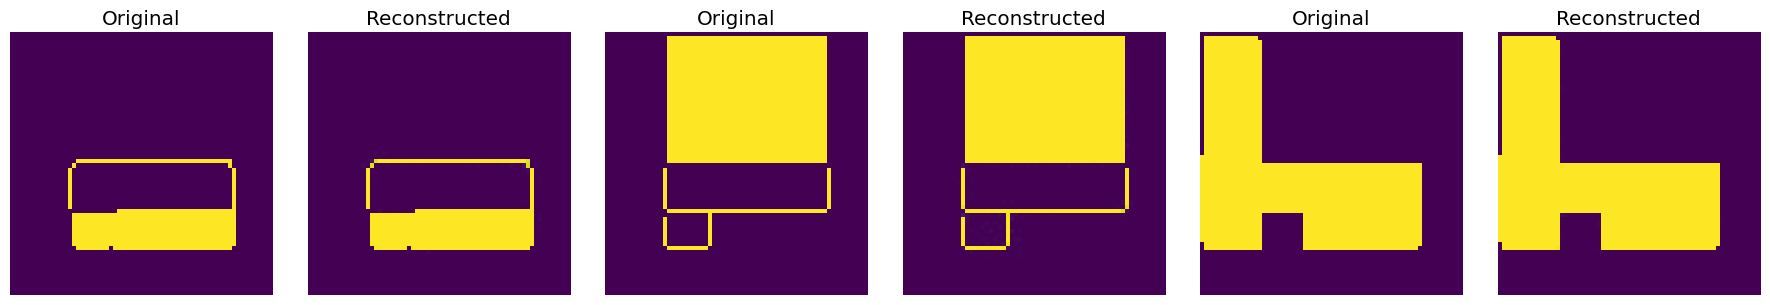

Epoch [41/500] | train_loss: 0.3718 | val_loss: 0.0411 | lr: 0.00015 | early_stop_counter: 1


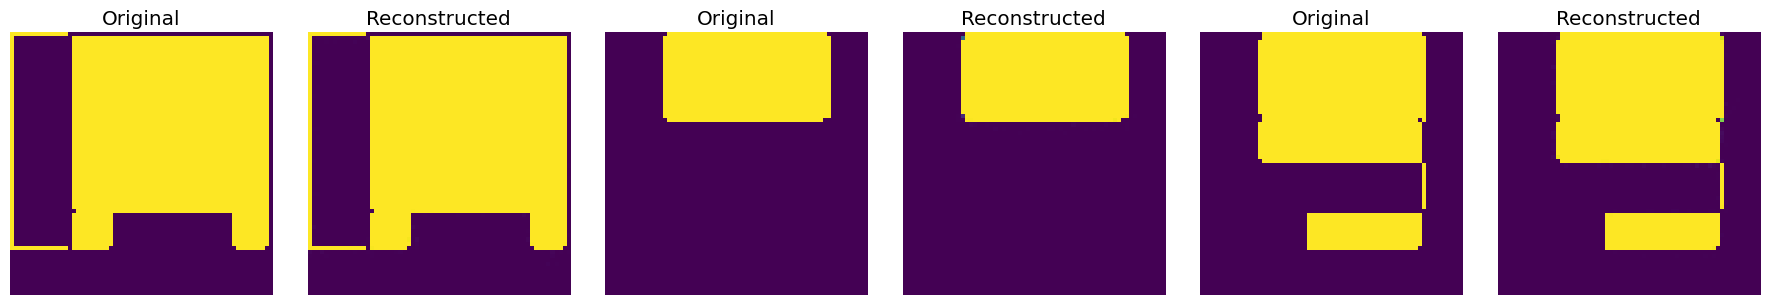

Epoch [42/500] | train_loss: 0.4113 | val_loss: 0.0582 | lr: 0.00015 | early_stop_counter: 0


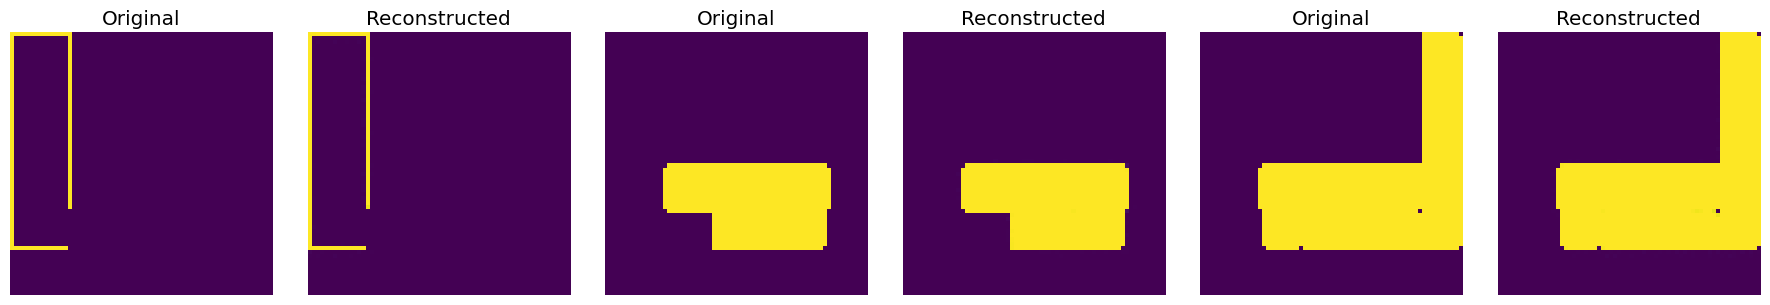

Epoch [43/500] | train_loss: 0.3622 | val_loss: 0.0336 | lr: 0.00015 | early_stop_counter: 1


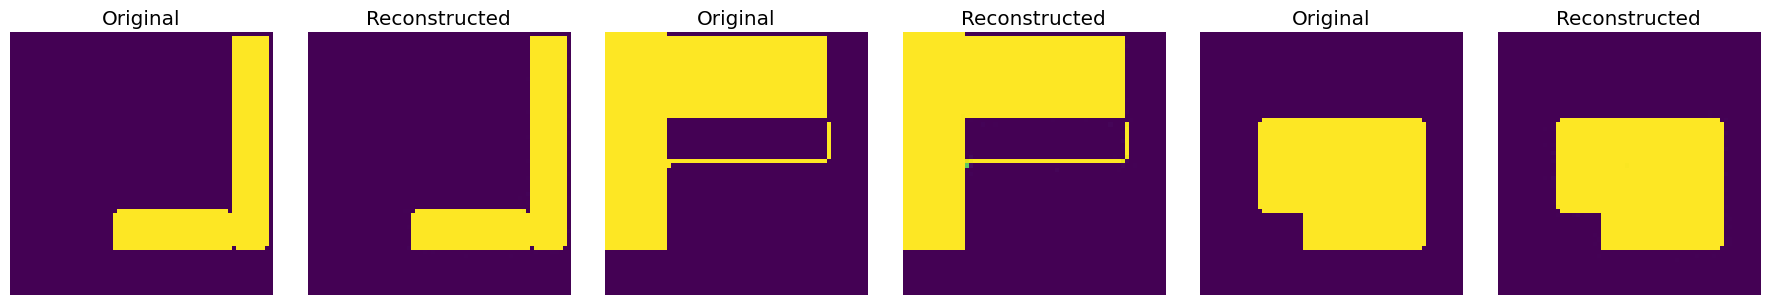

Epoch [44/500] | train_loss: 0.3489 | val_loss: 0.0589 | lr: 0.00015 | early_stop_counter: 0


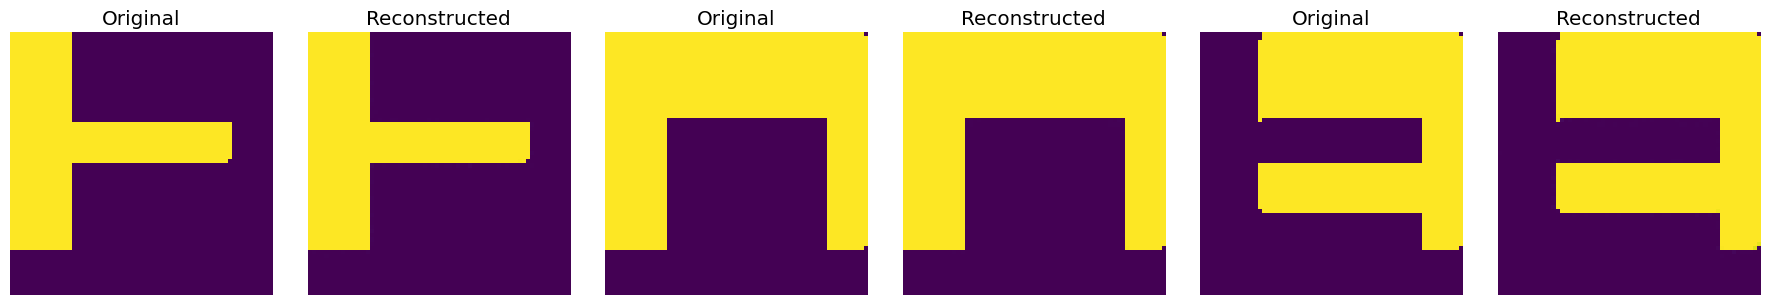

Epoch [45/500] | train_loss: 0.3492 | val_loss: 0.0387 | lr: 0.00015 | early_stop_counter: 1


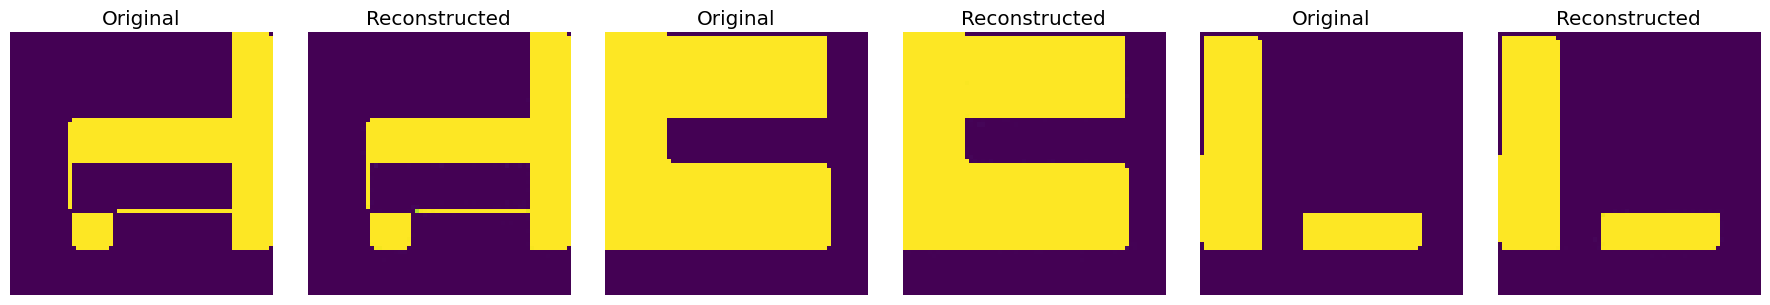

Epoch [46/500] | train_loss: 0.4238 | val_loss: 0.0811 | lr: 0.00015 | early_stop_counter: 2


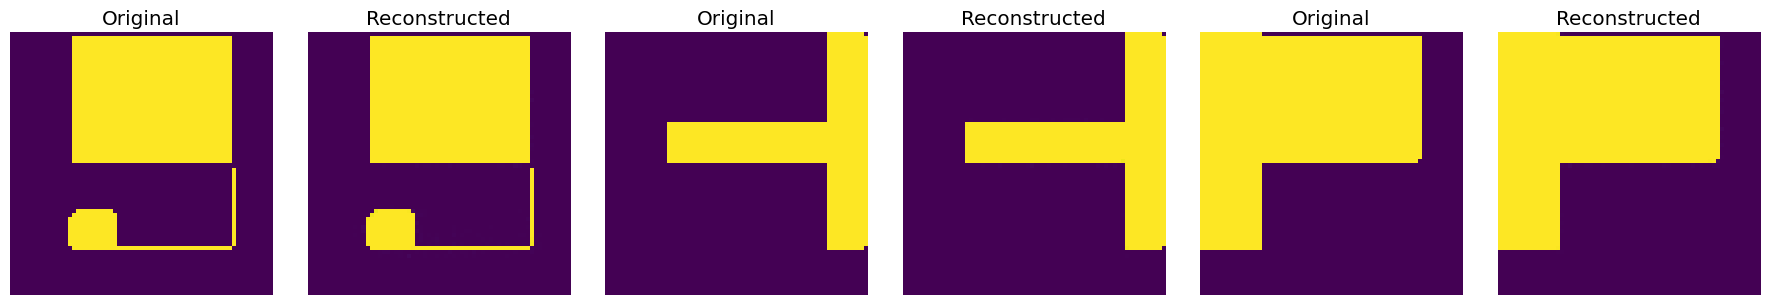

Epoch [47/500] | train_loss: 0.4858 | val_loss: 0.2606 | lr: 0.00015 | early_stop_counter: 3


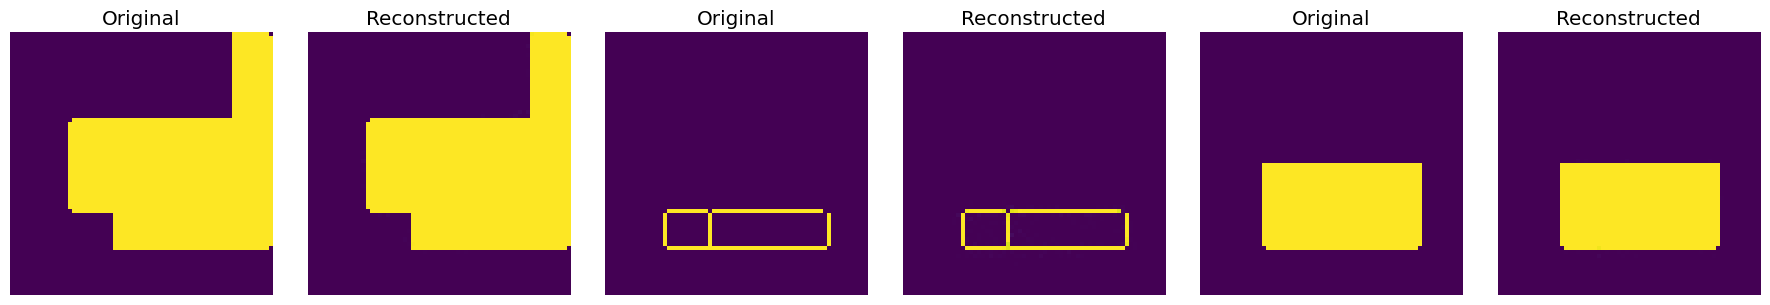

Epoch [48/500] | train_loss: 0.4824 | val_loss: 0.1578 | lr: 0.00015 | early_stop_counter: 4


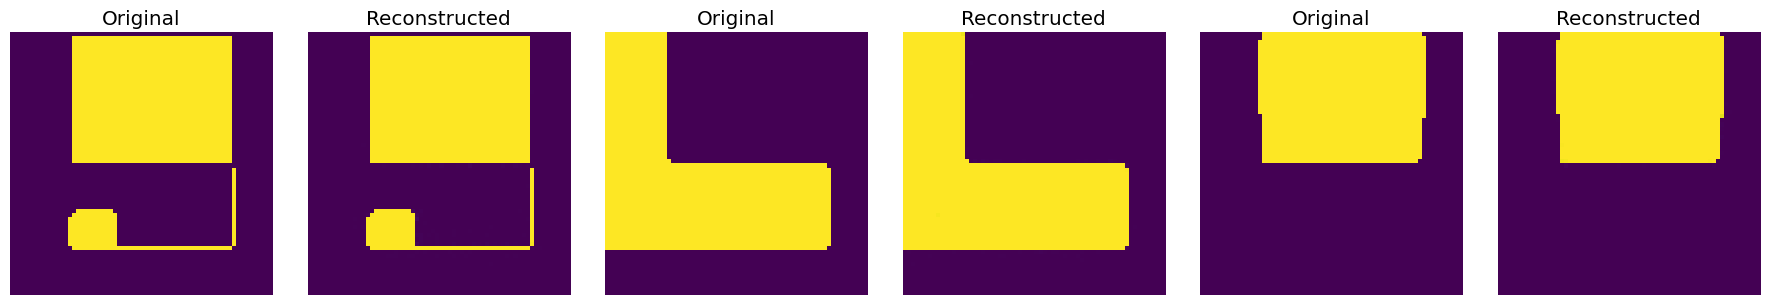

Epoch [49/500] | train_loss: 0.4987 | val_loss: 0.1446 | lr: 0.00015 | early_stop_counter: 5


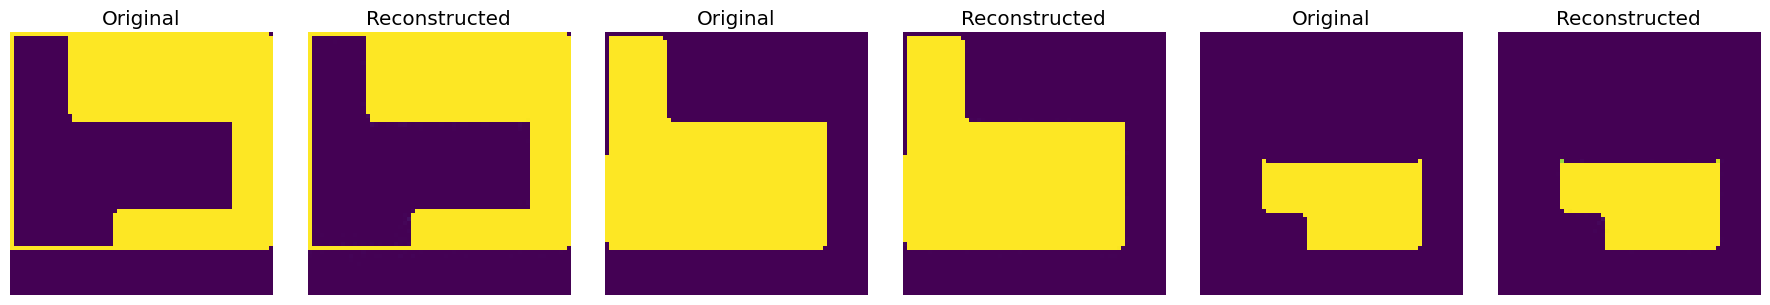

Epoch [50/500] | train_loss: 0.3973 | val_loss: 0.0240 | lr: 7.5e-05 | early_stop_counter: 6


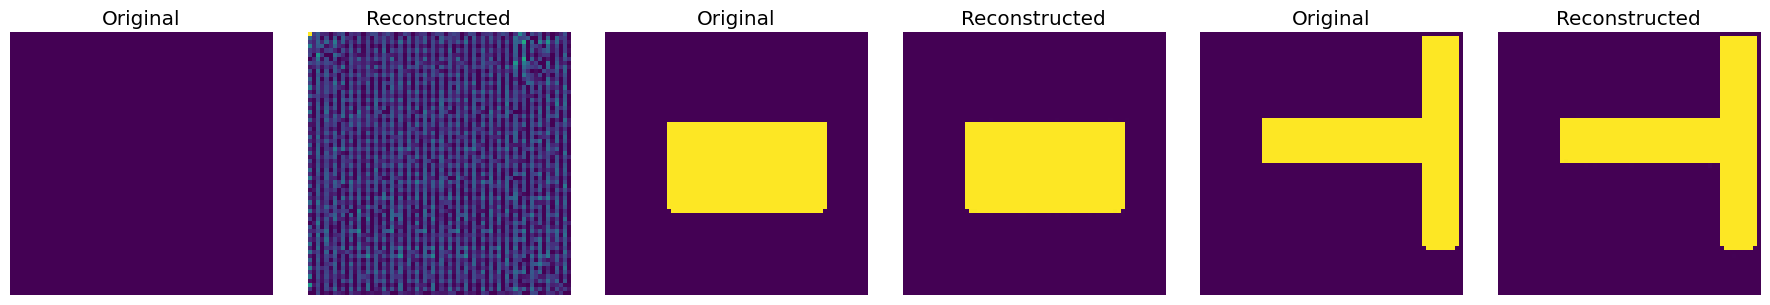

Epoch [51/500] | train_loss: 0.3275 | val_loss: 0.0236 | lr: 7.5e-05 | early_stop_counter: 0


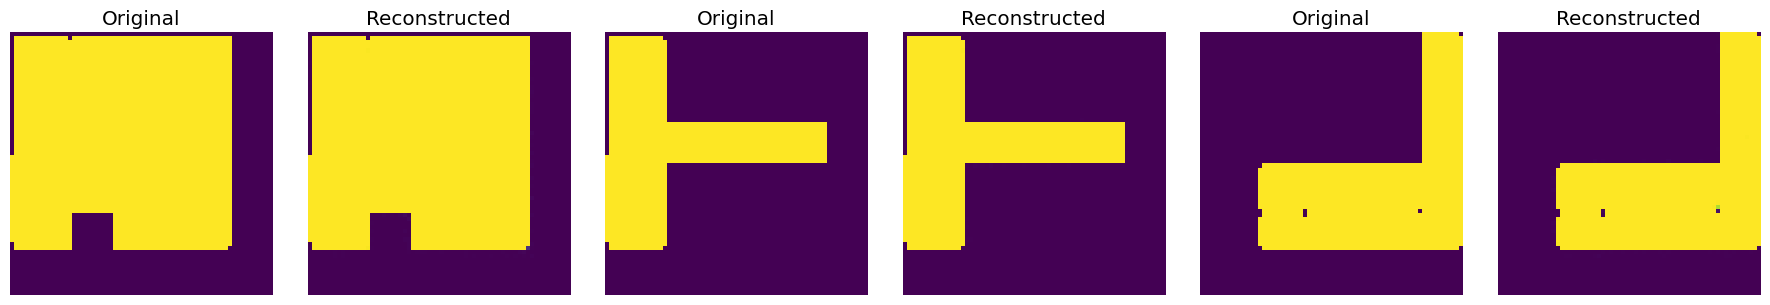

Epoch [52/500] | train_loss: 0.3334 | val_loss: 0.0232 | lr: 7.5e-05 | early_stop_counter: 1


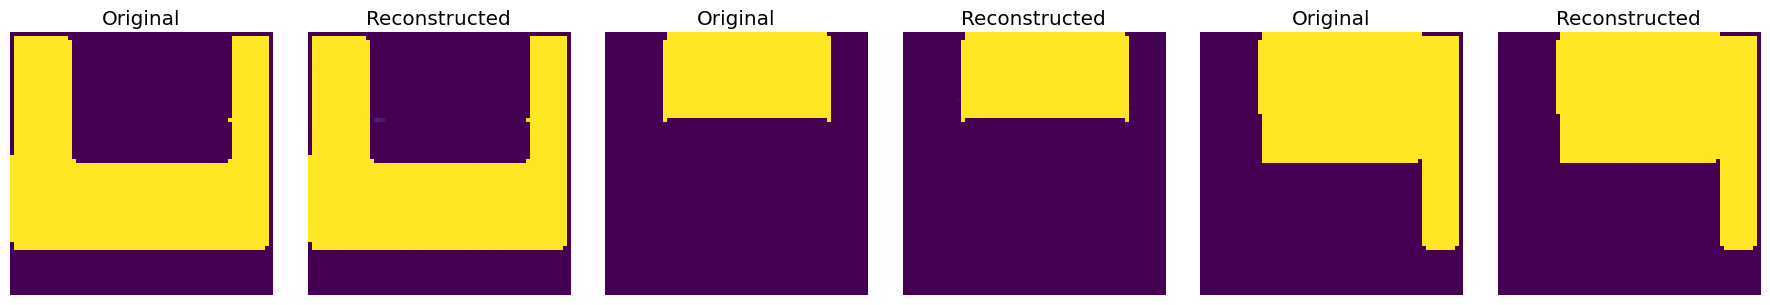

Epoch [53/500] | train_loss: 0.3260 | val_loss: 0.0242 | lr: 7.5e-05 | early_stop_counter: 2


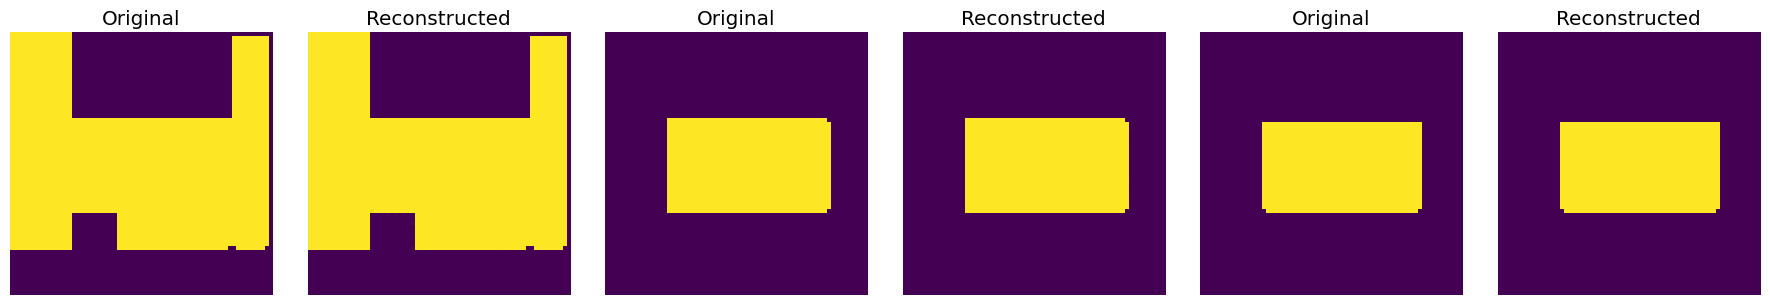

Epoch [54/500] | train_loss: 0.3273 | val_loss: 0.0323 | lr: 7.5e-05 | early_stop_counter: 3


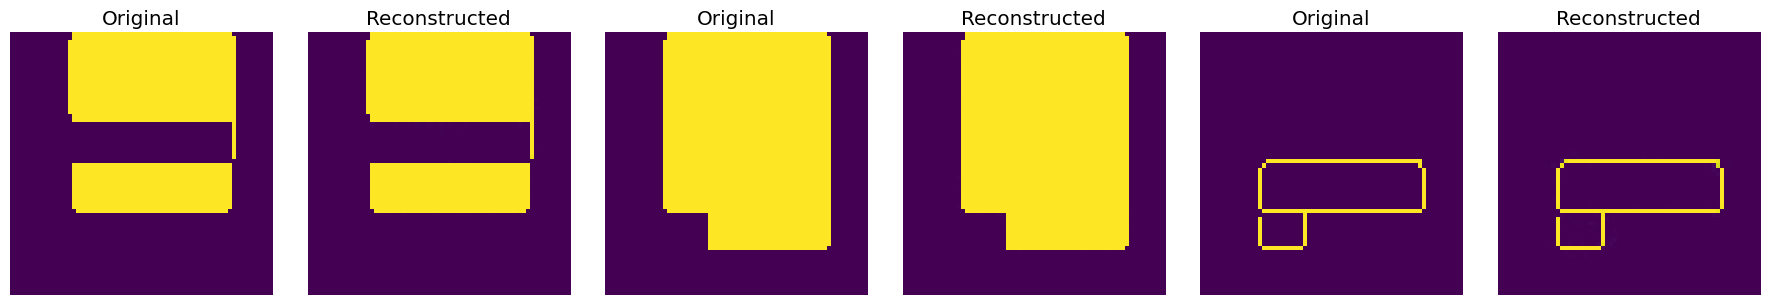

Epoch [55/500] | train_loss: 0.3247 | val_loss: 0.0275 | lr: 7.5e-05 | early_stop_counter: 4


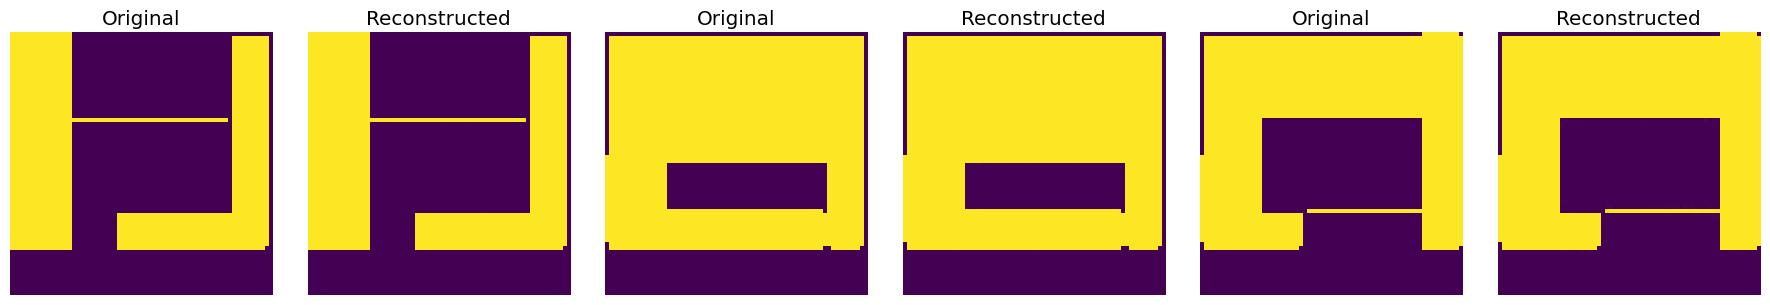

Epoch [56/500] | train_loss: 0.3373 | val_loss: 0.0233 | lr: 7.5e-05 | early_stop_counter: 5


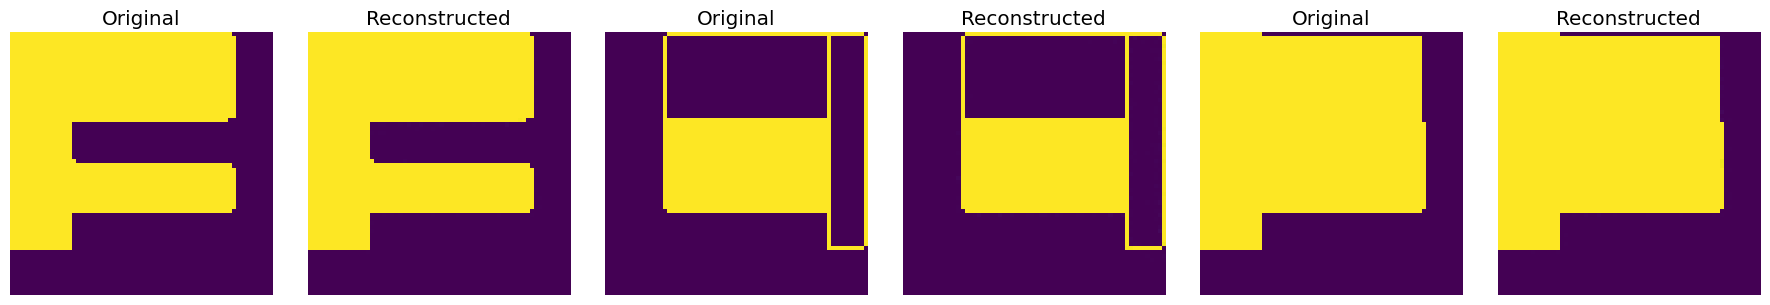

Epoch [57/500] | train_loss: 0.3279 | val_loss: 0.0224 | lr: 7.5e-05 | early_stop_counter: 6


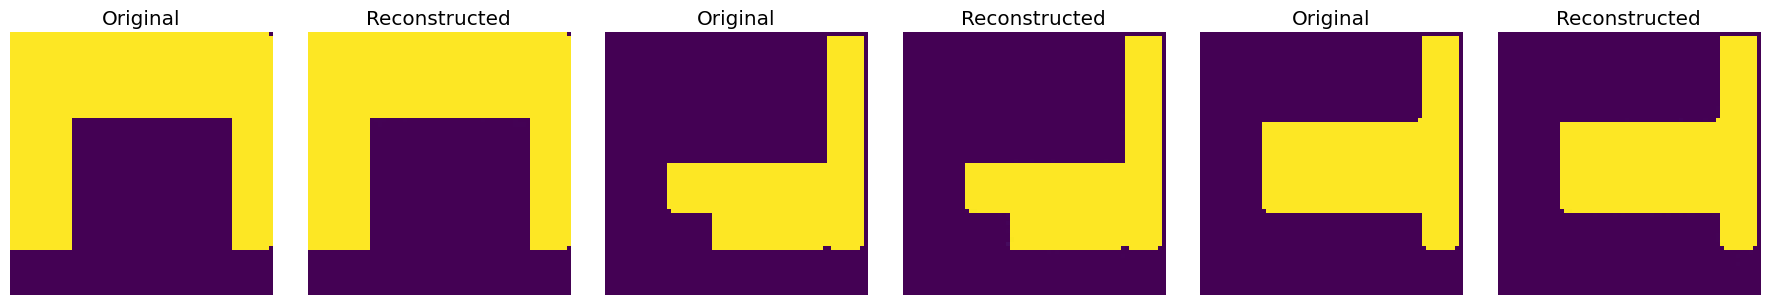

Epoch [58/500] | train_loss: 0.3309 | val_loss: 0.0227 | lr: 7.5e-05 | early_stop_counter: 0


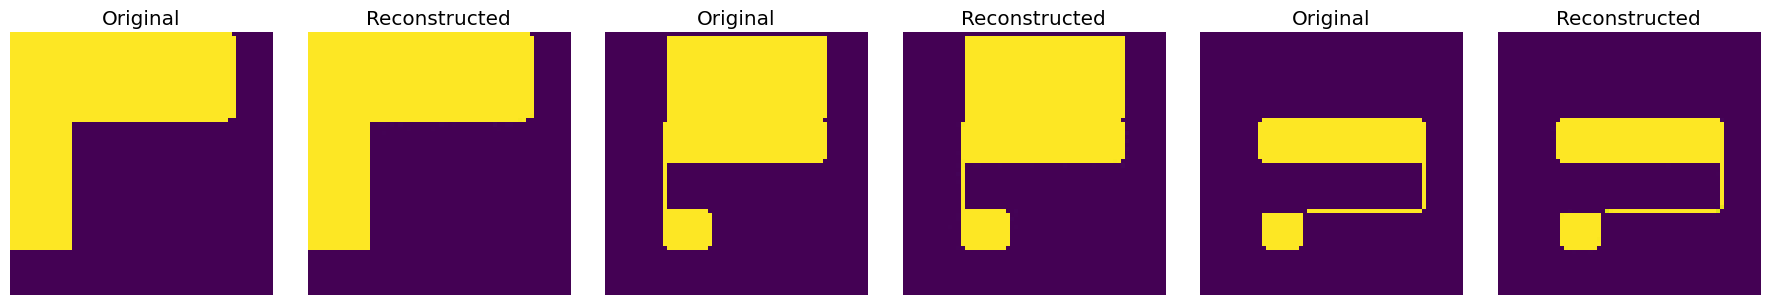

Epoch [59/500] | train_loss: 0.3330 | val_loss: 0.0209 | lr: 7.5e-05 | early_stop_counter: 1


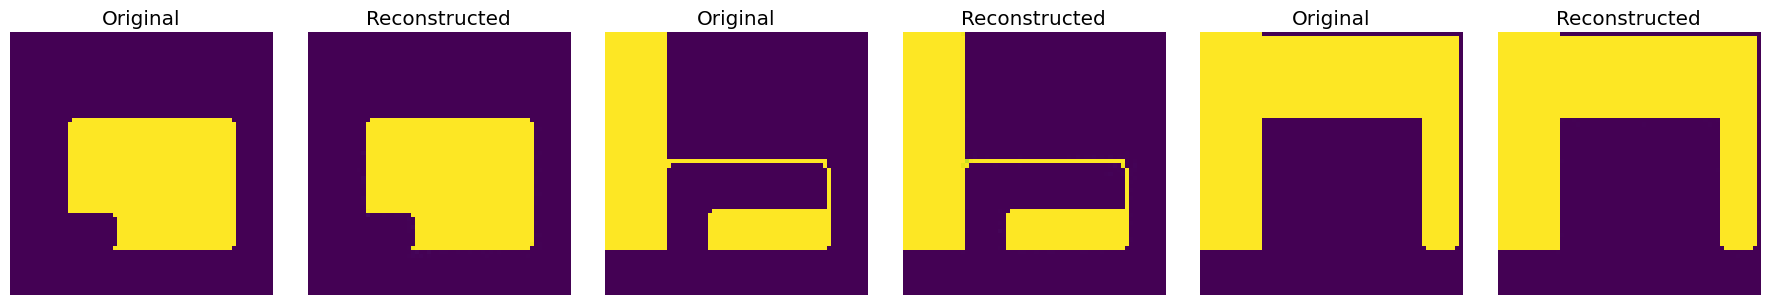

Epoch [60/500] | train_loss: 0.3328 | val_loss: 0.0214 | lr: 7.5e-05 | early_stop_counter: 0


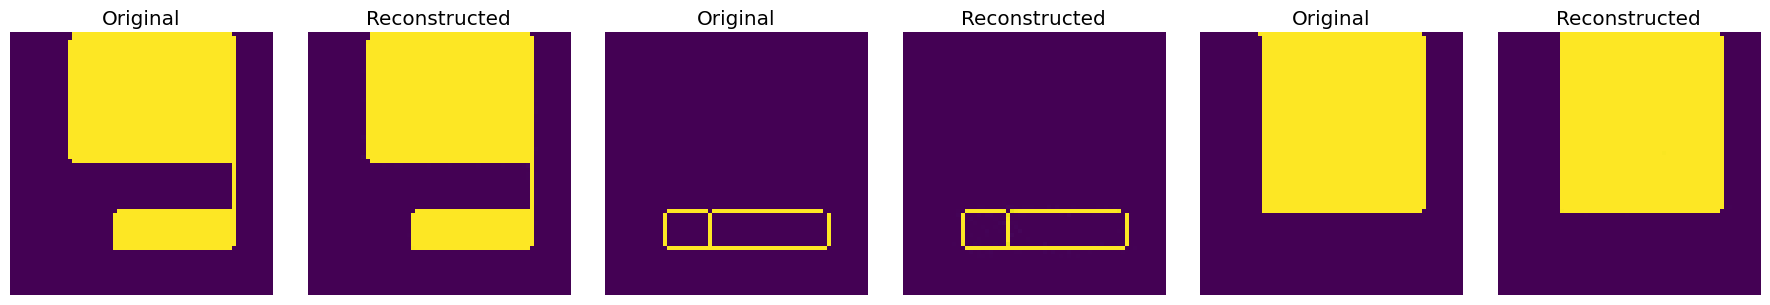

Epoch [61/500] | train_loss: 0.3432 | val_loss: 0.0222 | lr: 7.5e-05 | early_stop_counter: 1


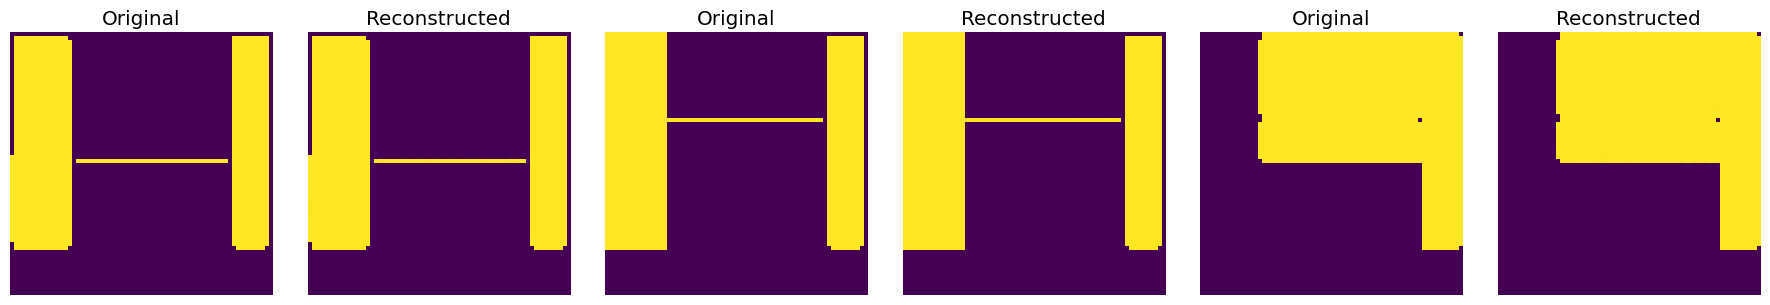

Epoch [62/500] | train_loss: 0.3342 | val_loss: 0.0272 | lr: 7.5e-05 | early_stop_counter: 2


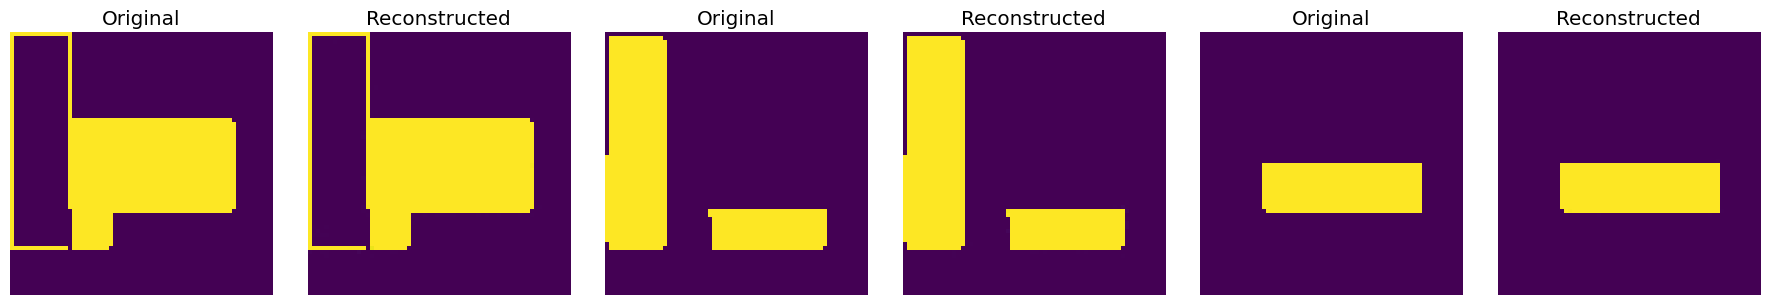

Epoch [63/500] | train_loss: 0.3335 | val_loss: 0.0243 | lr: 7.5e-05 | early_stop_counter: 3


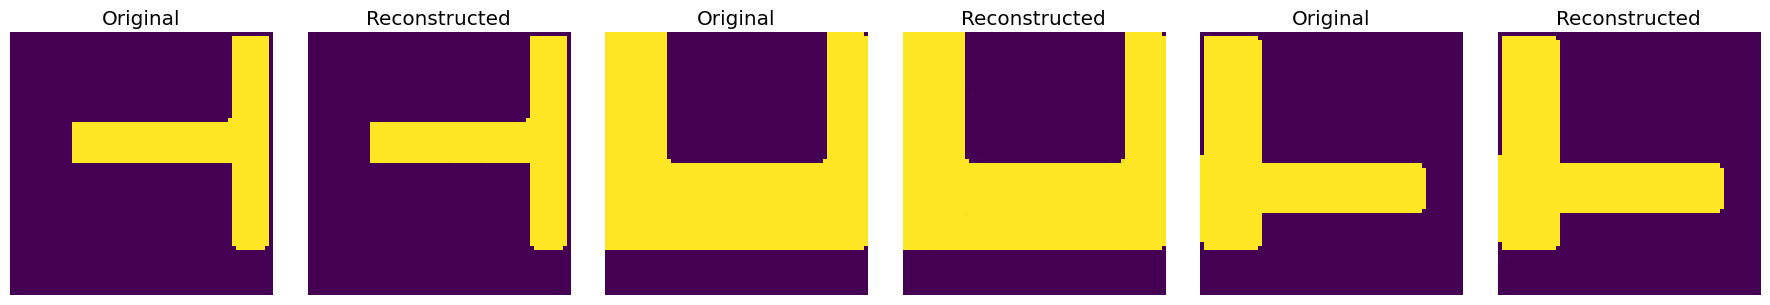

Epoch [64/500] | train_loss: 0.3235 | val_loss: 0.0198 | lr: 7.5e-05 | early_stop_counter: 4


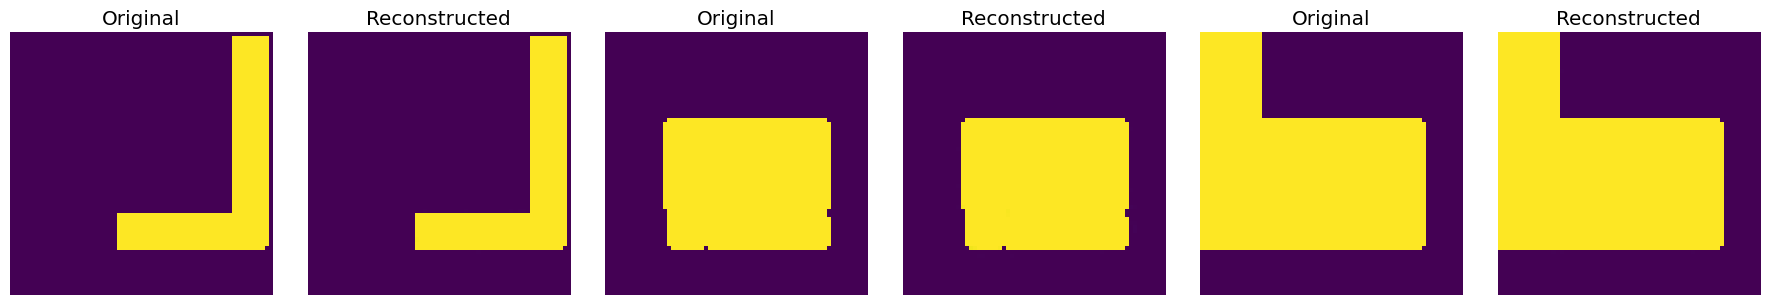

Epoch [65/500] | train_loss: 0.3215 | val_loss: 0.0236 | lr: 7.5e-05 | early_stop_counter: 0


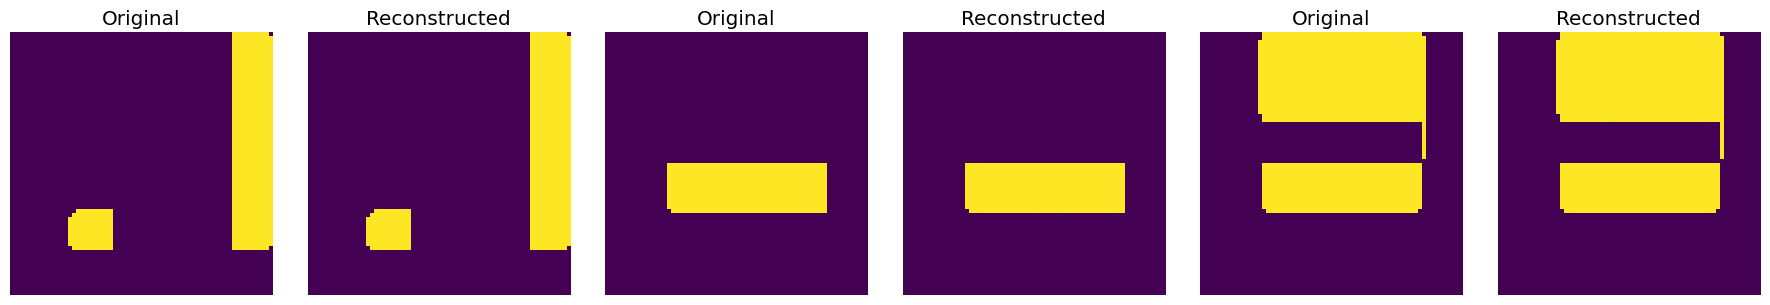

Epoch [66/500] | train_loss: 0.3308 | val_loss: 0.0179 | lr: 7.5e-05 | early_stop_counter: 1


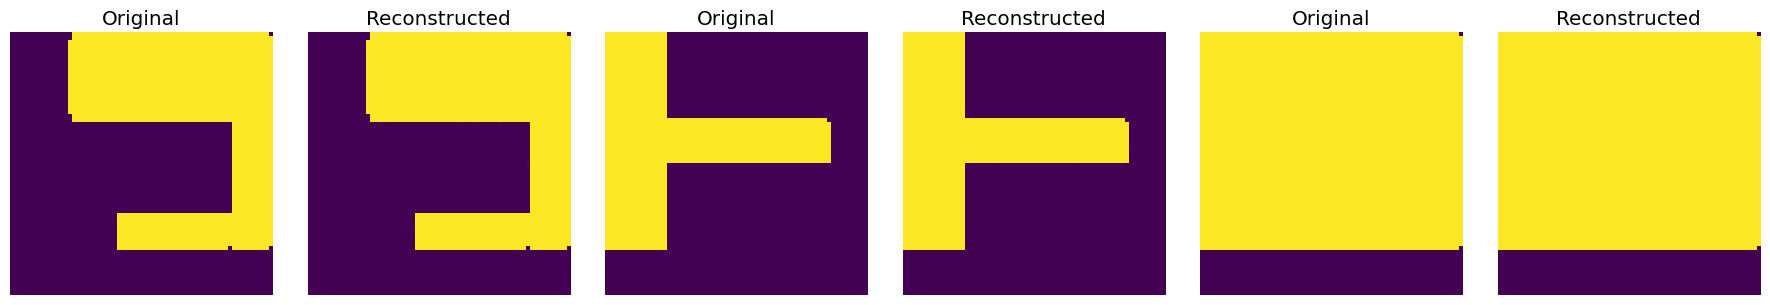

Epoch [67/500] | train_loss: 0.3215 | val_loss: 0.0210 | lr: 7.5e-05 | early_stop_counter: 0


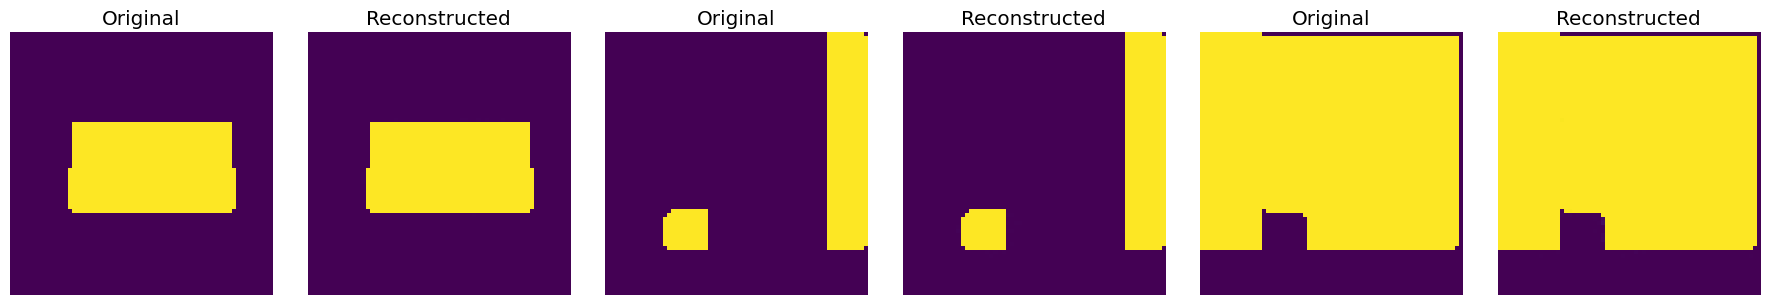

Epoch [68/500] | train_loss: 0.3195 | val_loss: 0.0168 | lr: 7.5e-05 | early_stop_counter: 1


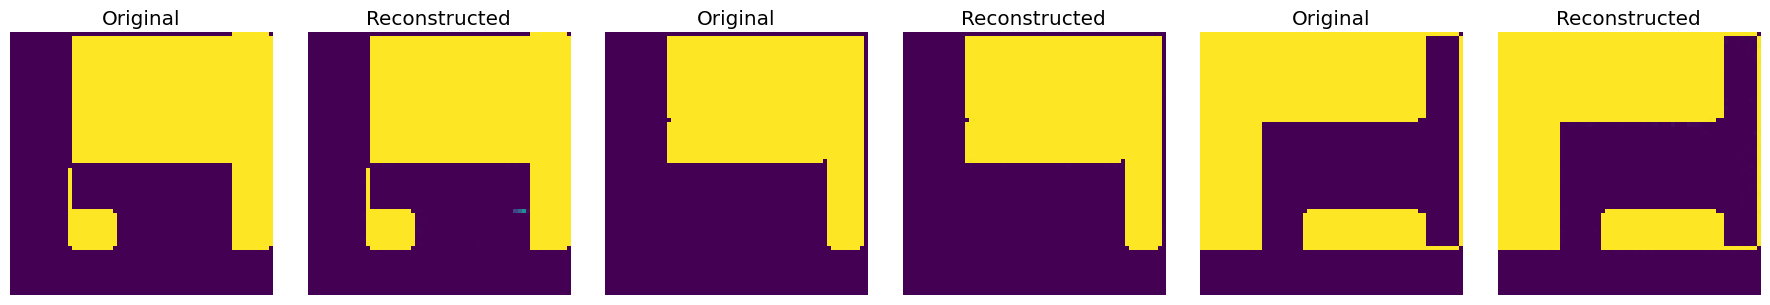

Epoch [69/500] | train_loss: 0.3379 | val_loss: 0.0318 | lr: 7.5e-05 | early_stop_counter: 0


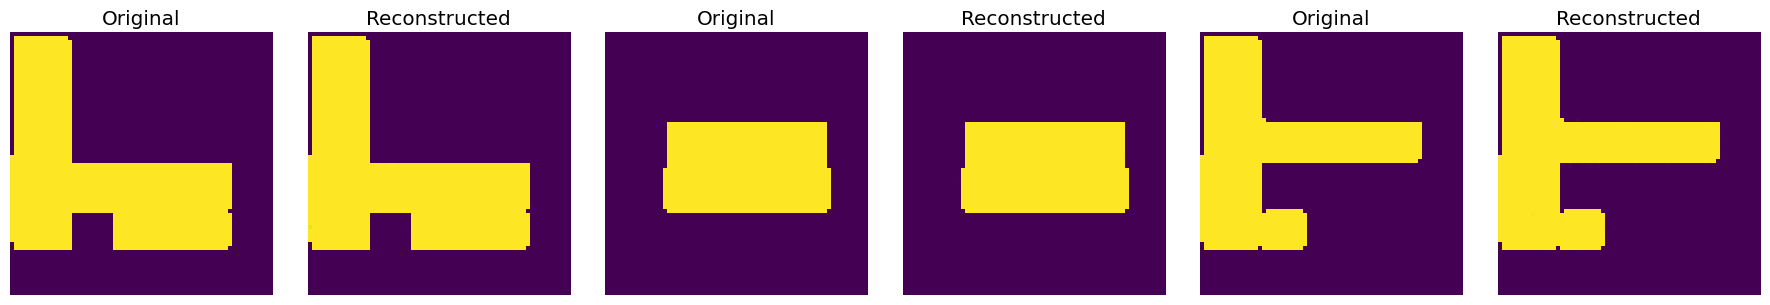

Epoch [70/500] | train_loss: 0.3510 | val_loss: 0.0165 | lr: 7.5e-05 | early_stop_counter: 1


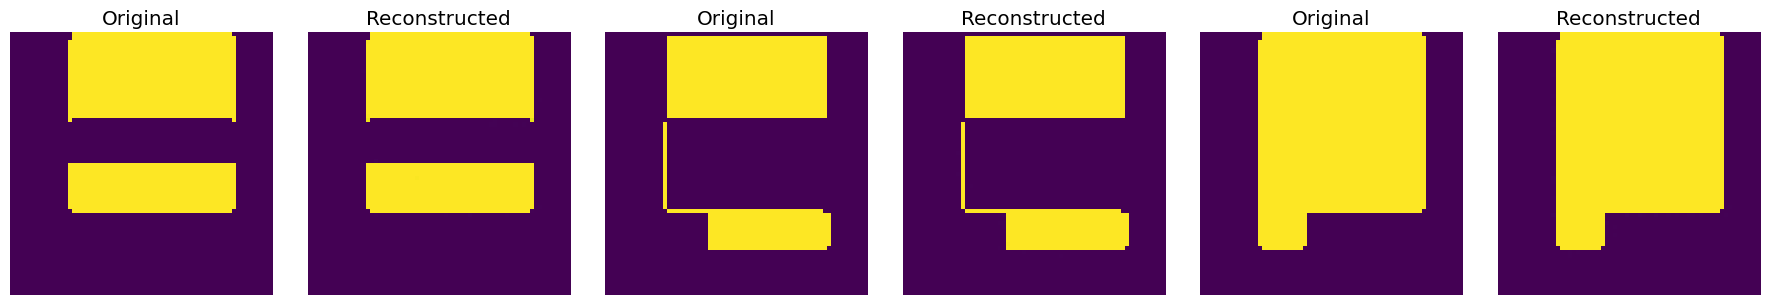

Epoch [71/500] | train_loss: 0.3253 | val_loss: 0.0176 | lr: 7.5e-05 | early_stop_counter: 2


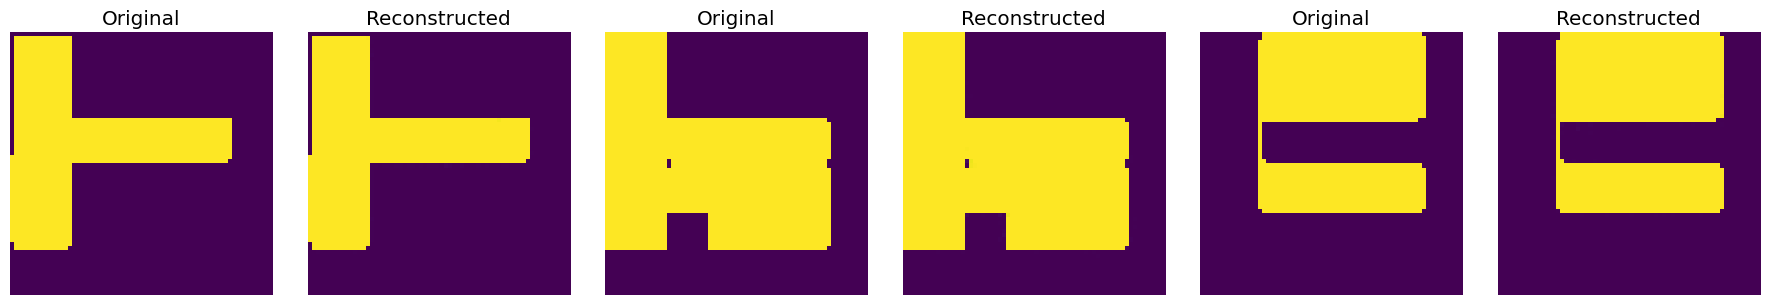

Epoch [72/500] | train_loss: 0.3143 | val_loss: 0.0165 | lr: 7.5e-05 | early_stop_counter: 3


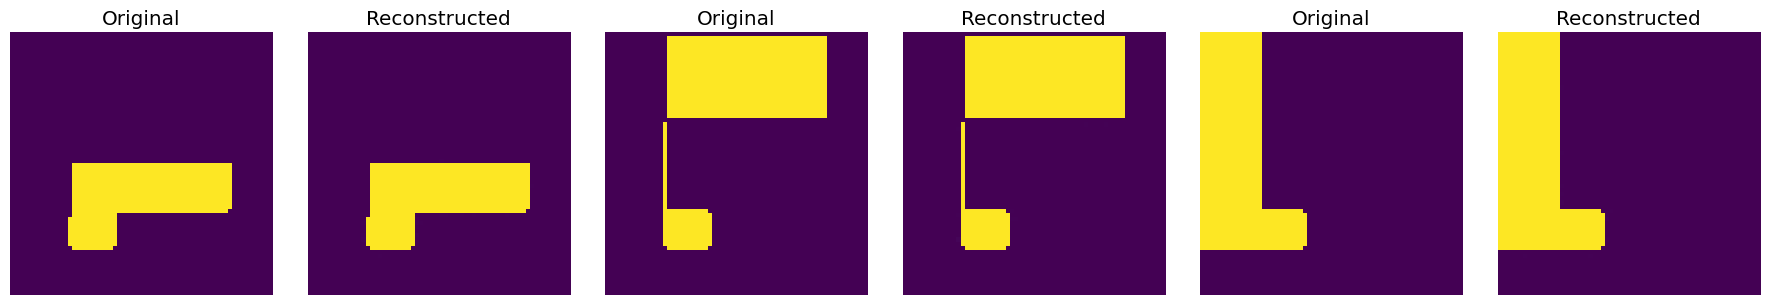

Epoch [73/500] | train_loss: 0.3468 | val_loss: 0.0307 | lr: 7.5e-05 | early_stop_counter: 4


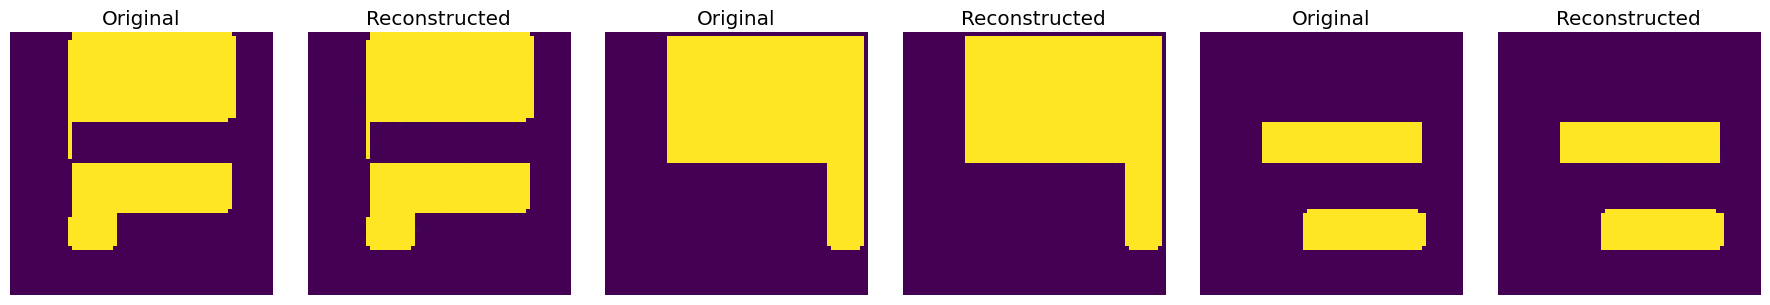

Epoch [74/500] | train_loss: 0.3359 | val_loss: 0.0196 | lr: 7.5e-05 | early_stop_counter: 5


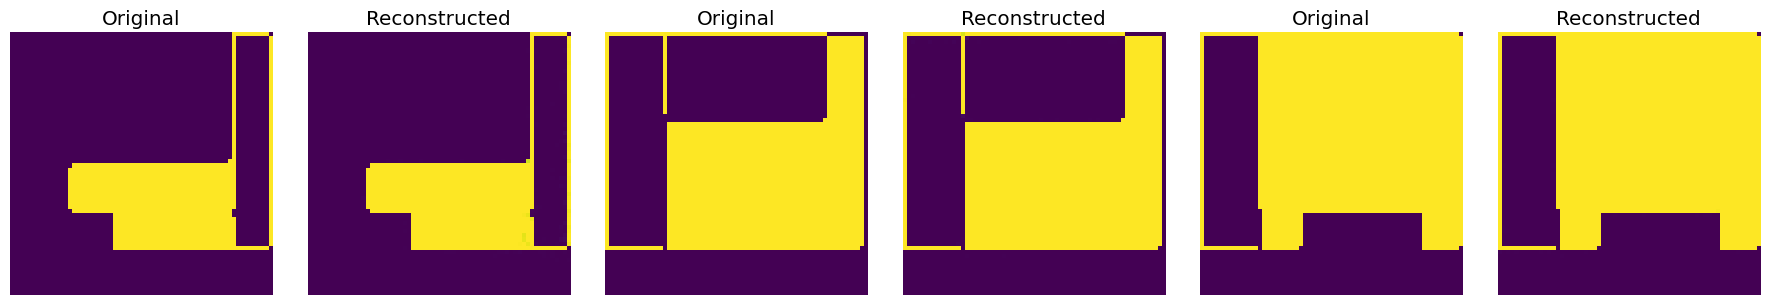

Epoch [75/500] | train_loss: 0.3214 | val_loss: 0.0199 | lr: 7.5e-05 | early_stop_counter: 6


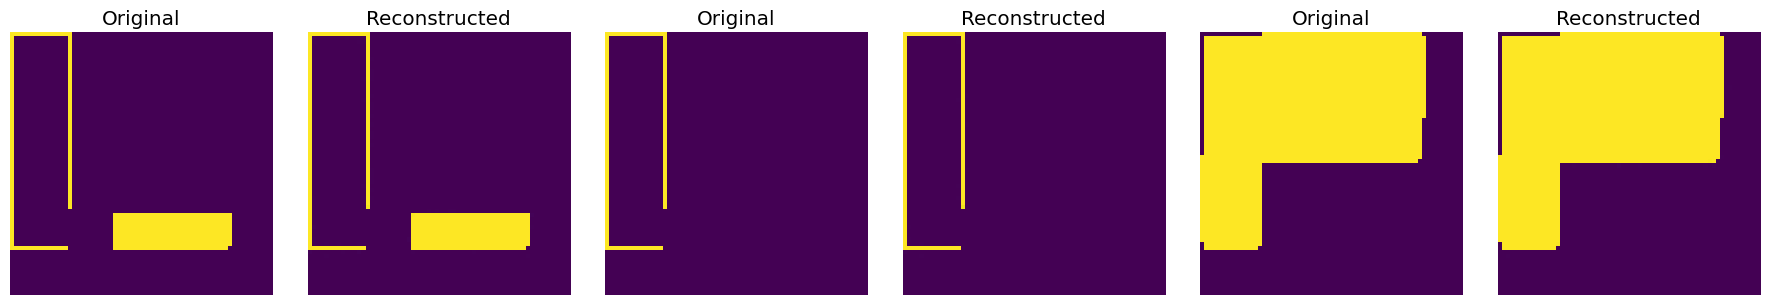

Epoch [76/500] | train_loss: 0.3240 | val_loss: 0.0172 | lr: 7.5e-05 | early_stop_counter: 7


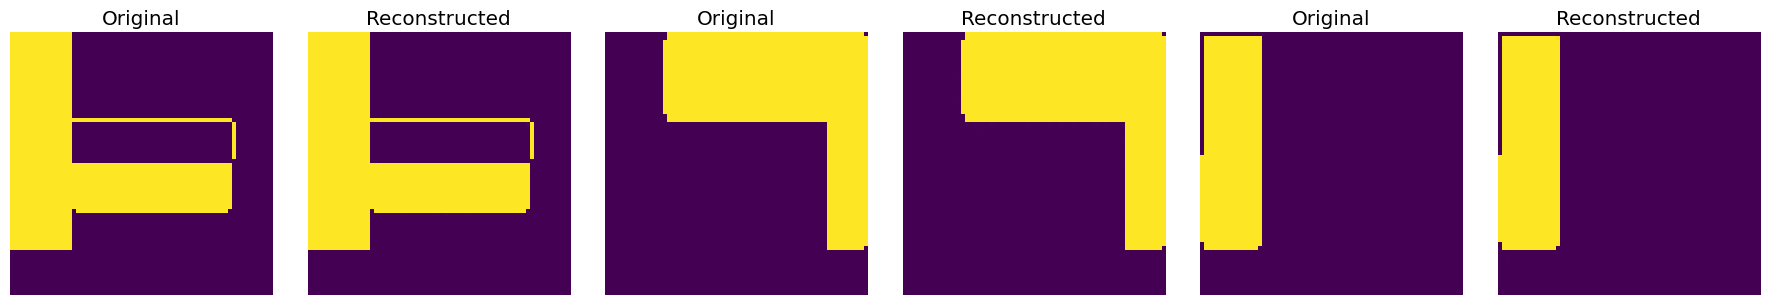

Epoch [77/500] | train_loss: 0.3201 | val_loss: 0.0206 | lr: 7.5e-05 | early_stop_counter: 8


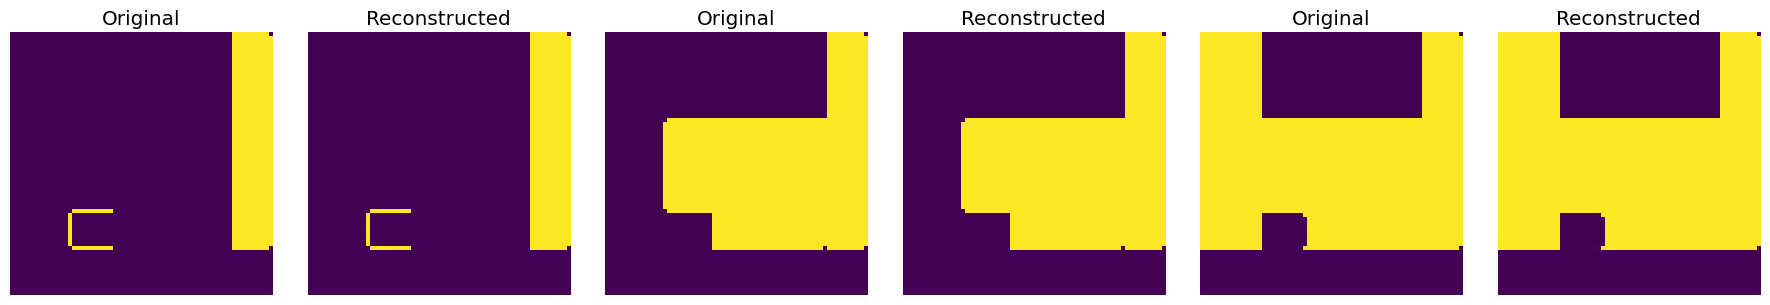

Epoch [78/500] | train_loss: 0.3216 | val_loss: 0.0167 | lr: 7.5e-05 | early_stop_counter: 9


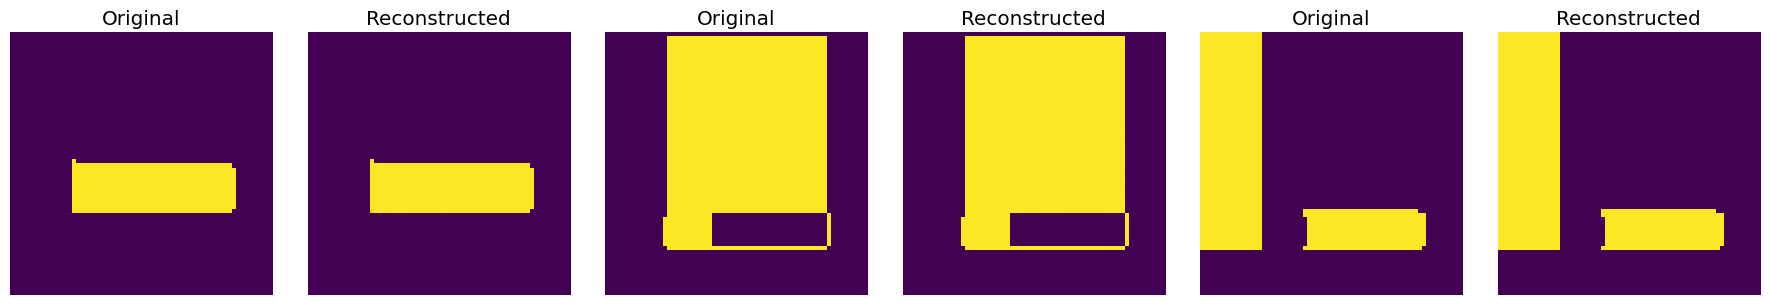

Epoch [79/500] | train_loss: 0.3219 | val_loss: 0.0151 | lr: 3.75e-05 | early_stop_counter: 10


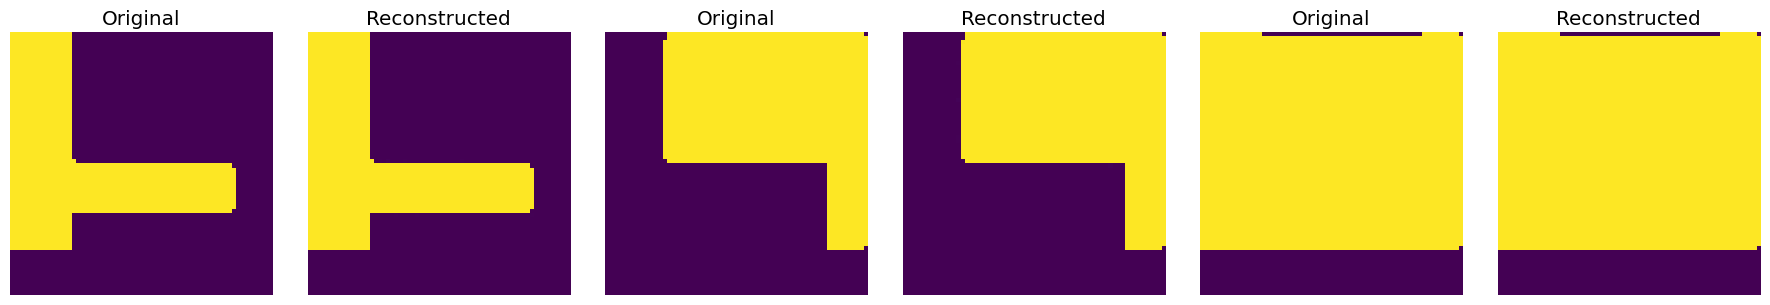

Epoch [80/500] | train_loss: 0.3206 | val_loss: 0.0147 | lr: 3.75e-05 | early_stop_counter: 0


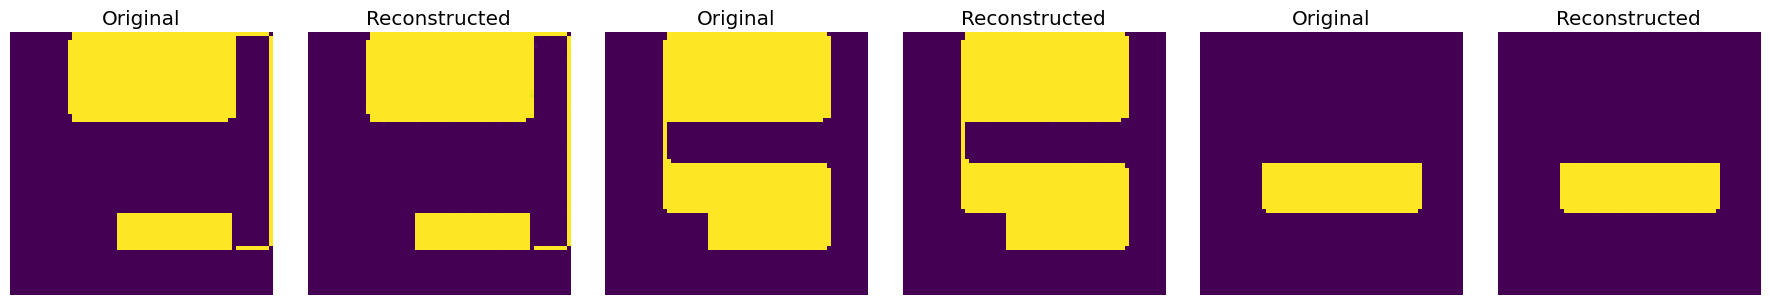

Epoch [81/500] | train_loss: 0.3205 | val_loss: 0.0144 | lr: 3.75e-05 | early_stop_counter: 1


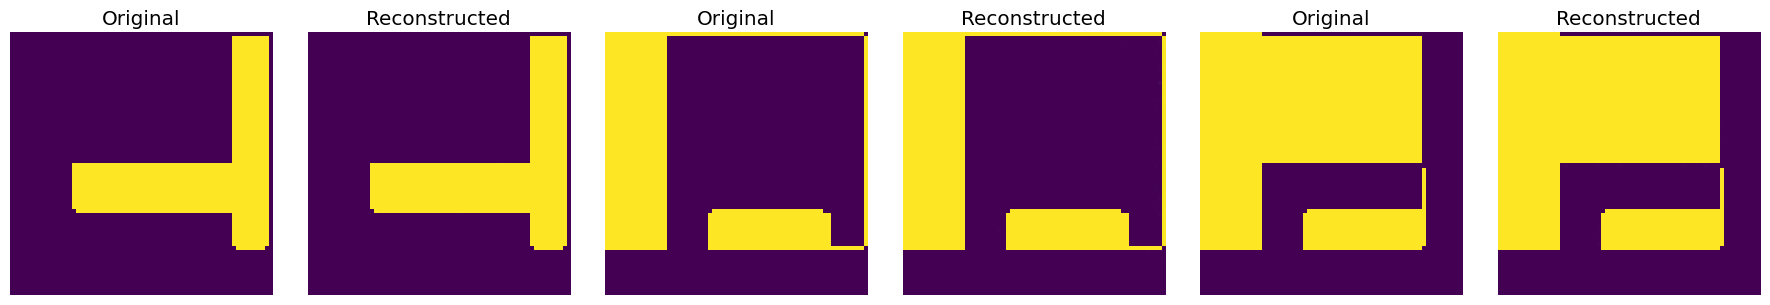

Epoch [82/500] | train_loss: 0.3186 | val_loss: 0.0144 | lr: 3.75e-05 | early_stop_counter: 2


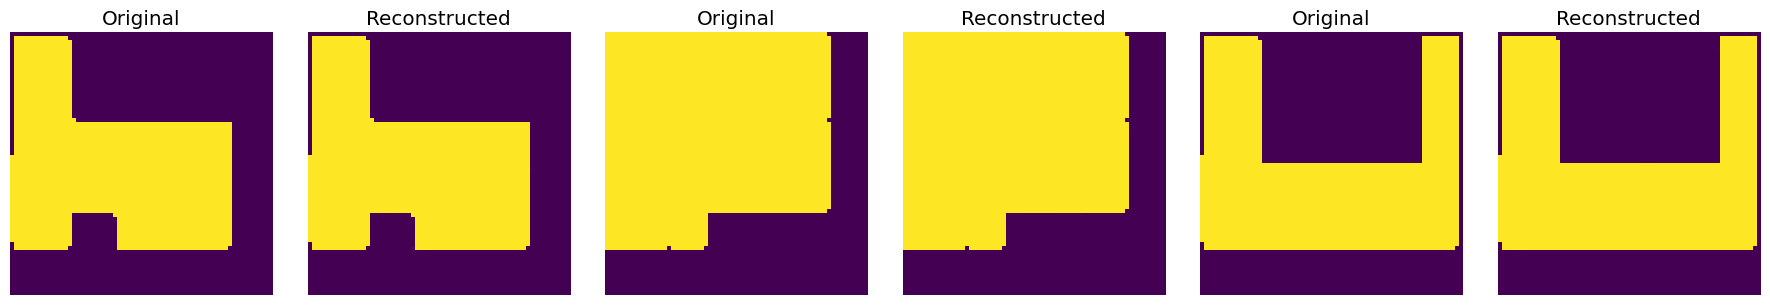

Epoch [83/500] | train_loss: 0.3203 | val_loss: 0.0144 | lr: 3.75e-05 | early_stop_counter: 3


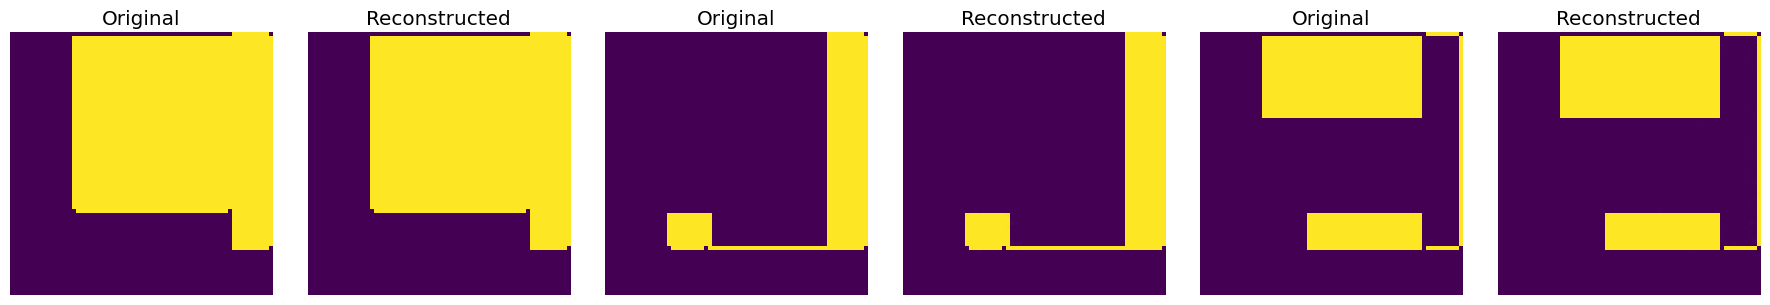

Epoch [84/500] | train_loss: 0.3168 | val_loss: 0.0144 | lr: 3.75e-05 | early_stop_counter: 4


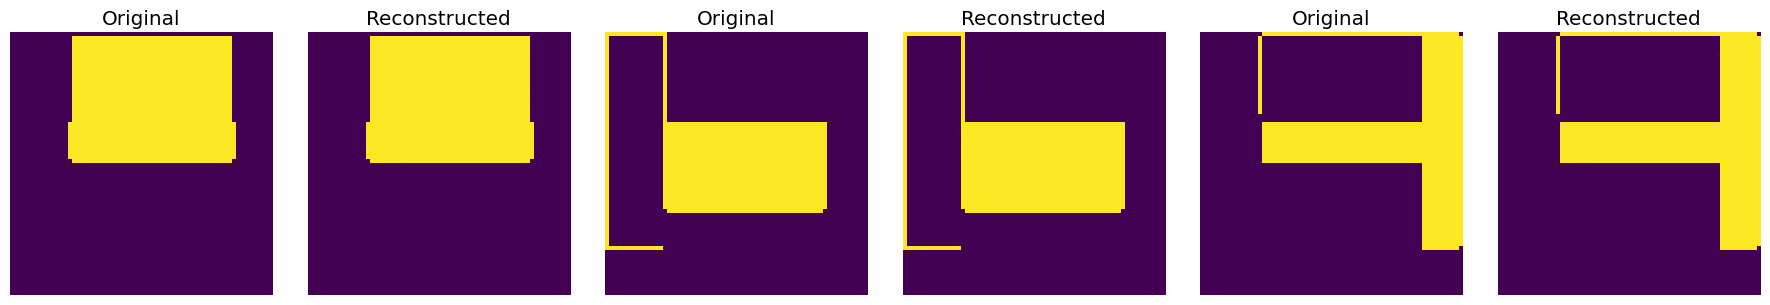

Epoch [85/500] | train_loss: 0.3162 | val_loss: 0.0262 | lr: 3.75e-05 | early_stop_counter: 5


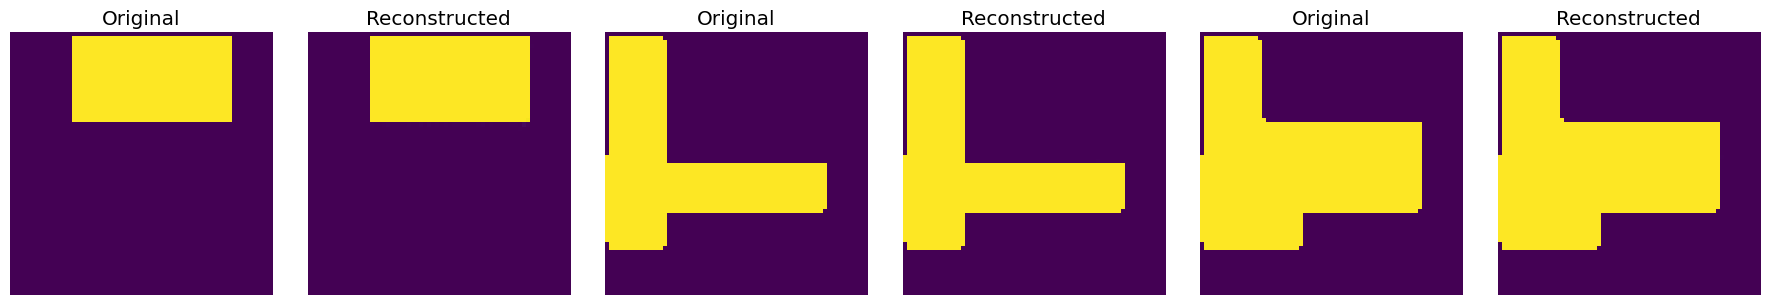

Epoch [86/500] | train_loss: 0.3480 | val_loss: 0.0280 | lr: 3.75e-05 | early_stop_counter: 6


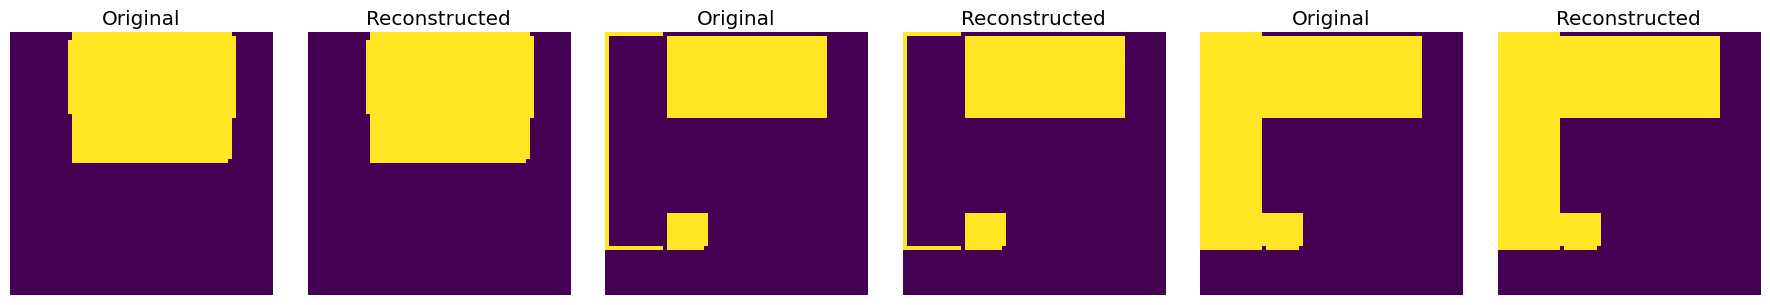

Epoch [87/500] | train_loss: 0.3260 | val_loss: 0.0156 | lr: 3.75e-05 | early_stop_counter: 7


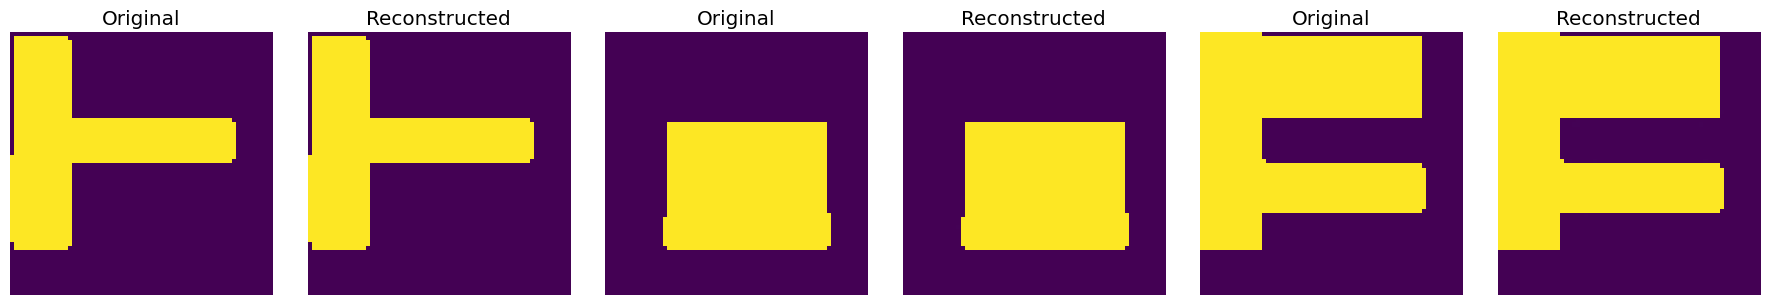

Epoch [88/500] | train_loss: 0.3136 | val_loss: 0.0135 | lr: 3.75e-05 | early_stop_counter: 8


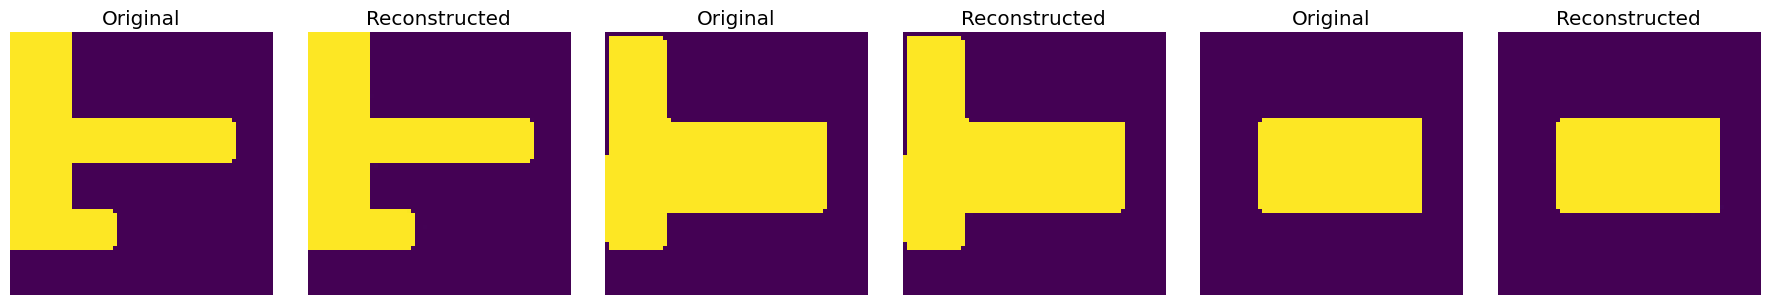

Epoch [89/500] | train_loss: 0.3149 | val_loss: 0.0138 | lr: 3.75e-05 | early_stop_counter: 0


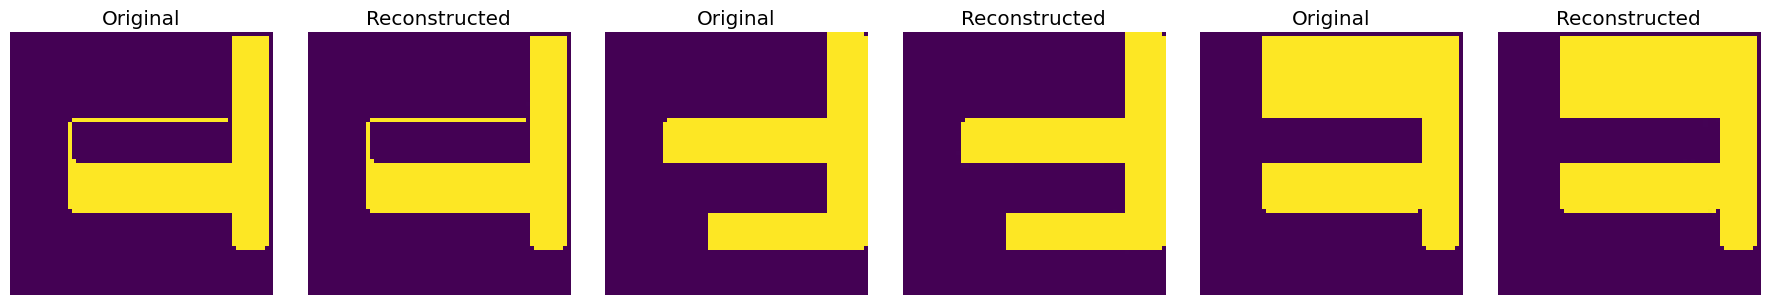

Epoch [90/500] | train_loss: 0.3140 | val_loss: 0.0160 | lr: 3.75e-05 | early_stop_counter: 1


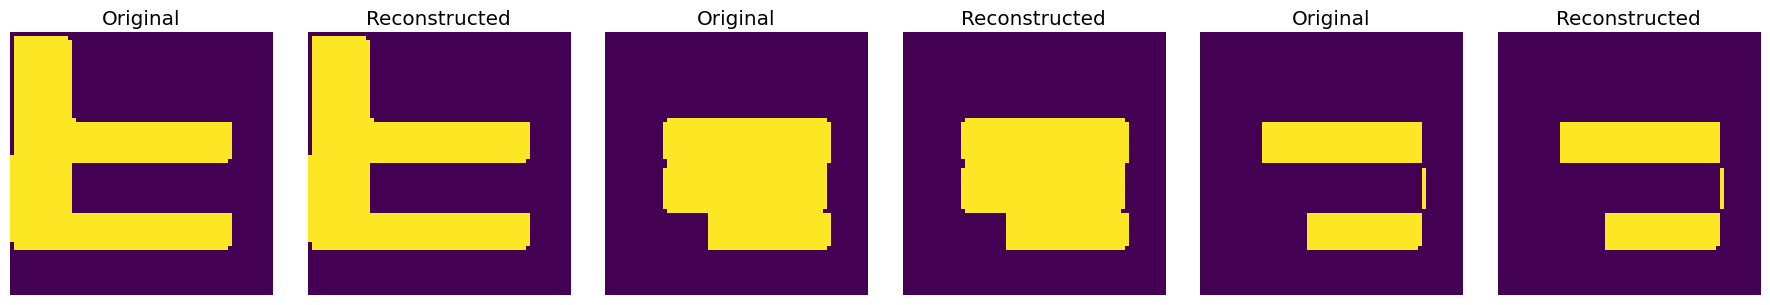

Epoch [91/500] | train_loss: 0.3330 | val_loss: 0.0379 | lr: 3.75e-05 | early_stop_counter: 2


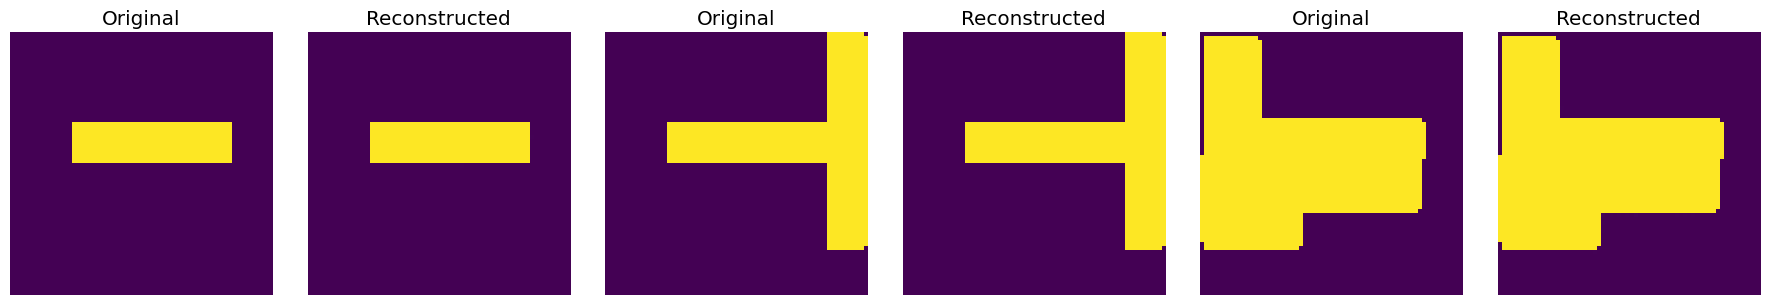

Epoch [92/500] | train_loss: 0.3324 | val_loss: 0.0260 | lr: 3.75e-05 | early_stop_counter: 3


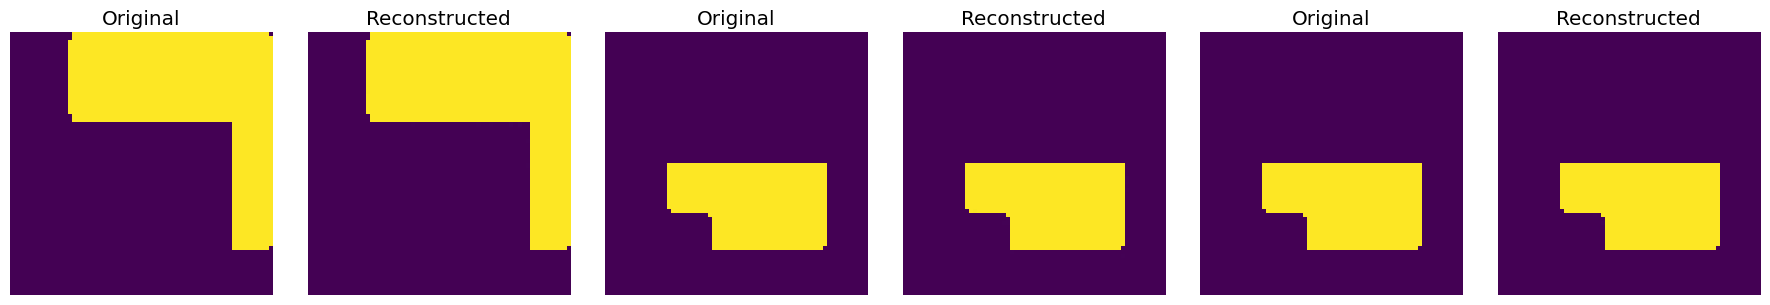

Epoch [93/500] | train_loss: 0.3290 | val_loss: 0.0178 | lr: 3.75e-05 | early_stop_counter: 4


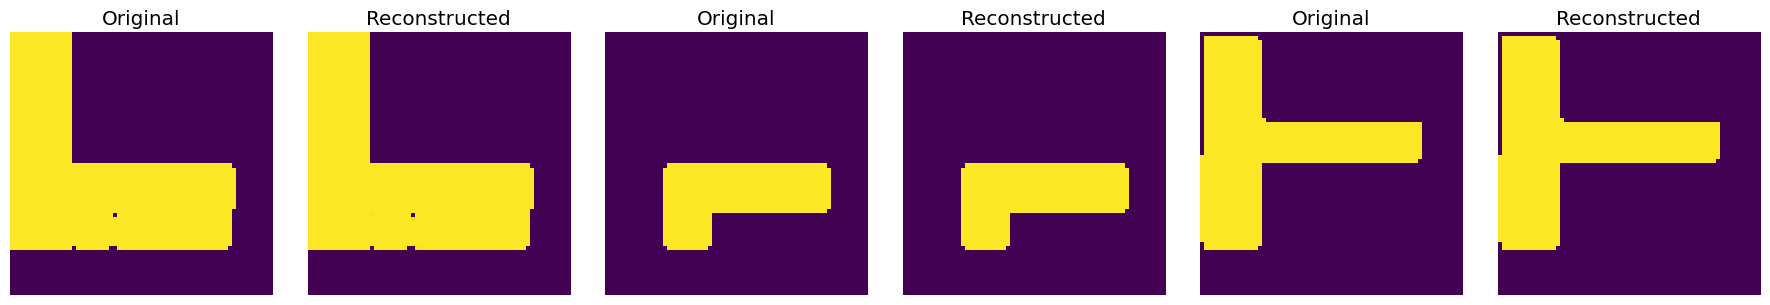

Epoch [94/500] | train_loss: 0.3072 | val_loss: 0.0148 | lr: 3.75e-05 | early_stop_counter: 5


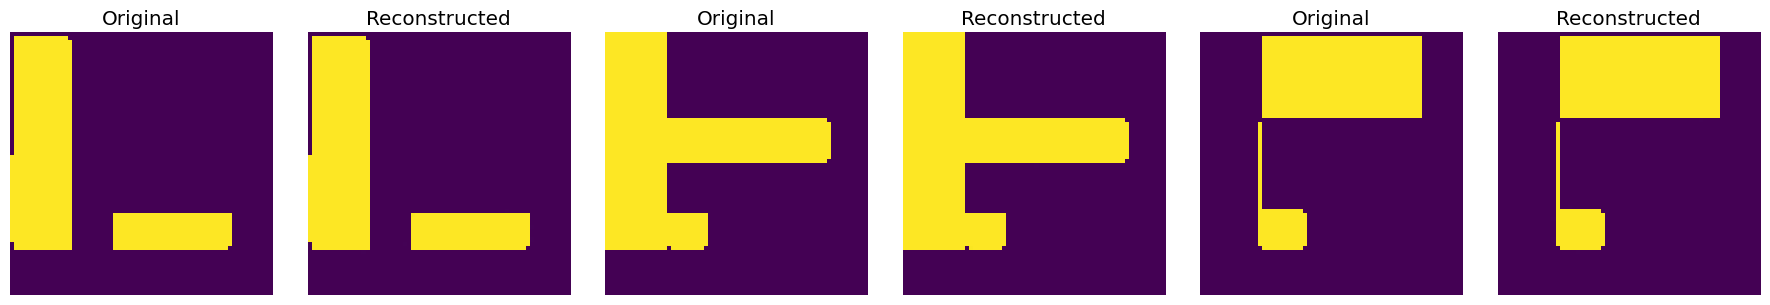

Epoch [95/500] | train_loss: 0.3078 | val_loss: 0.0144 | lr: 1.875e-05 | early_stop_counter: 6


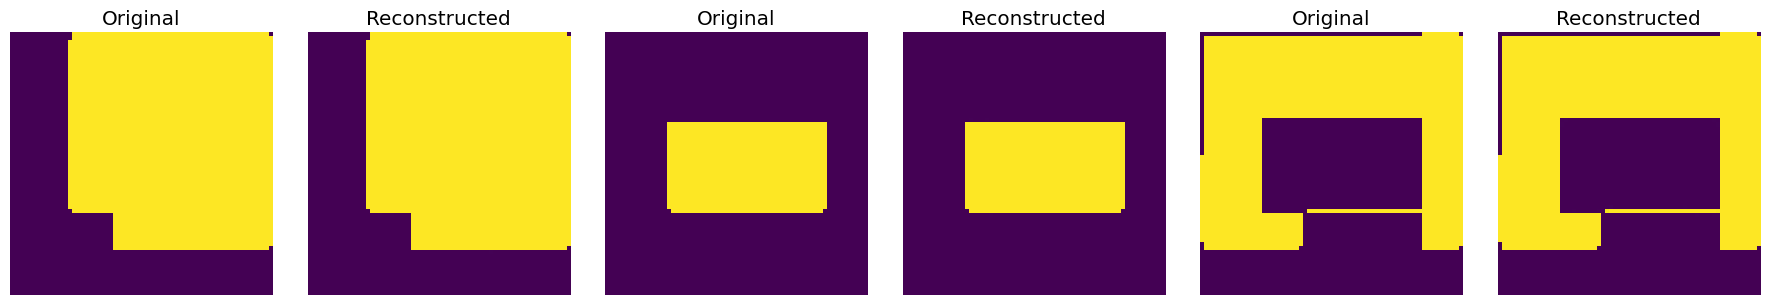

Epoch [96/500] | train_loss: 0.3162 | val_loss: 0.0242 | lr: 1.875e-05 | early_stop_counter: 7


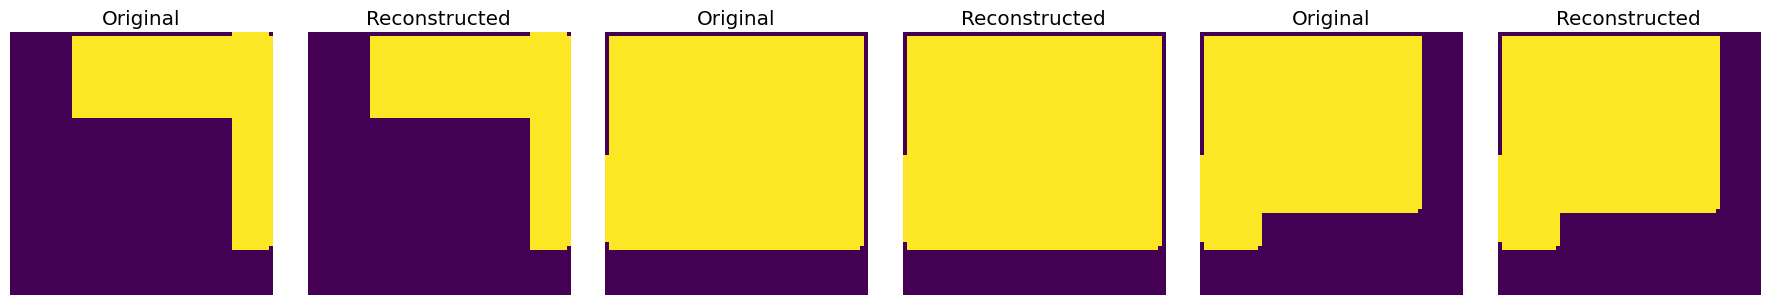

Epoch [97/500] | train_loss: 0.3364 | val_loss: 0.0268 | lr: 1.875e-05 | early_stop_counter: 8


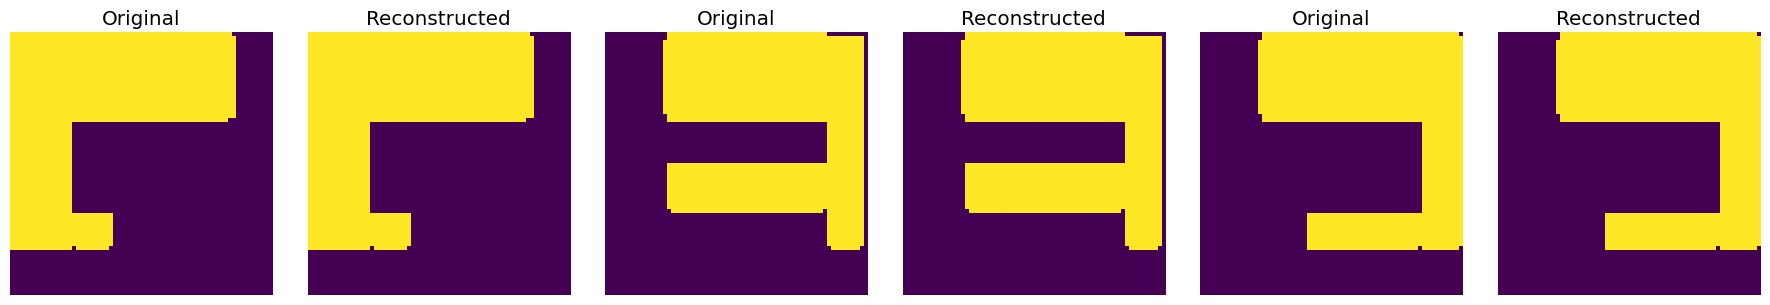

Epoch [98/500] | train_loss: 0.3348 | val_loss: 0.0244 | lr: 1.875e-05 | early_stop_counter: 9


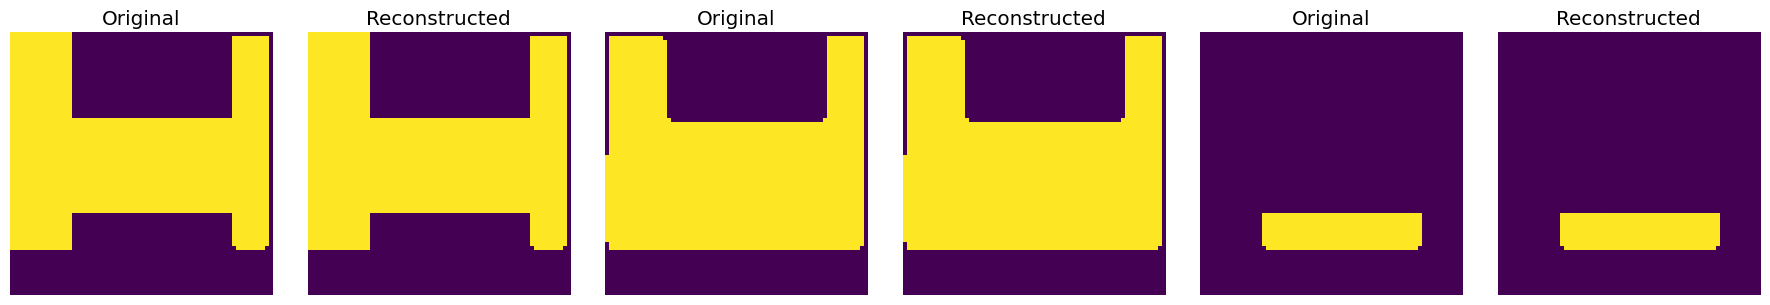

Epoch [99/500] | train_loss: 0.3320 | val_loss: 0.0252 | lr: 1.875e-05 | early_stop_counter: 10


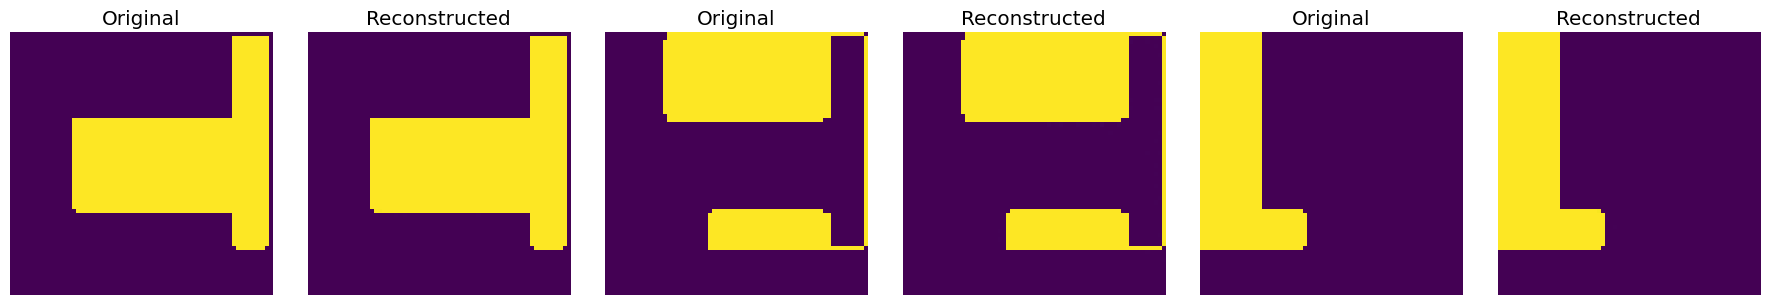

Epoch [100/500] | train_loss: 0.3343 | val_loss: 0.0249 | lr: 1.875e-05 | early_stop_counter: 11


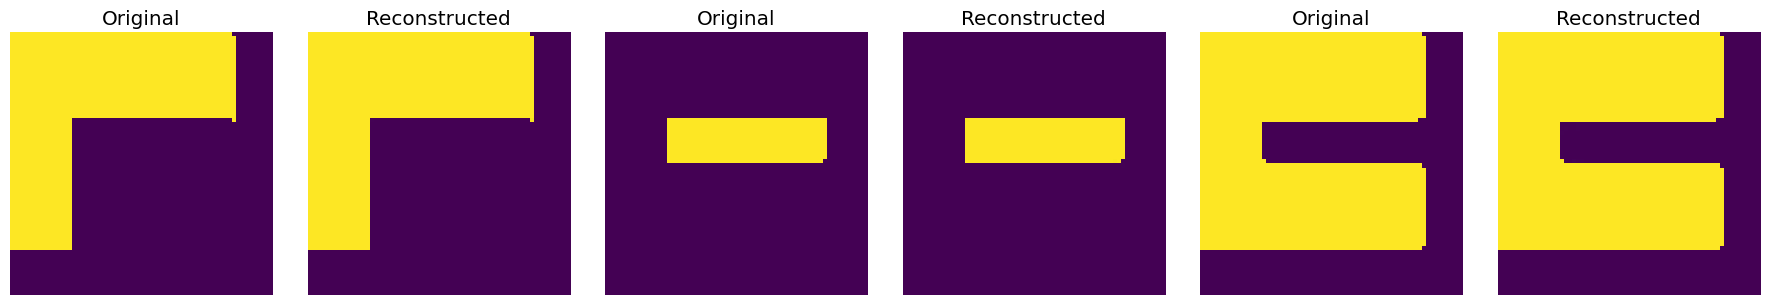

Epoch [101/500] | train_loss: 0.3330 | val_loss: 0.0245 | lr: 9.375e-06 | early_stop_counter: 12


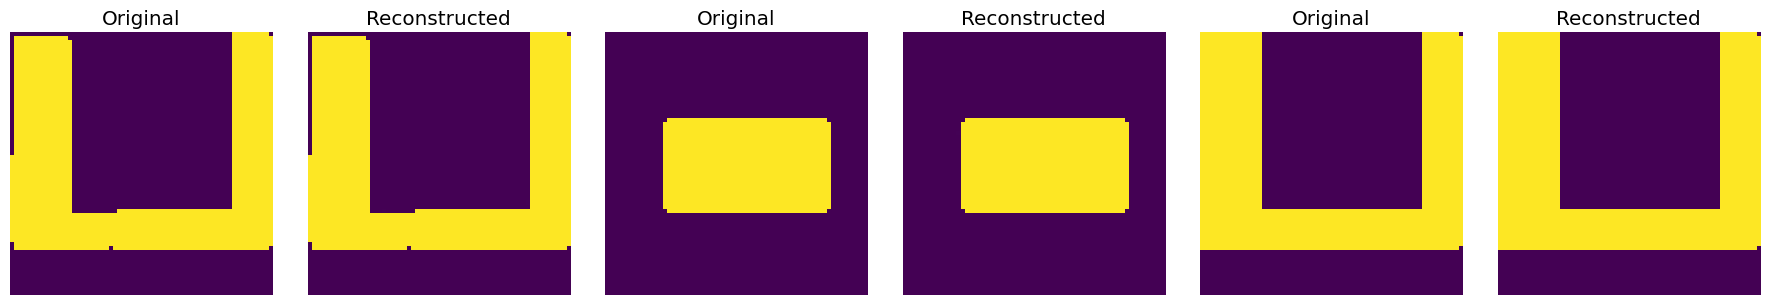

Epoch [102/500] | train_loss: 0.3355 | val_loss: 0.0252 | lr: 9.375e-06 | early_stop_counter: 13


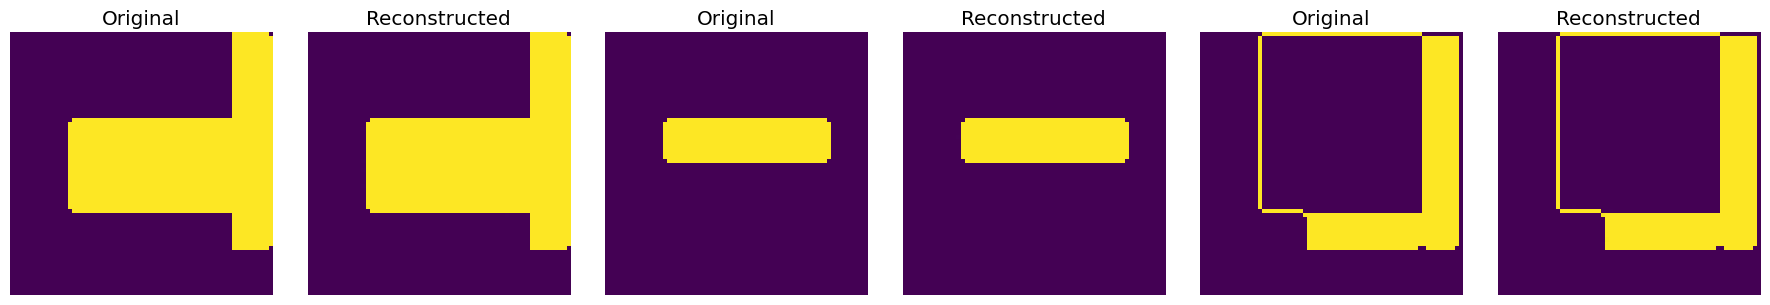

Epoch [103/500] | train_loss: 0.3089 | val_loss: 0.0146 | lr: 9.375e-06 | early_stop_counter: 14
Early stopping.
Training finished.


In [38]:
num_channels = 3 if X_img.ndim == 4 else 1
args["num_channels"] = num_channels

torch.random.manual_seed(args["seed"])

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on {device}")

# Initialize model
model = Autoencoder(num_channels, vq=True,
                    codebook_size=args["codebook_size"],
                    codebook_dim=args["codebook_dim"]).to(device)

# WandB
import wandb
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

project_name = "gen_AI_curriculum_learning"
run_name = f"{datetime.now().strftime('%Y%m%d_%H%M%S')}_VQ-VAE"

# Track with WandB
wandb_track = False

if wandb_track:
    wandb.init(
        project=project_name,
        sync_tensorboard=True,
        config=args,
        name=run_name,
        save_code=True,
    )
    writer = SummaryWriter(f"runs/{run_name}")
    writer.add_text(
        "hyperparameters",
        "|param|value|\n|-|-|\n%s"
        % ("\n".join([f"|{key}|{value}|" for key, value in args.items()])),
    )
else:
    writer = None

# Train VAE
loss_history = train_vae(model,
                        train_loader,
                        val_loader,
                        writer=writer,
                        num_epochs=args["num_epochs"],
                        learning_rate=args["learning_rate"],
                        early_stopping=args["early_stopping"],
                        wandb_track=wandb_track)

(89.16710330566407, 198.14911845703125)

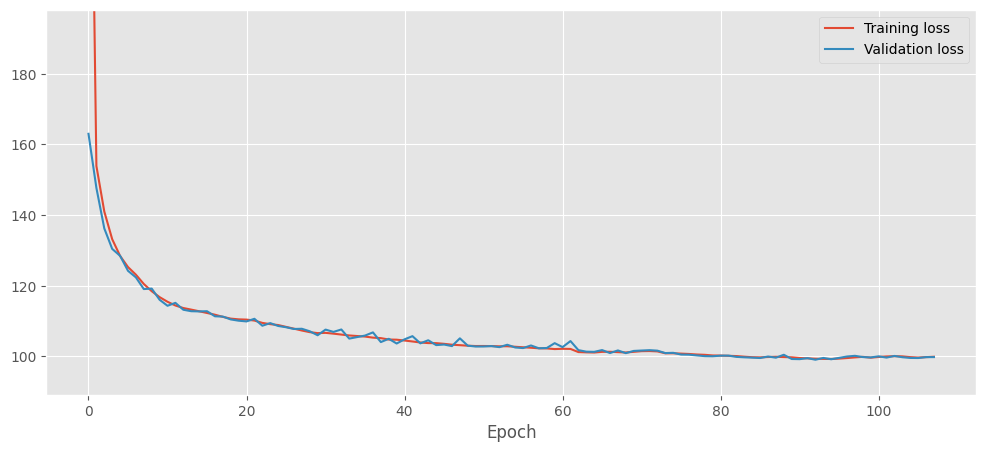

In [18]:
# Plot training and validation loss
plt.figure(figsize=(12,5))

plt.plot(loss_history['train_loss'], label="Training loss")
plt.plot(loss_history['val_loss'], label="Validation loss")
plt.xlabel("Epoch")
plt.legend()
min_loss = min([min(loss_history['val_loss']), min(loss_history['train_loss'])])
plt.ylim(min_loss*0.9,min_loss*2)

In [17]:
# Load best model
device = "cuda" if torch.cuda.is_available() else "cpu"

model = Autoencoder(num_channels, vq=True,
                    codebook_size=args["codebook_size"],
                    codebook_dim=args["codebook_dim"]).to(device)

model.load_state_dict(torch.load('best_model_vq-vae.pth'))

<All keys matched successfully>

In [13]:
# Save model
run_name = "20240814_120355_VQ-VAE"
torch.save(model.state_dict(), f"{run_name}_filled-tracks_-{args['codebook_size']}_dim-{args['codebook_dim']}.pt")

In [19]:
args

{'seed': 1234,
 'batch_size': 128,
 'num_epochs': 500,
 'learning_rate': 0.0003,
 'early_stopping': {'patience': 15, 'min_delta': 0.001},
 'codebook_size': 64,
 'codebook_dim': 4}

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load trained model
model_vq_vae = Autoencoder(num_channels, vq=True,
                    codebook_size=64,
                    codebook_dim=4).to(device)

model_vq_vae.load_state_dict(torch.load("best_model_vq-vae.pth"))

<All keys matched successfully>

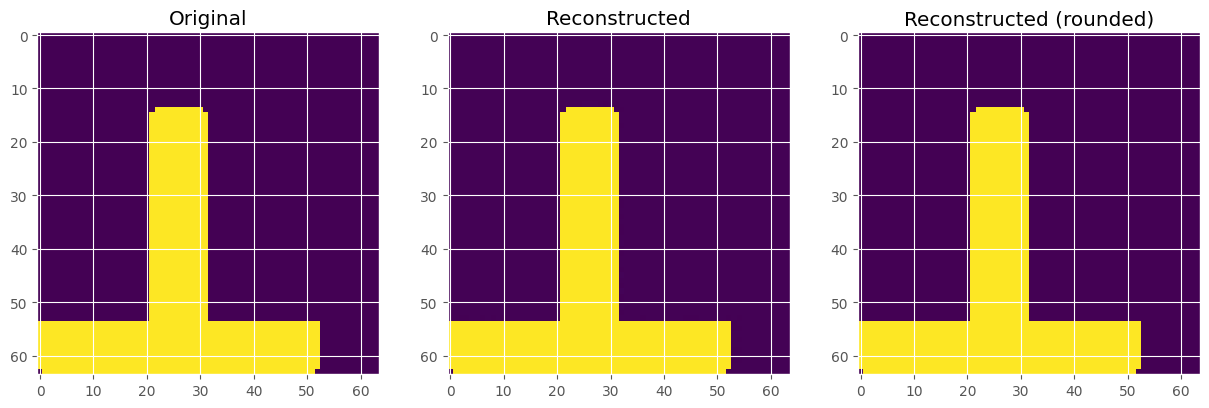

Mean squared error: 0.001972722355276346


In [25]:
# Predict with trained model
import matplotlib.pyplot as plt

model_vq_vae.eval()

x, _ = next(iter(train_loader))
out, _, _ = model_vq_vae(x.to(device))
out = out.detach().cpu()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(x[0].squeeze().moveaxis(0, -1))
axs[0].set_title("Original")

axs[1].imshow(out[0].squeeze().moveaxis(0, -1), )#cmap="viridis")
axs[1].set_title("Reconstructed")

threshold = 0.35
rounded = np.where(out[0].squeeze().moveaxis(0, -1).detach().numpy() > threshold, 1, 0)
axs[2].imshow(rounded)# cmap="viridis")
axs[2].set_title("Reconstructed (rounded)")

plt.show()

# Calculate the mean squared error
mse = nn.MSELoss(reduction='sum')
loss = mse(out, x) / x.size(0)
print(f"Mean squared error: {loss.item()}")

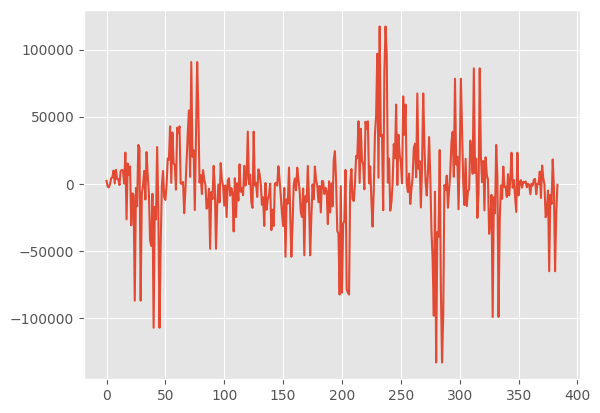

In [426]:
encoded = model.encoder(x.to(device))
z, indices, commit_loss = model.bottleneck(encoded)
plt.plot(z[0].detach().cpu().numpy().flatten())

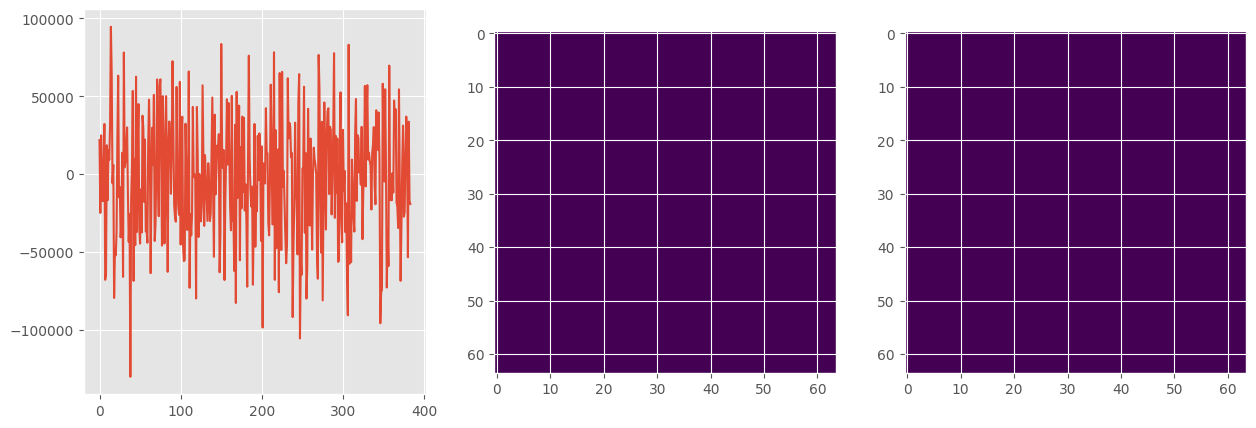

In [428]:
# Sample from latent space

bottleneck_dim = 24

_z = torch.randn(1, bottleneck_dim, 4, 4).to(device)
z = _z * 40_000

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.plot(z.flatten().cpu().numpy())

out = model.decoder(z).detach().cpu().squeeze().moveaxis(0, -1).numpy()

plt.subplot(132)
plt.imshow(out.clip(0, 1).round(decimals=1),)

plt.subplot(133)
threshold = 0.30
rounded = np.where(out > threshold, 1, 0)
plt.imshow(rounded)

_____________

## PixelCNN

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MaskedConv2d(nn.Conv2d):
    """
    Class extending nn.Conv2d to use masks.
    """

    def __init__(self, mask_type, in_channels, out_channels, kernel_size, padding=0):
        super(MaskedConv2d, self).__init__(in_channels, out_channels, kernel_size, padding=padding)
        self.register_buffer('mask', torch.ones(out_channels, in_channels, kernel_size, kernel_size).float())

        # _, depth, height, width = self.weight.size()
        h, w = kernel_size, kernel_size

        if mask_type == 'A':
            self.mask[:, :, h // 2, w // 2:] = 0
            self.mask[:, :, h // 2 + 1:, :] = 0
        else:
            self.mask[:, :, h // 2, w // 2 + 1:] = 0
            self.mask[:, :, h // 2 + 1:, :] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return super().forward(x)

class PixelCNNLayer(nn.Module):
    def __init__(self, in_channels, out_channels, mask_type='A'):
        super().__init__()
        self.conv = MaskedConv2d(mask_type, in_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.conv(x)
        out = self.relu(out)
        return out

class PixelCNN(nn.Module):
    def __init__(self, n_channels, n_layers, n_classes):
        super().__init__()
        self.input_conv = MaskedConv2d('A', 1, n_channels, kernel_size=3, padding=1)
        self.layers = nn.ModuleList([PixelCNNLayer(n_channels, n_channels, mask_type='B') for _ in range(n_layers - 1)])
        self.out = nn.Conv2d(n_channels, n_classes, kernel_size=1)

    def forward(self, x):
        if x.dim() == 3:
            x = x.unsqueeze(1)  # Add channel dimension if it's not there
        x = self.input_conv(x)
        for layer in self.layers:
            x = layer(x)
        return self.out(x)

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MaskedConv2d(nn.Conv2d):
    """
    Class extending nn.Conv2d to use masks.
    """

    def __init__(self, mask_type, in_channels, out_channels, kernel_size, padding=0):
        super(MaskedConv2d, self).__init__(in_channels, out_channels, kernel_size, padding=padding)
        self.register_buffer('mask', torch.ones(out_channels, in_channels, kernel_size, kernel_size).float())

        h, w = kernel_size, kernel_size

        if mask_type == 'A':
            self.mask[:, :, h // 2, w // 2:] = 0
            self.mask[:, :, h // 2 + 1:, :] = 0
        else:
            self.mask[:, :, h // 2, w // 2 + 1:] = 0
            self.mask[:, :, h // 2 + 1:, :] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return super().forward(x)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, mask_type='B'):
        super().__init__()
        self.conv1 = MaskedConv2d(mask_type, in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = MaskedConv2d(mask_type, out_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        
        # 1x1 convolution for residual connection if input and output channels differ
        self.residual = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        residual = self.residual(x)
        out = self.relu(self.conv1(x))
        out = self.conv2(out)
        return self.relu(out + residual)

class ResidualPixelCNN(nn.Module):
    def __init__(self, n_channels, n_layers, n_classes):
        super().__init__()
        self.input_conv = MaskedConv2d('A', 1, n_channels, kernel_size=3, padding=1)
        self.layers = nn.ModuleList([ResidualBlock(n_channels, n_channels, mask_type='B') for _ in range(n_layers - 1)])
        self.out = nn.Conv2d(n_channels, n_classes, kernel_size=1)

    def forward(self, x):
        if x.dim() == 3:
            x = x.unsqueeze(1)  # Add channel dimension if it's not there
        x = self.input_conv(x)
        for layer in self.layers:
            x = layer(x)
        return self.out(x)


class GatedResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, cond_channels, mask_type='B'):
        super().__init__()
        self.conv_f1 = MaskedConv2d(mask_type, in_channels + cond_channels, out_channels, kernel_size=3, padding=1)
        self.conv_g1 = MaskedConv2d(mask_type, in_channels + cond_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv_f2 = MaskedConv2d(mask_type, out_channels, out_channels, kernel_size=3, padding=1)
        self.conv_g2 = MaskedConv2d(mask_type, out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.residual = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
        ) if in_channels != out_channels else nn.Identity()

    def forward(self, x, cond):
        residual = self.residual(x)
        
        x_cond = torch.cat([x, cond], dim=1)
        f = self.conv_f1(x_cond)
        g = self.conv_g1(x_cond)
        out = torch.tanh(self.bn1(f)) * torch.sigmoid(g)
        
        f = self.conv_f2(out)
        g = self.conv_g2(out)
        out = torch.tanh(self.bn2(f)) * torch.sigmoid(g)
        
        return out + residual

class GatedResidualPixelCNN(nn.Module):
    def __init__(self, n_channels, n_layers, codebook_size, cond_channels):
        super().__init__()
        self.input_conv = MaskedConv2d('A', 1, n_channels, kernel_size=3, padding=1)
        self.input_bn = nn.BatchNorm2d(n_channels)
        self.layers = nn.ModuleList([GatedResidualBlock(n_channels, n_channels, cond_channels, mask_type='B') for _ in range(n_layers - 1)])
        self.out = nn.Conv2d(n_channels, codebook_size, kernel_size=1)
        
        # Condition embedding
        self.cond_embedding = nn.Linear(cond_channels, cond_channels)

    def forward(self, x, cond):
        if x.dim() == 3:
            x = x.unsqueeze(1)  # Add channel dimension if it's not there
        
        # Embed and reshape condition
        cond = self.cond_embedding(cond)
        cond = cond.view(cond.size(0), cond.size(1), 1, 1).expand(-1, -1, x.size(2), x.size(3))
        
        x = self.input_bn(self.input_conv(x))
        for layer in self.layers:
            x = layer(x, cond)
        return self.out(x)


class GatedResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, cond_channels, mask_type='B'):
        super().__init__()
        self.conv_f1 = MaskedConv2d(mask_type, in_channels + cond_channels, out_channels, kernel_size=3, padding=1)
        self.conv_g1 = MaskedConv2d(mask_type, in_channels + cond_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv_f2 = MaskedConv2d(mask_type, out_channels, out_channels, kernel_size=3, padding=1)
        self.conv_g2 = MaskedConv2d(mask_type, out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.residual = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
        ) if in_channels != out_channels else nn.Identity()

    def forward(self, x, cond):
        residual = self.residual(x)
        
        x_cond = torch.cat([x, cond], dim=1)
        f = self.conv_f1(x_cond)
        g = self.conv_g1(x_cond)
        out = torch.tanh(self.bn1(f)) * torch.sigmoid(g)
        
        f = self.conv_f2(out)
        g = self.conv_g2(out)
        out = torch.tanh(self.bn2(f)) * torch.sigmoid(g)
        
        return out + residual

class GatedResidualPixelCNN(nn.Module):
    def __init__(self, n_channels, n_layers, codebook_size, n_conditions):
        super().__init__()
        self.input_conv = MaskedConv2d('A', 1, n_channels, kernel_size=3, padding=1)
        self.input_bn = nn.BatchNorm2d(n_channels)
        
        self.cond_embedding = nn.Linear(n_conditions, n_channels)
        
        self.layers = nn.ModuleList([GatedResidualBlock(n_channels, n_channels, n_channels, mask_type='B') for _ in range(n_layers - 1)])
        self.out = nn.Conv2d(n_channels, codebook_size, kernel_size=1)

    def forward(self, x, cond):
        if x.dim() == 3:
            x = x.unsqueeze(1)  # Add channel dimension if it's not there
        
        # Embed and reshape condition
        cond = self.cond_embedding(cond)
        cond = cond.view(cond.size(0), cond.size(1), 1, 1).expand(-1, -1, x.size(2), x.size(3))
        
        x = self.input_bn(self.input_conv(x))
        for layer in self.layers:
            x = layer(x, cond)
        return self.out(x)

In [28]:
# Encode train data
for i in range(0, len(X_img_train), 1000):
    _, indices, _ = model_vq_vae(torch.tensor(X_img_train[i:i+1000]).view(-1, 1, 64, 64).to(device))
    if i == 0:
        indices_train = indices
    else:
        indices_train = torch.cat([indices_train, indices], dim=0)

# Encode validation data
for i in range(0, len(X_img_val), 1000):
    _, indices, _ = model_vq_vae(torch.tensor(X_img_val[i:i+1000]).view(-1, 1, 64, 64).to(device))
    if i == 0:
        indices_val = indices
    else:
        indices_val = torch.cat([indices_val, indices], dim=0)

indices_train = torch.tensor(indices_train)
indices_val = torch.tensor(indices_val)

torch.cuda.empty_cache()
import gc
gc.collect()

indices_train.shape, indices_val.shape

/tmp/ipykernel_1410148/3354598344.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  indices_train = torch.tensor(indices_train)
/tmp/ipykernel_1410148/3354598344.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  indices_val = torch.tensor(indices_val)


(torch.Size([56066, 4, 4]), torch.Size([6230, 4, 4]))

<Axes: >

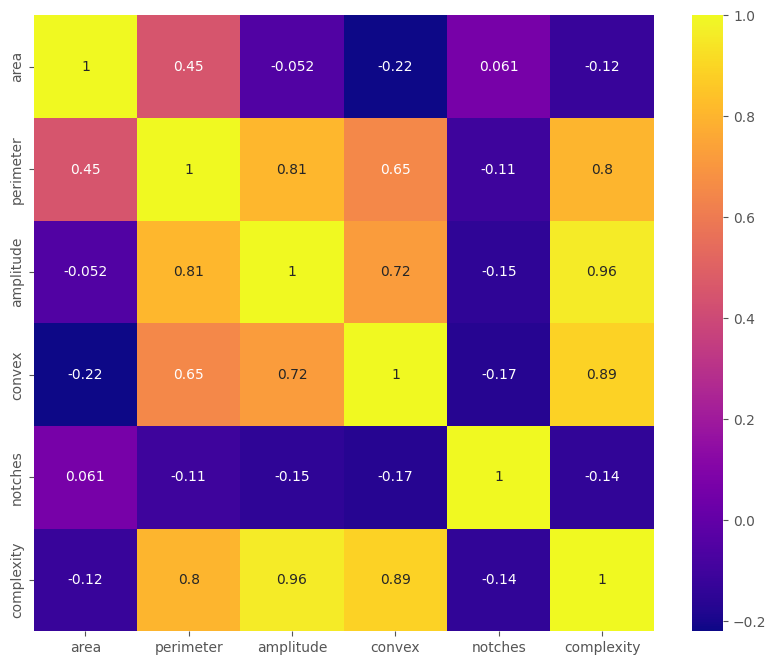

In [29]:
# Correlation matrix Y_train
import seaborn as sns

corr = np.corrcoef(Y_train.T)

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, xticklabels=['area', 'perimeter', 'amplitude', 'convex', 'notches', 'complexity'], yticklabels=['area', 'perimeter', 'amplitude', 'convex', 'notches', 'complexity'], cmap='plasma')

In [56]:
# Normalize Y_train and Y_val
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Y_train_scaled = scaler.fit_transform(Y_train)
Y_val_scaled = scaler.transform(Y_val)

metrics = [1,5]  # Select metrics [area, perimeter, amplitude, convex, notches, complexity]

Y_train_scaled = Y_train_scaled[:, metrics]  
Y_val_scaled = Y_val_scaled[:, metrics]

Y_train_scaled = torch.tensor(Y_train_scaled)
Y_val_scaled = torch.tensor(Y_val_scaled)

In [31]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF

# Dataloader with indices and labels
class IndicesDataset(Dataset):
    def __init__(self, indices, labels):
        self.indices = indices
        self.labels = labels

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        return self.indices[idx], self.labels[idx]

In [32]:
batch_size = 128

train_dataset = IndicesDataset(indices_train, Y_train_scaled)
val_dataset = IndicesDataset(indices_val, Y_val_scaled)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [33]:
#model = GatedResidualPixelCNN(n_channels=64, n_layers=32, codebook_size=64, cond_channels=11).to(device)  # n_classes: codebook size
model = GatedResidualPixelCNN(n_channels=64, n_layers=32, codebook_size=64, n_conditions=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss(reduction='sum')

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', threshold=0.05, patience=5, factor=0.5, min_lr=1e-6)
early_stop_counter = 0
best_val_loss = float('inf')
min_delta = 0.05

num_epochs = 200

loss_history = {'train_loss': [], 'val_loss': []}

for epoch in range(num_epochs):
    for batch_imgs, batch_labels in train_loader:
        batch_imgs = batch_imgs.to(device)
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()

        output = model(batch_imgs.float(), batch_labels.float())

        loss = criterion(output, batch_imgs)
        loss.backward()
        
        optimizer.step()

    # Validation
    with torch.no_grad():
        model.eval()
        val_loss = 0
        for batch_imgs, batch_labels in val_loader:
            batch_imgs = batch_imgs.to(device)
            batch_labels = batch_labels.to(device)

            output = model(batch_imgs.float(), batch_labels.float())

            loss = criterion(output, batch_imgs)
            val_loss += loss.item()

        val_loss /= len(val_loader.dataset)
    
    lr_scheduler.step(val_loss)

    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        early_stop_counter = 0
        # Save model
        torch.save(model.state_dict(), f"best_model_pixelcnn.pt")
    else:
        early_stop_counter += 1
        if early_stop_counter >= 10:
            print("Early stopping.")
            break

    print(f"Epoch {epoch+1}/{num_epochs} | Train loss: {loss.item():.4f} | Val loss: {val_loss:.4f} | lr: {lr_scheduler._last_lr[0]}")
    #print(f"Early stop counter: {early_stop_counter} | Best val loss: {best_val_loss}")

    loss_history['train_loss'].append(loss.item())
    loss_history['val_loss'].append(val_loss)

Epoch 1/200 | Train loss: 828.4564 | Val loss: 9.5093 | lr: 0.0003
Epoch 2/200 | Train loss: 445.4437 | Val loss: 5.3700 | lr: 0.0003
Epoch 3/200 | Train loss: 354.6337 | Val loss: 4.4720 | lr: 0.0003
Epoch 4/200 | Train loss: 327.5748 | Val loss: 4.0194 | lr: 0.0003
Epoch 5/200 | Train loss: 271.3057 | Val loss: 3.2177 | lr: 0.0003
Epoch 6/200 | Train loss: 261.0267 | Val loss: 3.0902 | lr: 0.0003
Epoch 7/200 | Train loss: 271.5824 | Val loss: 3.1199 | lr: 0.0003
Epoch 8/200 | Train loss: 217.3878 | Val loss: 2.5354 | lr: 0.0003
Epoch 9/200 | Train loss: 282.8142 | Val loss: 3.0785 | lr: 0.0003
Epoch 10/200 | Train loss: 200.2248 | Val loss: 2.5282 | lr: 0.0003
Epoch 11/200 | Train loss: 202.7131 | Val loss: 2.5800 | lr: 0.0003
Epoch 12/200 | Train loss: 201.6390 | Val loss: 2.4402 | lr: 0.0003
Epoch 13/200 | Train loss: 194.9344 | Val loss: 2.6361 | lr: 0.0003
Epoch 14/200 | Train loss: 174.7944 | Val loss: 2.3013 | lr: 0.0003
Epoch 15/200 | Train loss: 183.2358 | Val loss: 2.3233 | 

In [34]:
# Load best model
#model = GatedResidualPixelCNN(n_channels=64, n_layers=32, codebook_size=64, cond_channels=11).to(device)  # n_classes: codebook size
model = GatedResidualPixelCNN(n_channels=64, n_layers=32, codebook_size=64, n_conditions=2).to(device)  # n_classes: codebook size
model.load_state_dict(torch.load("best_model_pixelcnn.pt"))

<All keys matched successfully>

<Figure size 1200x500 with 0 Axes>

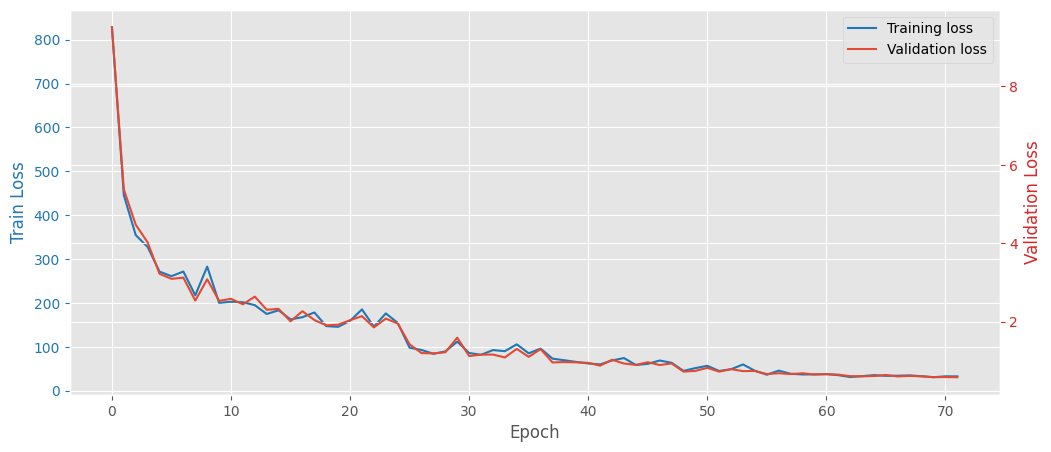

In [35]:
# Plot training and validation loss
plt.figure(figsize=(12,5))

fig, ax = plt.subplots(1, 1, figsize=(12, 5))

ln1 = ax.plot(loss_history['train_loss'], color="tab:blue", label="Training loss")
ax.set_ylabel("Train Loss", color="tab:blue")
ax.tick_params(axis='y', colors="tab:blue")  # Change y-axis tick colors
ax.set_xlabel("Epoch")

ax2 = ax.twinx()
ln2 = ax2.plot(loss_history['val_loss'], label="Validation loss")
ax2.set_ylabel("Validation Loss", color="tab:red")
ax2.tick_params(axis='y', colors="tab:red")  # Change y-axis tick colors

# added these three lines
lns = ln1+ln2
labs = [l.get_label() for l in lns]

ax2.legend(lns, labs, loc=0)

In [36]:
# Generate array with four elements, of which all are zero except one (random position)
def generate_random_condition(num_conditions=11):
    cond = torch.zeros(num_conditions)
    cond[torch.randint(0, num_conditions, (1,)).item()] = 1
    return cond.unsqueeze(0)
def generate_random_condition(num_conditions=2):
    cond = torch.randn(num_conditions)
    return cond.unsqueeze(0)

def generate_latent_code(model, shape, n_classes, cond=None, device='cuda'):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Initialize with zeros
        latent_code = torch.zeros(1, shape[0], shape[1], device=device)

        if cond is not None:
            cond = torch.tensor(cond).unsqueeze(0).to(device)
        else:
            cond = generate_random_condition().to(device)
        
        # Generate each "pixel" in the latent code sequentially
        for i in range(shape[0]):
            for j in range(shape[1]):
                output = model(latent_code.unsqueeze(0), cond.float())  # Add batch dimension
                probas = F.softmax(output[0, :, i, j], dim=0)  # Remove batch dimension
                sample = torch.multinomial(probas.unsqueeze(0), 1).squeeze()
                latent_code[0, i, j] = sample.float()
    
    return latent_code.squeeze().long()  # Remove extra dimensions and convert to long

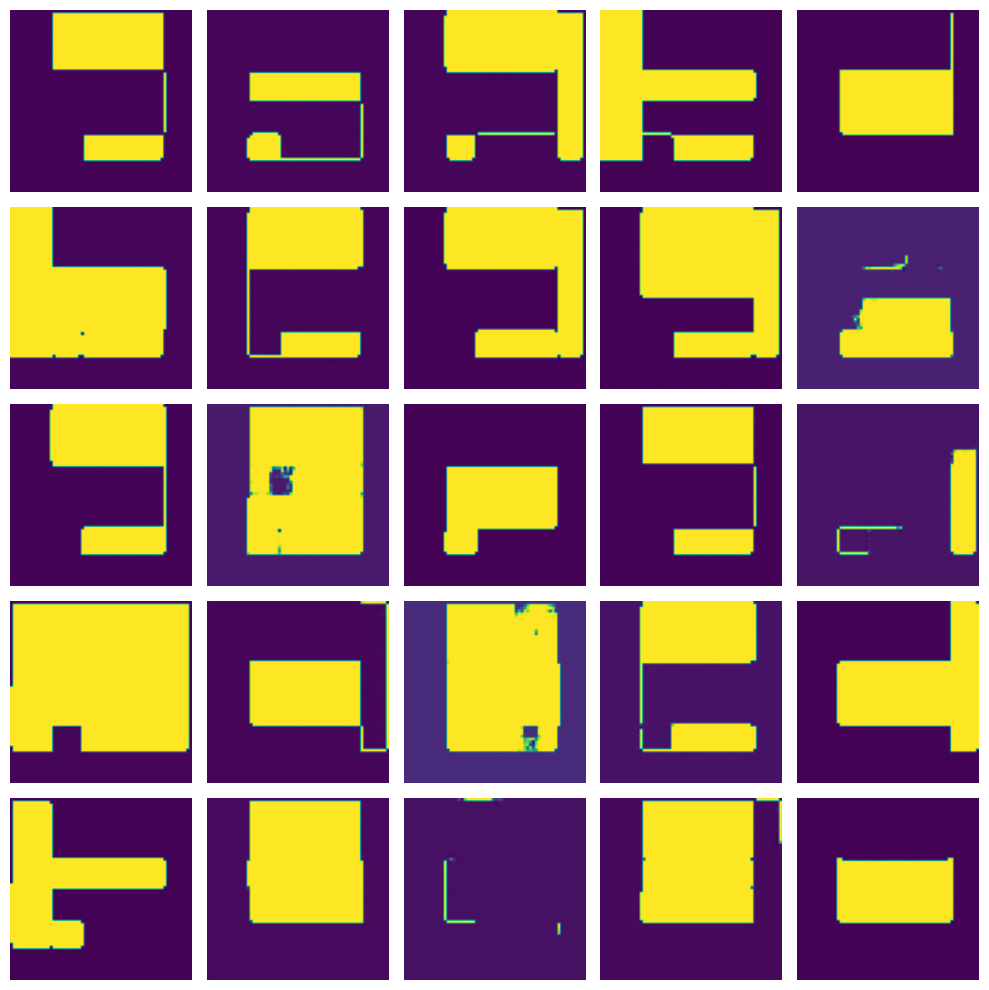

In [40]:
plt.figure(figsize=(10, 10))

# Generate a new latent code
latent_shape = (4, 4)

for i in range(25):
    # Generate a new latent code
    new_latent_code = generate_latent_code(model, latent_shape, 64)

    # Get the output from the indices
    output = model_vq_vae.bottleneck.vq.get_output_from_indices(new_latent_code.unsqueeze(0).to(device))
    output = output.moveaxis(-1, 1)

    # Decode
    decoded = model_vq_vae.decoder(output)

    plt.subplot(5, 5, i+1)
    out = decoded[0].detach().cpu().squeeze().numpy()
    plt.imshow(out)
    plt.axis('off')

plt.tight_layout()

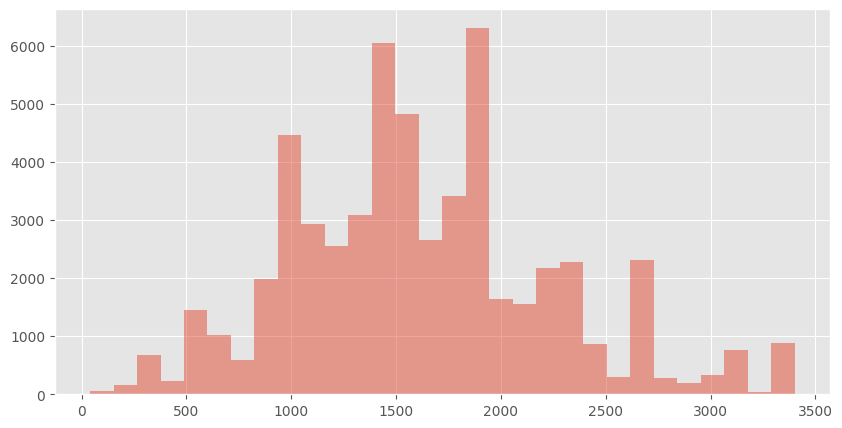

In [38]:
# Area histogram
plt.figure(figsize=(10, 5))
plt.hist(Y_train[:,0], bins=30, alpha=0.5, label='Area')
plt.show()

Text(0, 0.5, 'Perimeter')

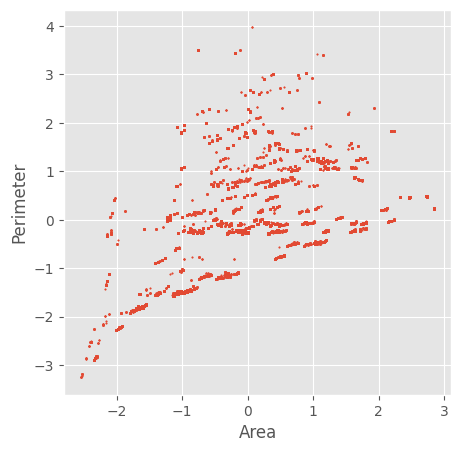

In [39]:
# Scatter plot: area vs perimeter
plt.figure(figsize=(5, 5))
plt.scatter(Y_train_scaled[:,0], Y_train_scaled[:,1], s=1)
plt.xlabel("Area")
plt.ylabel("Perimeter")

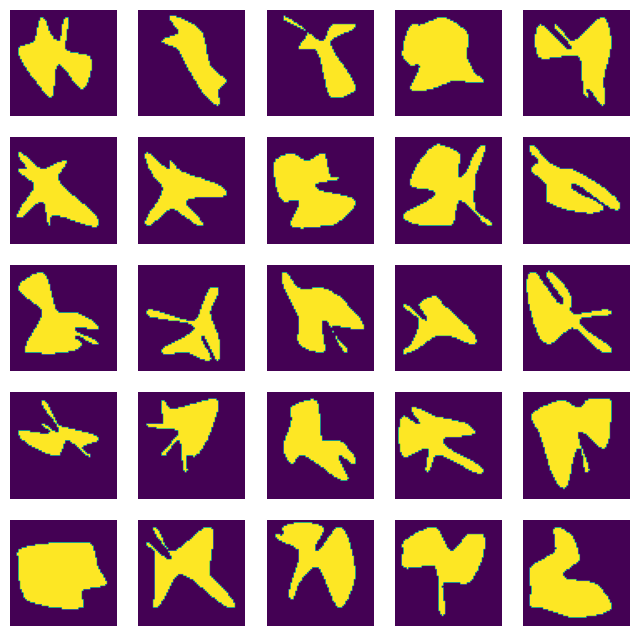

In [46]:
# Plot tracks
idx = np.where((Y_train[:,0] < 70_000) & (Y_train[:,1] > 800))[0]  # [area, perimeter, amplitude, convex, notches, complexity]

plt.figure(figsize=(8,8))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X_img_train[idx[i]].squeeze())
    plt.axis('off')

In [111]:
Y_train_scaled[:,0].min(), Y_train_scaled[:,0].max(), Y_train_scaled[:,1].min(), Y_train_scaled[:,1].max()

(tensor(-3.2529, dtype=torch.float64),
 tensor(3.9762, dtype=torch.float64),
 tensor(-1.3339, dtype=torch.float64),
 tensor(2.7556, dtype=torch.float64))

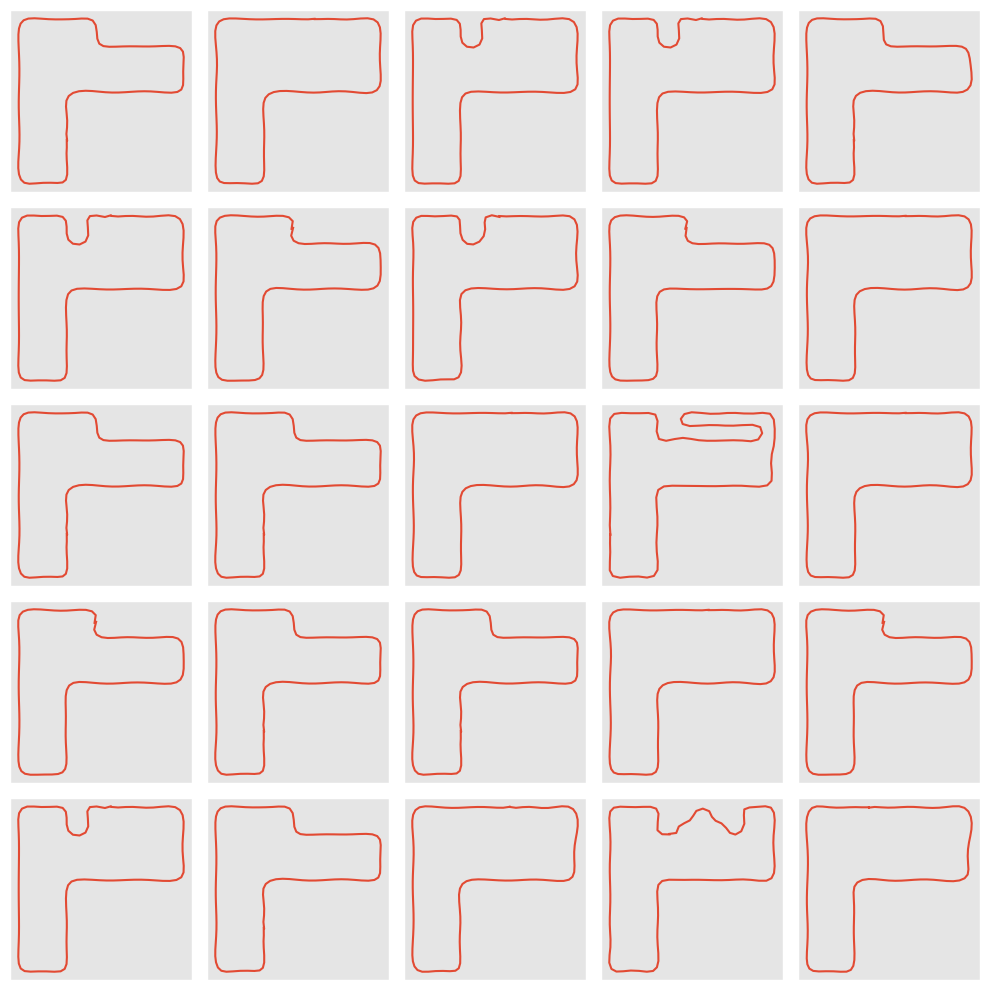

In [113]:
# Set conditions: -5 (low) to 5 (high)
area = 0.
perimeter = 0.

plt.figure(figsize=(10, 10))

# Generate a new latent code
latent_shape = (4, 4)

for i in range(25):

    control_points = None

    while control_points is None:

        # Generate a new latent code
        new_latent_code = generate_latent_code(model, latent_shape, 64, cond=[area, perimeter])

        # Get the output from the indices
        output = model_vq_vae.bottleneck.vq.get_output_from_indices(new_latent_code.unsqueeze(0).to(device))
        output = output.moveaxis(-1, 1)

        # Decode
        decoded = model_vq_vae.decoder(output)
        out = decoded[0].detach().cpu().squeeze().numpy()

        plt.subplot(5, 5, i+1)
        # Get track from image
        control_points = get_control_points_from_image((out * 255).clip(0, 255).round(0).astype(np.uint8))

    x, y = control_points[:,1], control_points[:,0]
    
    # Plot track
    # plot_track(np.array([x, y]).T)  # CarRacing track
    plt.plot(x, y)  # CARLA track
    #plt.gca().invert_yaxis()        
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    #plt.imshow(out)

    print(f"Progress: {i}/25", end="\r")

plt.tight_layout()

[]

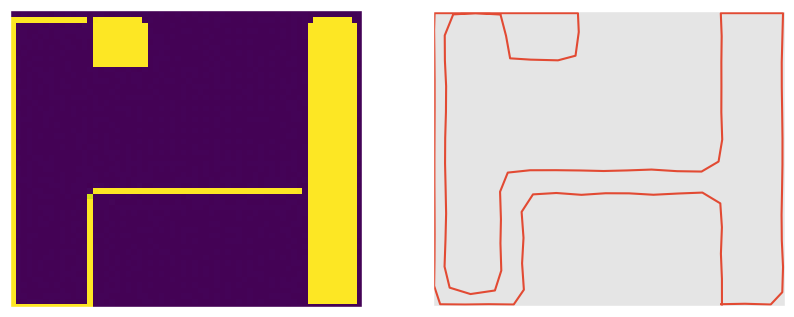

In [104]:
# area, perimeter = -1., 4.

# # Generate a new latent code
# new_latent_code = generate_latent_code(model, latent_shape, 64, cond=[area, perimeter])

# # Get the output from the indices
# output = model_vq_vae.bottleneck.vq.get_output_from_indices(new_latent_code.unsqueeze(0).to(device))
# output = output.moveaxis(-1, 1)

# # Decode
# decoded = model_vq_vae.decoder(output)
# out = decoded[0].detach().cpu().squeeze().numpy()

# # Get track from image
# control_points = None
# while control_points is None:
#     control_points = get_control_points_from_image((out * 255).clip(0, 255).round(0).astype(np.uint8))

# x, y = control_points[:,1], control_points[:,0]

# # Clip y to [0, 50]
# y = np.clip(y, 0, 50)

# x *= 400/64  # Scale x to [0, 396]
# y *= 330/50  # Scale y to [0, 330]

fig, axs = plt.subplots(1,2, figsize=(10,5))

axs[0].imshow(out)
axs[0].set_ylim(0,54)
# axs[0].invert_yaxis()
axs[0].grid(False)
axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].plot(x, y)
axs[1].set_xlim(-2,397)
axs[1].set_ylim(-2,333)
axs[1].set_aspect('equal')
axs[1].set_xticks([])
axs[1].set_yticks([])

In [99]:
x,y

(array([ 3.24654415e+02,  3.51702369e+02,  3.80831543e+02,  3.93922211e+02,
         3.94780331e+02,  3.93377624e+02,  3.93111171e+02,  3.93653940e+02,
         3.94129238e+02,  3.94160849e+02,  3.93795668e+02,  3.93358126e+02,
         3.93304603e+02,  3.94064603e+02,  3.94774359e+02,  3.87482610e+02,
         3.62121486e+02,  3.33799952e+02,  3.24287367e+02,  3.25277018e+02,
         3.24920406e+02,  3.24992545e+02,  3.24879100e+02,  3.25891316e+02,
         3.21745810e+02,  3.02482779e+02,  2.74884426e+02,  2.45798409e+02,
         2.18018843e+02,  1.91568607e+02,  1.65093334e+02,  1.37255393e+02,
         1.08208947e+02,  8.30075012e+01,  7.42699155e+01,  7.52570030e+01,
         7.47030961e+01,  7.56629375e+01,  6.84425353e+01,  4.07574868e+01,
         1.71699974e+01,  1.13937755e+01,  1.24503783e+01,  1.31700255e+01,
         1.26005487e+01,  1.19594826e+01,  1.21293346e+01,  1.29744664e+01,
         1.31799125e+01,  1.17973127e+01,  1.16041515e+01,  2.12054327e+01,
         4.6

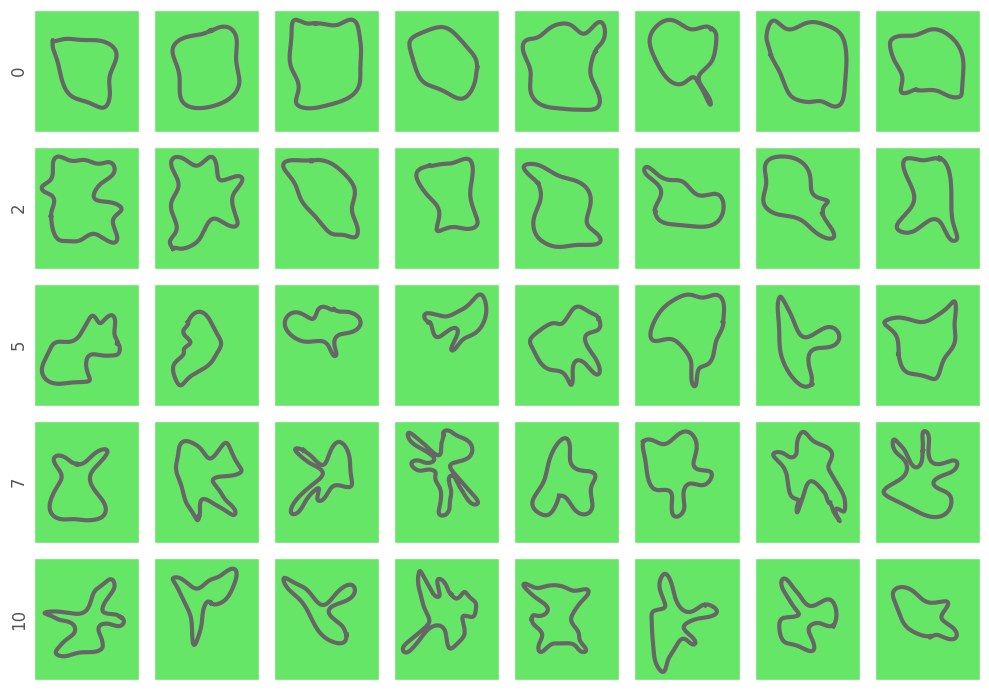

In [58]:
# Plot 16 samples from the latent space. Each row is a different condition
plt.figure(figsize=(10, 7))

# Generate a new latent code
latent_shape = (4, 4)

# conditions = [[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1]]
# condition_names = ["Triangle", "Rectangle", "Cross", "Circle", "Star"]
conditions = [[1,0,0,0,0,0,0,0,0,0,0], [0,0,1,0,0,0,0,0,0,0,0], [0,0,0,0,0,1,0,0,0,0,0],
              [0,0,0,0,0,0,0,1,0,0,0], [0,0,0,0,0,0,0,0,0,0,1]]
condition_names = ["0", "2", "5", "7", "10"]

for i in range(5):
    for j in range(8):
        # Generate a new latent code
        new_latent_code = generate_latent_code(model, latent_shape, 64, cond=conditions[i])

        # Get the output from the indices
        output = model_vq_vae.bottleneck.vq.get_output_from_indices(new_latent_code.unsqueeze(0).to(device))
        output = output.moveaxis(-1, 1)

        # Decode
        decoded = model_vq_vae.decoder(output)

        plt.subplot(5, 8, i*8+j+1)
        out = decoded[0].detach().cpu().squeeze().numpy()
        #plt.imshow(out)
        # Get track from image
        control_points = get_control_points_from_image((out * 255).clip(0, 255).round(0).astype(np.uint8))
        x, y = control_points[:,0], control_points[:,1]
        plot_track(np.array([x, y]).T)
        plt.gca().invert_yaxis()        
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])

        # Add condition name to each row
        if j == 0:
            plt.ylabel(condition_names[i])

plt.tight_layout()

In [57]:
import alphashape
import cv2

IMG_SIZE = (64, 64)

def get_control_points_from_image(img):
    """Image must have uint8 values from 0 to 255"""
    
    # Sharpen image
    kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
    img = cv2.filter2D(img, -1, kernel)
    img = np.where(img < 200, 0, img)

    y, x = np.where(img != 0)
    # Calculate center
    center = [int(x.mean()), int(y.mean())]
    points_2d = np.array([x,y]).T
    # Fill contour
    for point in points_2d:
        cv2.line(img, point, center, color=255, thickness=1)
    points_2d = np.array(np.where(img > 100)).T
    # Get alpha shape
    alpha_shape = alphashape.alphashape(points_2d, alpha=0.6)
    geom_type = alpha_shape.geom_type
    alpha = 0.6
    while geom_type == "MultiPolygon":
        alpha -= 0.01
        alpha_shape = alphashape.alphashape(points_2d, alpha=alpha)
        geom_type = alpha_shape.geom_type

    points = np.array([xy for xy in alpha_shape.exterior.coords])
    points = fit_spline(points, num_points=300)

    return points*350/IMG_SIZE


import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

def fit_spline(points, num_points=200):
    # Linear length along the line:
    distance = np.cumsum( np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1 )) )
    distance = np.insert(distance, 0, 0)/distance[-1]

    # Build a list of the spline function, one for each dimension:
    splines = [UnivariateSpline(distance, coords, k=5, s=10) for coords in points.T]

    # Computed the spline for the asked distances:
    alpha = np.linspace(0, 1, num_points)
    points_fitted = np.vstack([spl(alpha) for spl in splines]).T

    return points_fitted

def plot_track(track, checkpoints=None):
    # Plot track
    linewidth = 3
    plt.plot(track[:,1], track[:,0], linewidth=linewidth, color=[0.4, 0.4, 0.4])
    plt.plot([track[0,1], track[-1,1]], [track[0,0], track[-1,0]], linewidth=linewidth, color=[0.4, 0.4, 0.4])

    # Plot checkpoints
    if checkpoints is not None:
        for i in range(len(checkpoints)):
            y, x = checkpoints[i,:]
            plt.plot(x, y, 'o', markersize=2, color="tab:orange")
            plt.text(x, y, str(i), fontsize=10, color="black")
    
    plt.xlim(-20,360)
    plt.ylim(-20,360)

    ax = plt.gca()
    ax.set_facecolor(np.array([102, 230, 102])/255.)

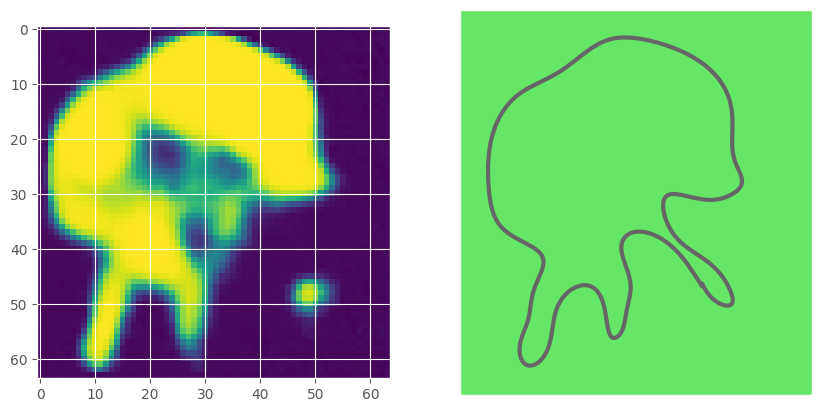

In [76]:
# Condition vector
condition = [2, 5]

# Generate a new latent code
new_latent_code = generate_latent_code(model, latent_shape, 64, cond=condition)

# Get the output from the indices
output = model_vq_vae.bottleneck.vq.get_output_from_indices(new_latent_code.unsqueeze(0).to(device))
output = output.moveaxis(-1, 1)

# Decode
decoded = model_vq_vae.decoder(output)
out = decoded[0].detach().cpu().squeeze().numpy()

# Get track from image
control_points = get_control_points_from_image((out * 255).clip(0, 255).round(0).astype(np.uint8))
x, y = control_points[:,0], control_points[:,1]

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.imshow(out)

plt.subplot(122)
plot_track(np.array([x, y]).T)
plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()

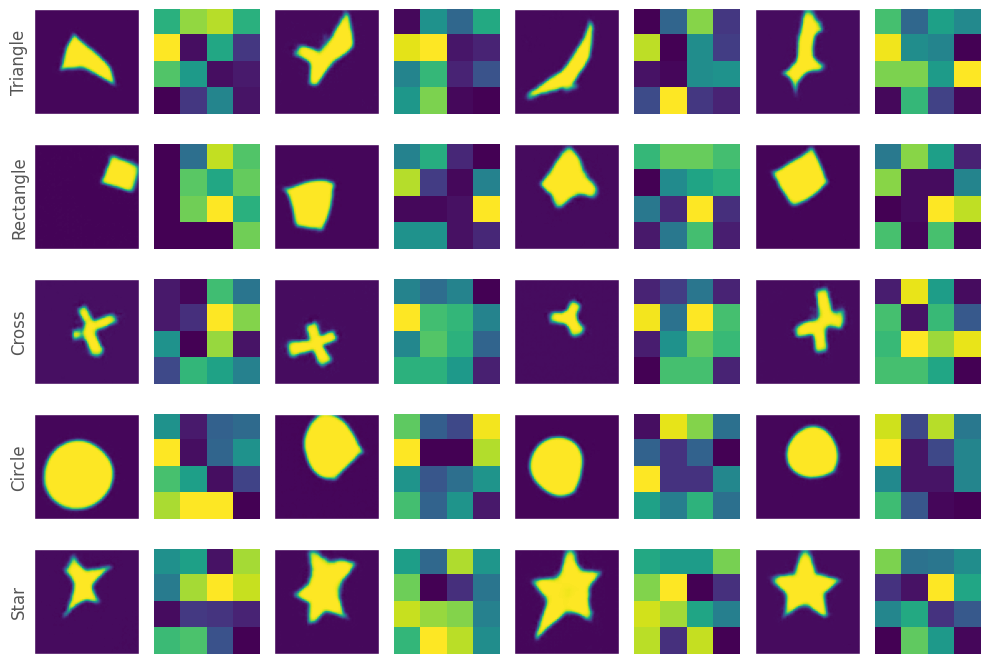

In [49]:
# Plot 16 samples from the latent space. Each row is a different condition
plt.figure(figsize=(10, 7))

# Generate a new latent code
latent_shape = (4, 4)

conditions = [[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1]]
condition_names = ["Triangle", "Rectangle", "Cross", "Circle", "Star"]

for i in range(5):
    for j in range(4):
        # Generate a new latent code
        new_latent_code = generate_latent_code(model, latent_shape, 64, cond=conditions[i])

        # Get the output from the indices
        output = model_vq_vae.bottleneck.vq.get_output_from_indices(new_latent_code.unsqueeze(0).to(device))
        output = output.moveaxis(-1, 1)

        # Decode
        decoded = model_vq_vae.decoder(output)

        # Plot output
        plt.subplot(5, 8, i*8+j*2+1)
        out = decoded[0].detach().cpu().squeeze().numpy()
        plt.imshow(out)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])

        # Add condition name to each row
        if j == 0:
            plt.ylabel(condition_names[i])

        # Plot latent code
        plt.subplot(5, 8, i*8+2*j+2)
        plt.imshow(new_latent_code.cpu().numpy() / 64 * 255)
        plt.axis('off')

plt.tight_layout()

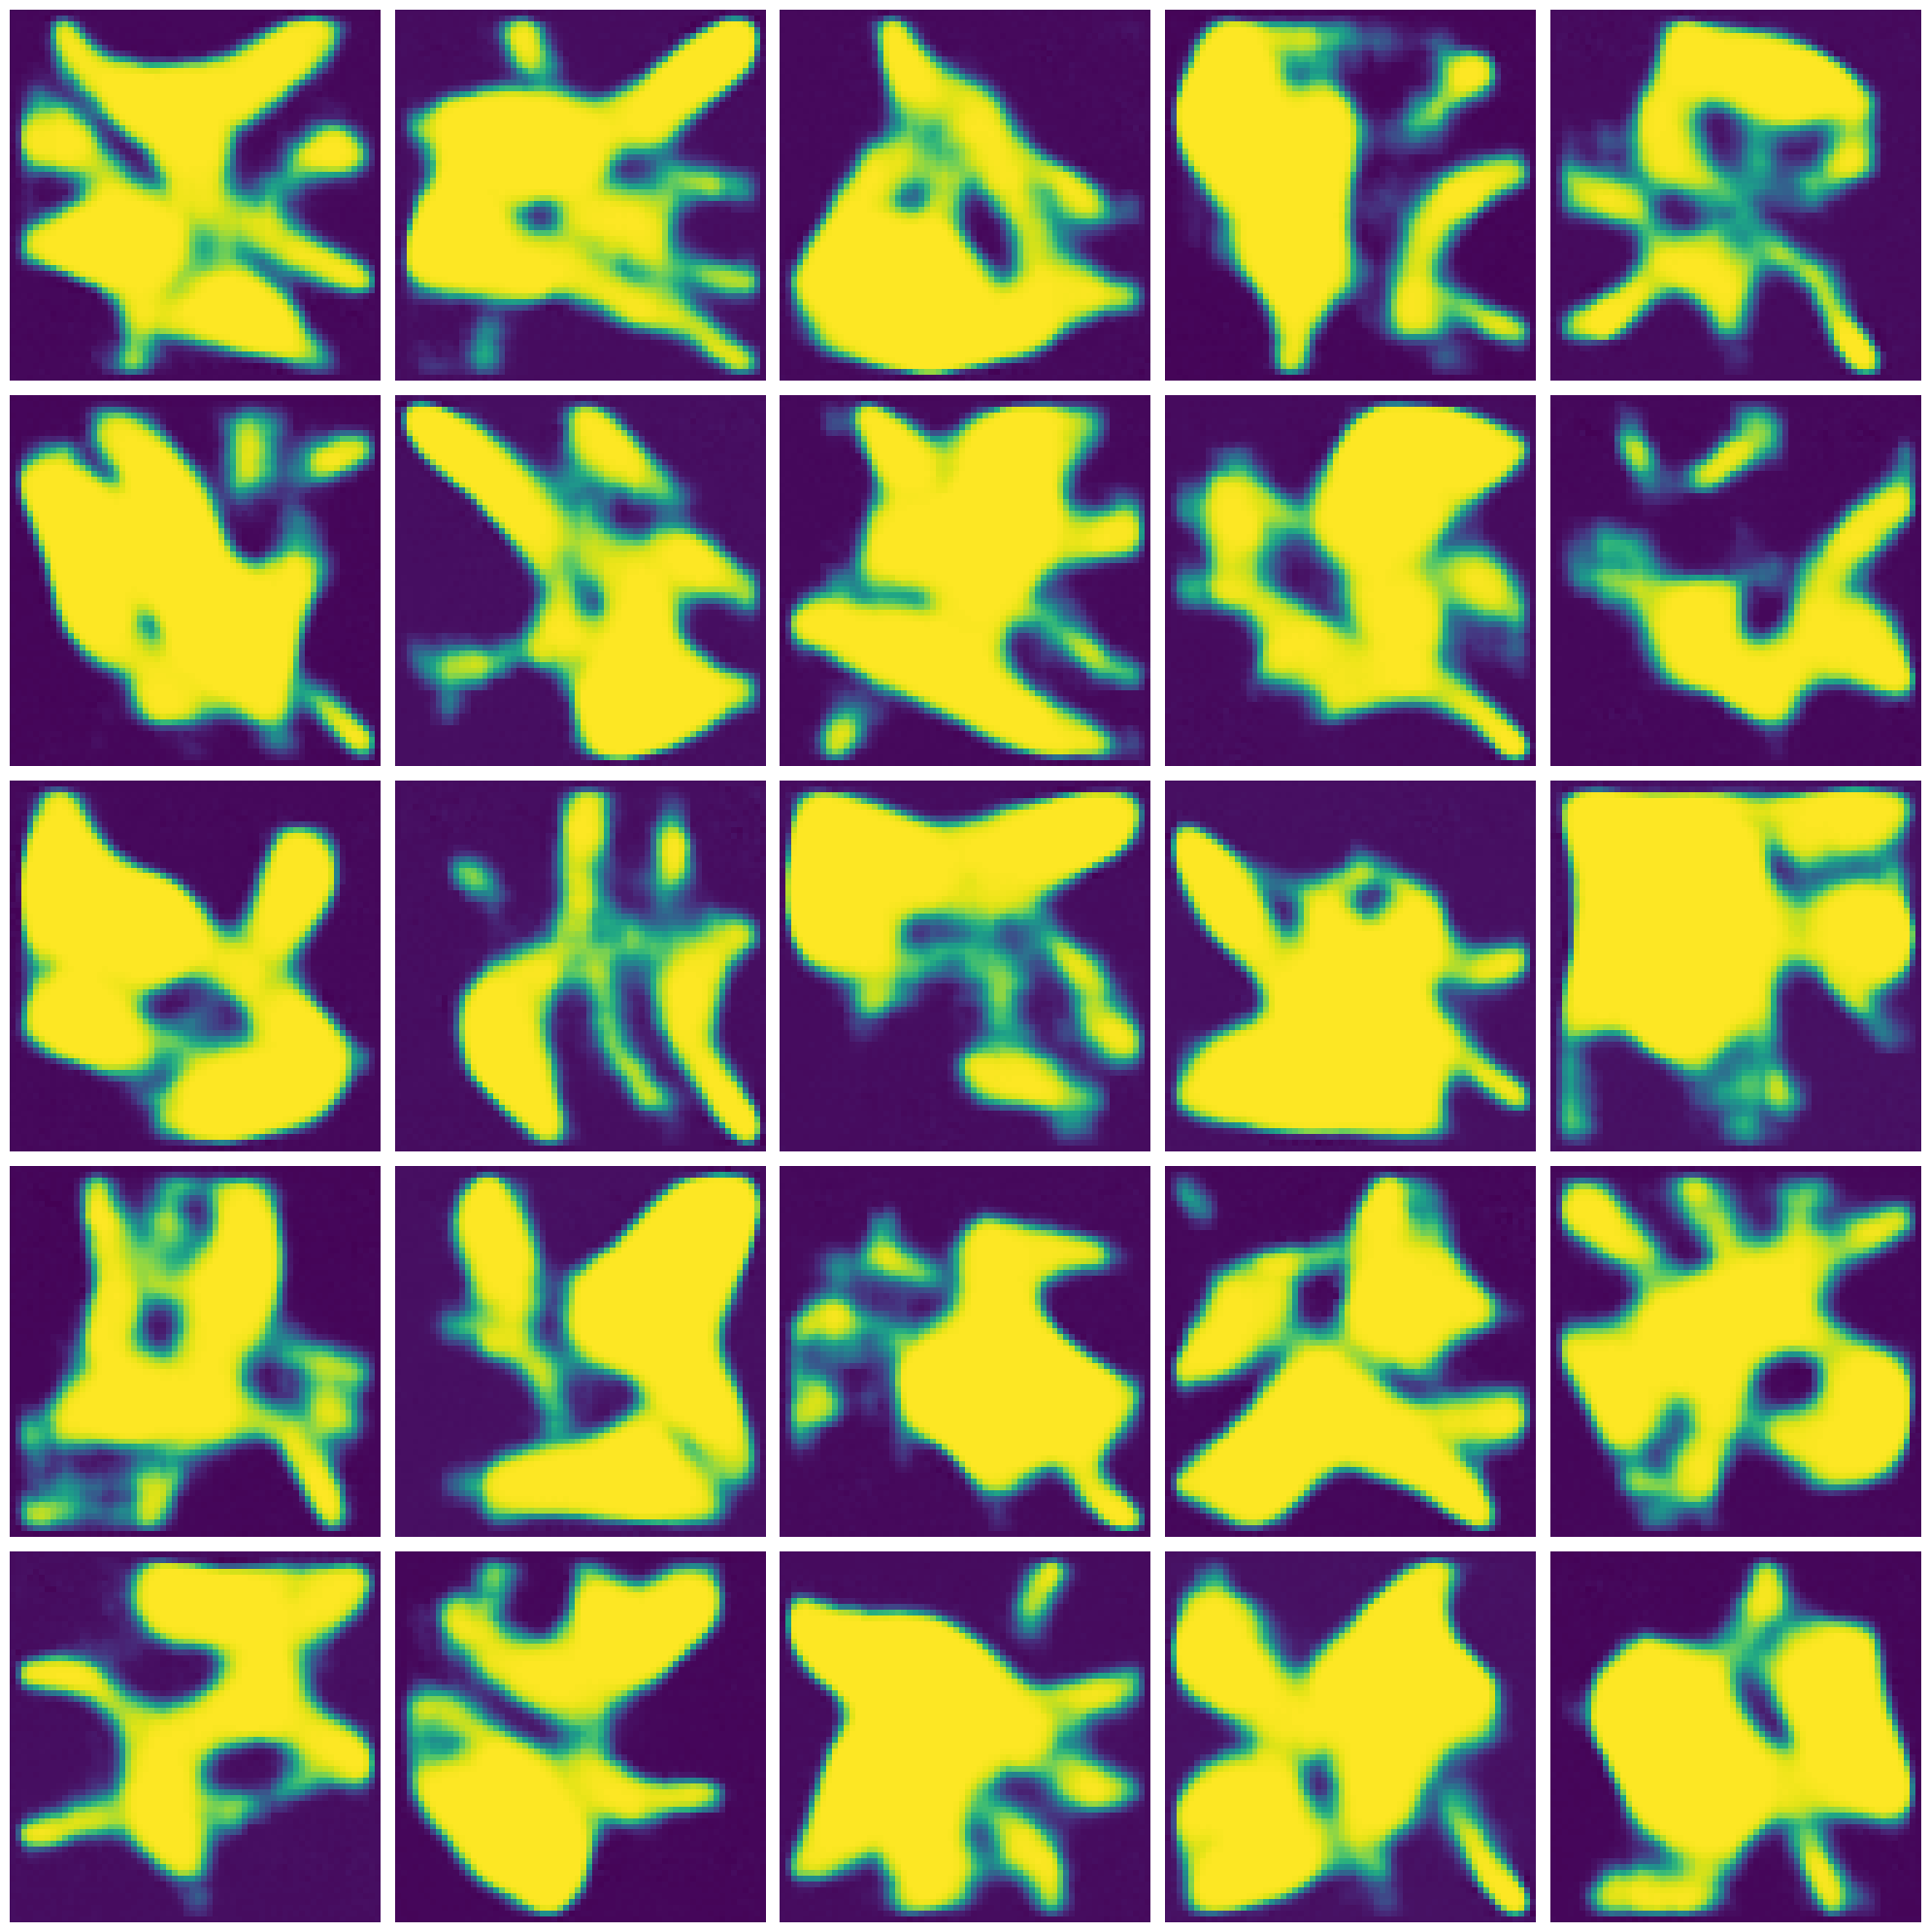

In [265]:
plt.figure(figsize=(20, 20))

for i in range(25):
    # Create a 4x4 array with random numbers between 0 and 63
    new_latent_code = torch.randint(0, 64, latent_shape, device=device)

    # Get the output from the indices
    output = model_vq_vae.bottleneck.vq.get_output_from_indices(new_latent_code.unsqueeze(0).to(device))
    output = output.moveaxis(-1, 1)

    # Decode
    decoded = model_vq_vae.decoder(output)

    plt.subplot(5, 5, i+1)
    out = decoded[0].detach().cpu().squeeze().numpy()
    plt.imshow(out)
    plt.axis('off')

plt.tight_layout()

In [181]:
import numpy as np
from PIL import Image, ImageDraw, ImageOps
import random

def create_random_shape_image(shape, size=(64, 64)):
    """
    Creates a random grayscale image of a given geometric shape with distortions.

    Parameters:
    - shape: str, the shape to draw ('triangle', 'rectangle', 'circle', 'star').
    - size: tuple, the size of the image (default is 64x64).

    Returns:
    - numpy array: The generated image as a numpy array.
    """
    img = Image.new('L', size, 0)  # Create a black image
    draw = ImageDraw.Draw(img)
    w, h = size

    if shape == 'triangle':
        # Random triangle with minimum side length
        points = generate_random_triangle(w, h)
        draw.polygon(points, fill=255)

    elif shape == 'rectangle':
        # Random rectangle with minimum side lengths
        points = generate_random_rectangle(w, h)
        draw.polygon(points, fill=255)

    elif shape == 'cross':
        # Random cross
        vertical, horizontal = generate_random_cross(w, h)
        draw.rectangle(vertical, fill=255)
        draw.rectangle(horizontal, fill=255)

    elif shape == 'circle':
        # Random circle
        radius = random.randint(15, min(w, h)//2)
        x = random.randint(radius, w - radius)
        y = random.randint(radius, h - radius)
        draw.ellipse((x - radius, y - radius, x + radius, y + radius), fill=255)

    elif shape == 'star':
        # Random star (5 points)
        cx, cy = w // 2, h // 2
        radius = random.randint(15, min(w, h) // 2)
        points = []
        for i in range(10):
            angle = i * np.pi / 5
            r = radius if i % 2 == 0 else radius // 2
            x = cx + int(np.cos(angle) * r)
            y = cy + int(np.sin(angle) * r)
            points.append((x, y))
        draw.polygon(points, fill=255)

    # Apply random transformations to the image
    img = apply_random_transformations(img)

    return np.array(img)

def generate_random_triangle(w, h, min_side_length=20):
    """
    Generates a random triangle with a minimum side length.

    Parameters:
    - w: int, width of the image.
    - h: int, height of the image.
    - min_side_length: int, minimum allowed length of each side of the triangle.

    Returns:
    - list of tuples: The vertices of the triangle.
    """
    while True:
        points = [
            (random.randint(0, w), random.randint(0, h)),
            (random.randint(0, w), random.randint(0, h)),
            (random.randint(0, w), random.randint(0, h))
        ]
        
        # Calculate side lengths
        side_lengths = [
            np.linalg.norm(np.array(points[0]) - np.array(points[1])),
            np.linalg.norm(np.array(points[1]) - np.array(points[2])),
            np.linalg.norm(np.array(points[2]) - np.array(points[0]))
        ]

        # Calculate distance from vertices to opposite sides
        distances = [
            np.linalg.norm(np.cross(np.array(points[1]) - np.array(points[0]), np.array(points[0]) - np.array(points[2]))) / np.linalg.norm(np.array(points[1]) - np.array(points[0])),
            np.linalg.norm(np.cross(np.array(points[2]) - np.array(points[1]), np.array(points[1]) - np.array(points[0]))) / np.linalg.norm(np.array(points[2]) - np.array(points[1])),
            np.linalg.norm(np.cross(np.array(points[0]) - np.array(points[2]), np.array(points[2]) - np.array(points[1]))) / np.linalg.norm(np.array(points[0]) - np.array(points[2]))
        ]
        
        # Check if all sides are longer than the minimum side length, and the distances are not too small
        if all(side >= min_side_length for side in side_lengths) and all(dist >= 10 for dist in distances):
            break
            
    return points

def generate_random_rectangle(w, h, min_side_length=20):
    """
    Generates a random rectangle with a minimum side length.

    Parameters:
    - w: int, width of the image.
    - h: int, height of the image.
    - min_side_length: int, minimum allowed length of each side of the rectangle.

    Returns:
    - list of tuples: The vertices of the rectangle.
    """
    while True:
        x0 = random.randint(0, w - min_side_length)
        y0 = random.randint(0, h - min_side_length)
        width = random.randint(min_side_length, w - x0)
        height = random.randint(min_side_length, h - y0)
        
        x1 = x0 + width
        y1 = y0
        
        x2 = x1
        y2 = y0 + height
        
        x3 = x0
        y3 = y2
        
        points = [(x0, y0), (x1, y1), (x2, y2), (x3, y3)]
        
        # Ensure the sides are not too thin
        if width >= min_side_length and height >= min_side_length:
            break
            
    return points

def generate_random_cross(w, h):

    # Define cross size and position
    cross_thickness = np.random.randint(7,12)  # Thickness of the cross arms
    cross_length_v = np.random.randint(25,50)  # Length of the cross arms
    cross_length_h = np.random.randint(25,50)  # Length of the cross arms

    # Define the center of the image
    center_x, center_y = w // 2, h // 2

    # Vertical part of the cross
    vertical = [(center_x - cross_thickness // 2, center_y - cross_length_v // 2),
                (center_x + cross_thickness // 2, center_y + cross_length_v // 2)]

    # Draw the horizontal part of the cross
    horizontal = [(center_x - cross_length_h // 2, center_y - cross_thickness // 2),
                  (center_x + cross_length_h // 2, center_y + cross_thickness // 2)]

    return vertical, horizontal

def apply_random_transformations(img):
    """
    Apply random transformations such as rotation, scaling, and translation to the image.

    Parameters:
    - img: PIL Image, the input image.

    Returns:
    - PIL Image: The transformed image.
    """
    # Random rotation
    angle = random.uniform(0, 180)
    img = img.rotate(angle, resample=Image.BILINEAR, expand=True)

    # Random scaling
    scale_factor = random.uniform(0.5, 1.5)
    new_size = (int(img.width * scale_factor), int(img.height * scale_factor))
    img = img.resize(new_size, resample=Image.BILINEAR)

    # Center the scaled image on the original canvas size
    img = ImageOps.fit(img, (64, 64), method=Image.BILINEAR, centering=(0.5, 0.5))

    # Random translation
    max_translate = 10  # Maximum translation in pixels
    x_translate = random.randint(-max_translate, max_translate)
    y_translate = random.randint(-max_translate, max_translate)
    img = img.transform(img.size, Image.AFFINE, (1, 0, x_translate, 0, 1, y_translate), resample=Image.BILINEAR)

    return img

def generate_random_images(num_images):
    """
    Generates random grayscale images containing geometric shapes with distortions.

    Parameters:
    - num_images: int, the number of images to generate.

    Returns:
    - numpy array: A stack of generated images as a numpy array of shape (num_images, 64, 64).
    """
    shapes = ['triangle', 'rectangle', 'cross', 'circle', 'star']
    images = []
    labels = []

    for _ in range(num_images):
        shape = random.choice(shapes)
        img_array = create_random_shape_image(shape)
        images.append(img_array)
        labels.append(shapes.index(shape))

    return np.stack(images), np.array(labels)

In [173]:
# Generate images
num_images = 100_000
images, labels = generate_random_images(num_images)

# (num_images, 64, 64)
print(images.shape)

/tmp/ipykernel_453294/580783607.py:89: RuntimeWarning: invalid value encountered in scalar divide
  np.linalg.norm(np.cross(np.array(points[1]) - np.array(points[0]), np.array(points[0]) - np.array(points[2]))) / np.linalg.norm(np.array(points[1]) - np.array(points[0])),
/tmp/ipykernel_453294/580783607.py:91: RuntimeWarning: invalid value encountered in scalar divide
  np.linalg.norm(np.cross(np.array(points[0]) - np.array(points[2]), np.array(points[2]) - np.array(points[1]))) / np.linalg.norm(np.array(points[0]) - np.array(points[2]))
/tmp/ipykernel_453294/580783607.py:90: RuntimeWarning: invalid value encountered in scalar divide
  np.linalg.norm(np.cross(np.array(points[2]) - np.array(points[1]), np.array(points[1]) - np.array(points[0]))) / np.linalg.norm(np.array(points[2]) - np.array(points[1])),


(100000, 64, 64)


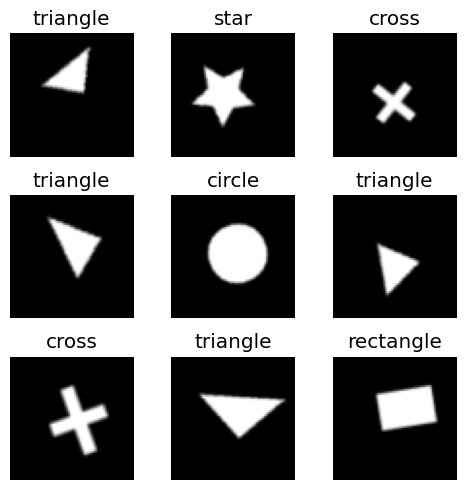

In [177]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))

shapes = ['triangle', 'rectangle', 'cross', 'circle', 'star']

for i in range(9):
    plt.subplot(3, 3, i+1)
    idx = np.random.randint(0, num_images)
    plt.imshow(images[idx], cmap='gray')
    plt.axis('off')
    plt.title(shapes[labels[idx]])

plt.tight_layout()

In [184]:
for i in range(5):
    print(f"{shapes[i]}: {np.where(labels == i)[0].shape}")

triangle: (20112,)
rectangle: (20022,)
cross: (20005,)
circle: (19897,)
star: (19964,)


In [185]:
# Save images
np.save("shape_images_64x64.npy", images)
np.save("shape_labels.npy", labels)